<a href="https://colab.research.google.com/github/gargi95/attribution-analysis-of-XAI-methos-lstm-xai/blob/main/DeepLifftSHAP_IG_Saliceny_Italy_Power_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import pandas as pd
from google.colab import drive
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import shap
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns
import random
from tqdm import tqdm
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
drive_folder_path = "/content/drive/MyDrive/UCR_Time_Series_2018/UCRArchive_2018"
dataset_name = "ItalyPowerDemand"  # Replace with the correct dataset folder name

# Verify dataset folder exists
dataset_folder = os.path.join(drive_folder_path, dataset_name)
if not os.path.exists(dataset_folder):
    raise FileNotFoundError(f"❌ Dataset folder '{dataset_name}' not found in {drive_folder_path}")

# Define file paths
train_file = os.path.join(dataset_folder, f"{dataset_name}_TRAIN.tsv")
test_file = os.path.join(dataset_folder, f"{dataset_name}_TEST.tsv")

# Verify files exist
if not os.path.exists(train_file) or not os.path.exists(test_file):
    raise FileNotFoundError(f"❌ Train/Test files not found in {dataset_folder}.")


Mounted at /content/drive


In [ ]:
print("📥 Loading dataset...")
train_data = pd.read_csv(train_file, sep='\t', header=None)
test_data = pd.read_csv(test_file, sep='\t', header=None)
print(train_data)
# Extract features and labels
y_train = train_data.iloc[:, 0].values
X_train = train_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
#The classification task is to distinguish between cooler-season days (October–March) and warmer-season days (April–September, Class 1

label_mapping = {1: 0, 2: 1}
y_train = np.array([label_mapping[label] for label in y_train])
y_test = np.array([label_mapping[label] for label in y_test])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X_train])
X_test = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X_test])

print(f"✅ Successfully loaded and normalized dataset: {dataset_name}")
print(f"📊 Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Step 1: Print dataset details
print(f"✅ Dataset: {dataset_name}")
print(f"📊 Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

# Step 2: Print first few rows of the dataset
print("\n📜 First 5 rows of Training Data (Normalized):")
print(pd.DataFrame(X_train).head())

print("\n📜 First 5 labels of Training Data:")
print(y_train[:5])

📥 Loading dataset...
    0         1         2         3         4         5         6         7   \
0    1 -0.710518 -1.183320 -1.372442 -1.593083 -1.467002 -1.372442 -1.088760   
1    1 -0.993009 -1.426786 -1.579884 -1.605401 -1.630917 -1.375754 -1.018526   
2    2  1.319067  0.569774  0.195128 -0.085856 -0.179518 -0.273180 -0.085856   
3    2 -0.812444 -1.157553 -1.416385 -1.531421 -1.502662 -1.416385 -1.646458   
4    1 -0.972840 -1.390518 -1.536705 -1.620240 -1.620240 -1.453169 -0.993724   
..  ..       ...       ...       ...       ...       ...       ...       ...   
62   1 -1.037930 -1.301658 -1.469485 -1.589361 -1.613336 -1.517435 -1.061905   
63   2 -0.373579 -0.986632 -1.446422 -1.676316 -1.752948 -1.369790 -0.910000   
64   1 -1.159152 -1.301400 -1.524933 -1.565575 -1.606217 -1.443648 -1.077867   
65   2 -0.694919 -1.235829 -1.416133 -1.506285 -1.506285 -1.506285 -1.055526   
66   2  0.984033  0.169661 -0.519423 -0.832643 -0.895287 -0.707355 -0.707355   

          8       

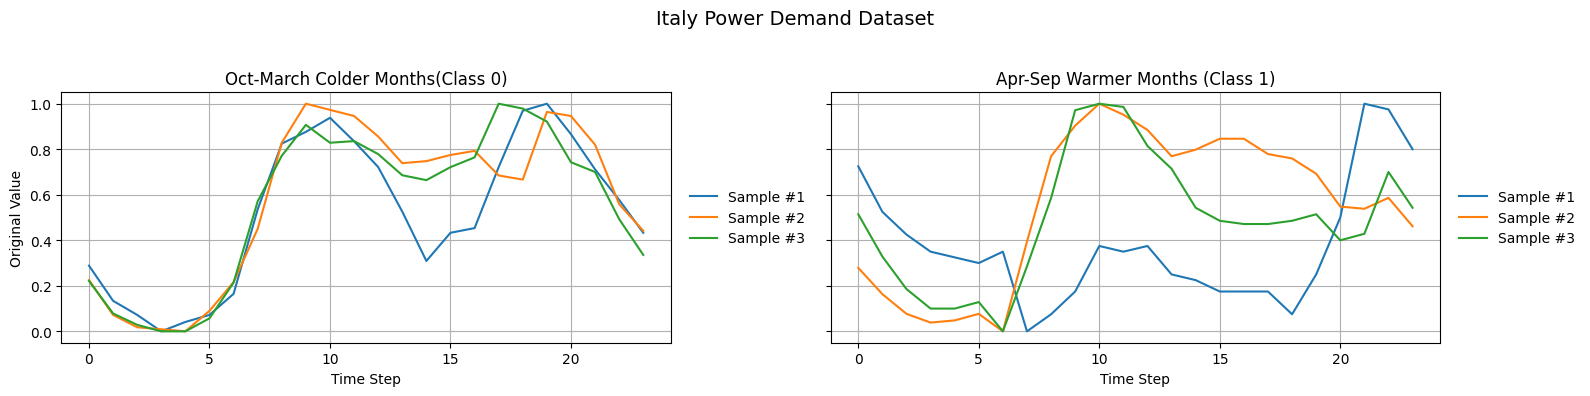

In [ ]:
def plot_representative_samples(X_train, y_train, n_samples=3):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)

    # Generate dynamic color palette
    cmap = plt.get_cmap("tab10")  # You can switch to 'viridis' or 'tab20' for >10 lines
    colors = [cmap(i % 10) for i in range(n_samples)]

    for ax, label in zip(axes, [0, 1]):
        idxs = np.where(y_train == label)[0][:n_samples]
        for j, idx in enumerate(idxs):
            ax.plot(X_train[idx], label=f"Sample #{j+1}", color=colors[j], linewidth=1.5)

        ax.set_title("Oct-March Colder Months(Class 0)" if label == 0 else "Apr-Sep Warmer Months (Class 1)")
        ax.set_xlabel("Time Step")
        ax.grid(True)
        ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)

    axes[0].set_ylabel("Original Value")
    fig.suptitle("Italy Power Demand Dataset", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ✅ Example usage:
plot_representative_samples(X_train, y_train, n_samples=3)



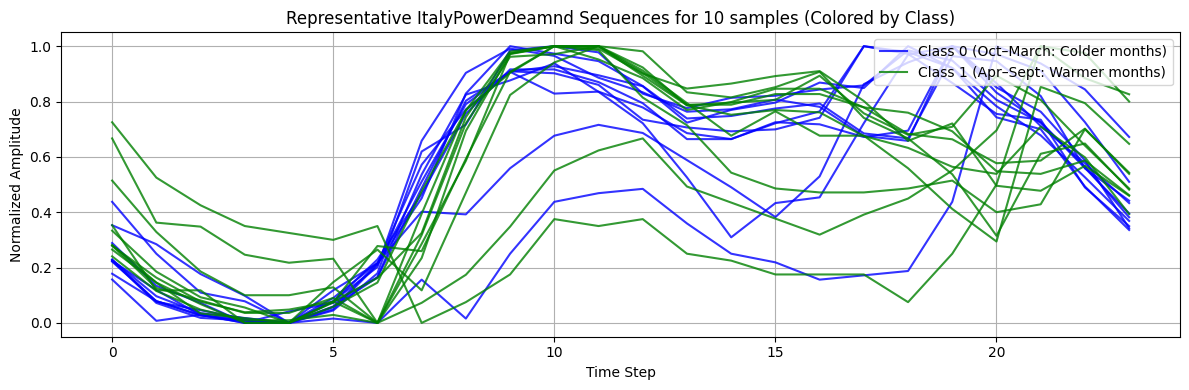

In [ ]:


def plot_ecg_with_class_colors(X, y, num_samples=10):
    classes = np.unique(y)
    colors = ['blue', 'green']  # class 0 → blue, class 1 → red
    labels_set = [False, False]

    plt.figure(figsize=(12, 4))

    for cls in classes:
        cls_indices = np.where(y == cls)[0][:num_samples]
        for i, idx in enumerate(cls_indices):
            if not labels_set[cls]:
                label = ("Class 0 (Oct–March: Colder months)" if cls == 0
                         else "Class 1 (Apr–Sept: Warmer months)")
                labels_set[cls] = True
            else:
                label = None
            plt.plot(X[idx], label=label, color=colors[cls], alpha=0.8)

    plt.title("Representative ItalyPowerDeamnd Sequences for 10 samples (Colored by Class)")
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_ecg_with_class_colors(X_train, y_train)


In [ ]:
# Merge the datasets
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

# Perform stratified split (preserving class proportions)
X_train_new, X_temp, y_train_new, y_temp = train_test_split(
    X_combined, y_combined, test_size=0.30, stratify=y_combined, random_state=42
)

X_val_new, X_test_new, y_val_new, y_test_new = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"New Train Size: {len(X_train_new)}, Validation: {len(X_val_new)}, Test: {len(X_test_new)}")

# Apply SMOTE only on the training set to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_new, y_train_new)

print(f"Train size after SMOTE: {len(X_train_resampled)}")

New Train Size: 767, Validation: 164, Test: 165
Train size after SMOTE: 768


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).unsqueeze(-1)
X_val_tensor = torch.tensor(X_val_new, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test_new, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_new, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_new, dtype=torch.long)


In [ ]:

# Hyperparameter search space (ensure hidden_dim and batch_size are integers)
param_grid = {
    'hidden_dim': [32,64,96,128,160],
    'num_layers': [2, 3],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [4,8,16, 32, 64],
    'dropout_rate': [0.1, 0.2, 0.3]
}

# Define the enhanced LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        # Ensure hidden_dim is a Python int
        if isinstance(hidden_dim, np.integer):
            hidden_dim = int(hidden_dim)
        elif not isinstance(hidden_dim, int) or hidden_dim <= 0:
            raise ValueError(f"hidden_dim must be a positive integer, got {hidden_dim} of type {type(hidden_dim)}")

        # Ensure num_layers is a Python int
        if isinstance(num_layers, np.integer):
            num_layers = int(num_layers)
        elif not isinstance(num_layers, int) or num_layers <= 0:
            raise ValueError(f"num_layers must be a positive integer, got {num_layers} of type {type(num_layers)}")

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 16),  # Intermediate layer
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, output_dim)   # Output layer
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        last_hidden_state = out[:, -1, :]
        return self.fc(self.dropout(last_hidden_state)), out

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

# Function to train and evaluate a model with given hyperparameters
def train_and_evaluate(hidden_dim, num_layers, learning_rate, batch_size, dropout_rate, X_train, y_train, X_val, y_val, X_test, y_test):
    # Debug: Print parameter types to ensure they are correct
    print(f"Debug - Parameters: hidden_dim={hidden_dim}, num_layers={num_layers}, "
          f"learning_rate={learning_rate}, batch_size={batch_size}, dropout_rate={dropout_rate}")
    print(f"Debug - hidden_dim type: {type(hidden_dim)}, num_layers type: {type(num_layers)}, "
          f"batch_size type: {type(batch_size)}")

    # Ensure hidden_dim and num_layers are Python integers
    if isinstance(hidden_dim, np.integer):
        hidden_dim = int(hidden_dim)
    elif not isinstance(hidden_dim, int) or hidden_dim <= 0:
        raise ValueError(f"hidden_dim must be a positive integer, got {hidden_dim} of type {type(hidden_dim)}")

    if isinstance(num_layers, np.integer):
        num_layers = int(num_layers)
    elif not isinstance(num_layers, int) or num_layers <= 0:
        raise ValueError(f"num_layers must be a positive integer, got {num_layers} of type {type(num_layers)}")

    # Ensure batch_size is a Python integer
    if isinstance(batch_size, np.integer):
        batch_size = int(batch_size)
    elif not isinstance(batch_size, int) or batch_size <= 0:
        raise ValueError(f"batch_size must be a positive integer, got {batch_size} of type {type(batch_size)}")

    # Create DataLoaders with explicit integer batch_size
    try:
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        test_dataset = TensorDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    except Exception as e:
        print(f"Error creating DataLoader: {e}")
        raise

    # Initialize model
    model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training with early stopping
    num_epochs = 50
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    val_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_true = [], []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
                outputs, _ = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy().flatten() > 0.5)
                val_true.extend(batch_y.cpu().numpy().flatten())
        val_loss /= len(val_loader)
        val_accuracy = accuracy_score(val_true, val_preds)

        # Test (for monitoring, but only evaluate best model on test)
        test_loss = 0
        test_preds, test_true = [], []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
                outputs, _ = model(batch_X)
                test_loss += criterion(outputs, batch_y).item()
                test_preds.extend(torch.sigmoid(outputs).cpu().numpy().flatten() > 0.5)
                test_true.extend(batch_y.cpu().numpy().flatten())
        test_loss /= len(test_loader)
        test_accuracy = accuracy_score(test_true, test_preds)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    # Final evaluation on validation and test sets
    model.eval()
    with torch.no_grad():
        # Validation final metrics
        val_preds, val_true = [], []
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
            outputs, _ = model(batch_X)
            val_preds.extend(torch.sigmoid(outputs).cpu().numpy().flatten() > 0.5)
            val_true.extend(batch_y.cpu().numpy().flatten())
        val_accuracy = accuracy_score(val_true, val_preds)
        val_precision = precision_score(val_true, val_preds)
        val_recall = recall_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds)

        # Test final metrics
        test_preds, test_true = [], []
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
            outputs, _ = model(batch_X)
            test_preds.extend(torch.sigmoid(outputs).cpu().numpy().flatten() > 0.5)
            test_true.extend(batch_y.cpu().numpy().flatten())
        test_accuracy = accuracy_score(test_true, test_preds)
        test_precision = precision_score(test_true, test_preds)
        test_recall = recall_score(test_true, test_preds)
        test_f1 = f1_score(test_true, test_preds)

        test_loss = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
            outputs, _ = model(batch_X)
            test_loss += criterion(outputs, batch_y).item()
        test_loss /= len(test_loader)

        print(f"\nBest Model - Validation: Loss: {best_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, "
              f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        print(f"Best Model - Test: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, "
              f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

        # Plot training/validation/test metrics
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.plot([i * len(train_loader) for i in range(len(test_accuracies))], [test_loss] * len(test_accuracies), label='Test Loss', linestyle='--')
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.plot(test_accuracies, label='Test Accuracy')
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.show()

    # Extract hidden states for the best model
    model.eval()
    with torch.no_grad():
        _, test_hidden_states_best = model(X_test_tensor.to(device))

    return model, test_hidden_states_best, val_accuracies, test_accuracies, train_losses, val_losses, test_loss

Hyperparameter Trials:   0%|          | 0/100 [00:00<?, ?it/s]


🔁 Trial 1: hidden_dim=32, num_layers=2, lr=0.01, batch_size=16, dropout=0.1
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.01, batch_size=16, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6967, Val Loss: 0.6805, Val Acc: 0.8476, Test Acc: 0.8545
Epoch [2/50], Train Loss: 0.5606, Val Loss: 0.3554, Val Acc: 0.8780, Test Acc: 0.9394
Epoch [3/50], Train Loss: 0.1954, Val Loss: 0.1211, Val Acc: 0.9573, Test Acc: 0.9636
Epoch [4/50], Train Loss: 0.1161, Val Loss: 0.1126, Val Acc: 0.9756, Test Acc: 0.9758
Epoch [5/50], Train Loss: 0.1233, Val Loss: 0.1417, Val Acc: 0.9451, Test Acc: 0.9697
Epoch [6/50], Train Loss: 0.1272, Val Loss: 0.1100, Val Acc: 0.9695, Test Acc: 0.9697
Epoch [7/50], Train Loss: 0.0954, Val Loss: 0.0895, Val Acc: 0.9756, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.0976, Val Loss: 0.1071, Val Acc: 0.9756, Test Acc: 0.9697
Epoch [9/50], Train Loss: 0.095

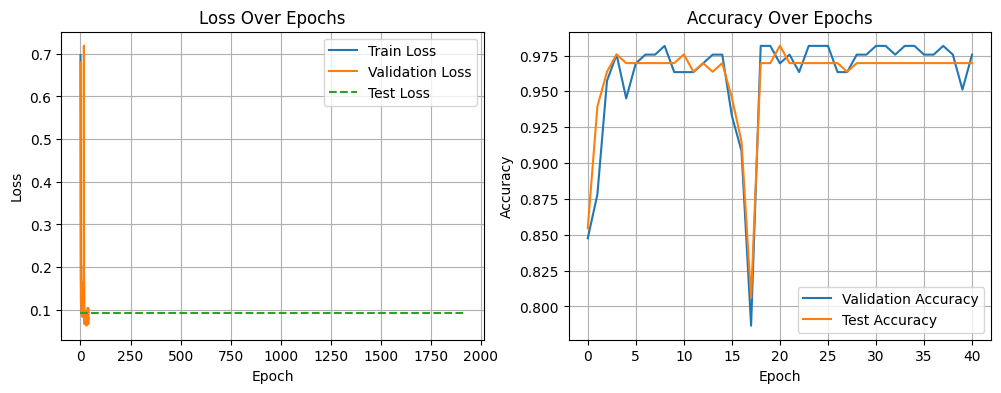

Hyperparameter Trials:   1%|          | 1/100 [00:21<35:02, 21.24s/it]

✅ New Best Model at Trial 1 with Test Loss = 0.0929
✅ New Best Model at Trial 1 with Test Loss = 0.0929

🔁 Trial 2: hidden_dim=64, num_layers=2, lr=0.01, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.01, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7009, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6944, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6946, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6939, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6941, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6939, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6945, Val Loss: 0.6939, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], T

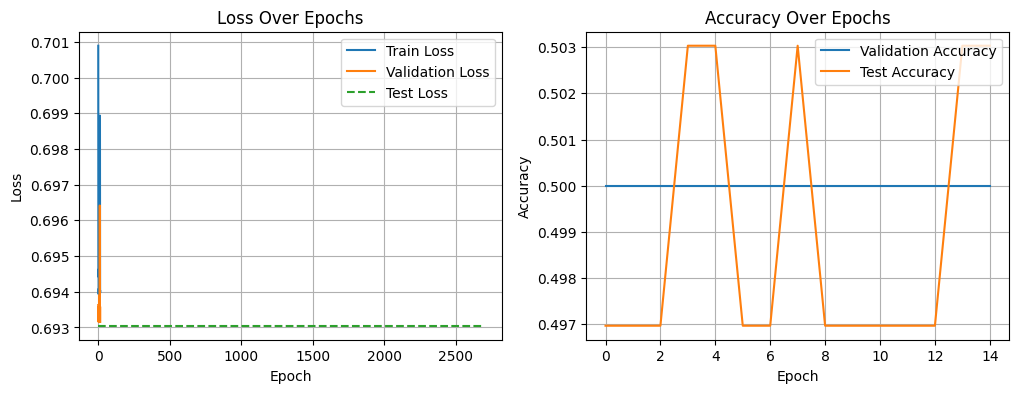

Hyperparameter Trials:   2%|▏         | 2/100 [00:40<33:02, 20.23s/it]


🔁 Trial 3: hidden_dim=160, num_layers=2, lr=0.01, batch_size=32, dropout=0.1
Debug - Parameters: hidden_dim=160, num_layers=2, learning_rate=0.01, batch_size=32, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7107, Val Loss: 0.7069, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6971, Val Loss: 0.6985, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6944, Val Loss: 0.6967, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6937, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6933, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6932, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6933, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6933, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.6

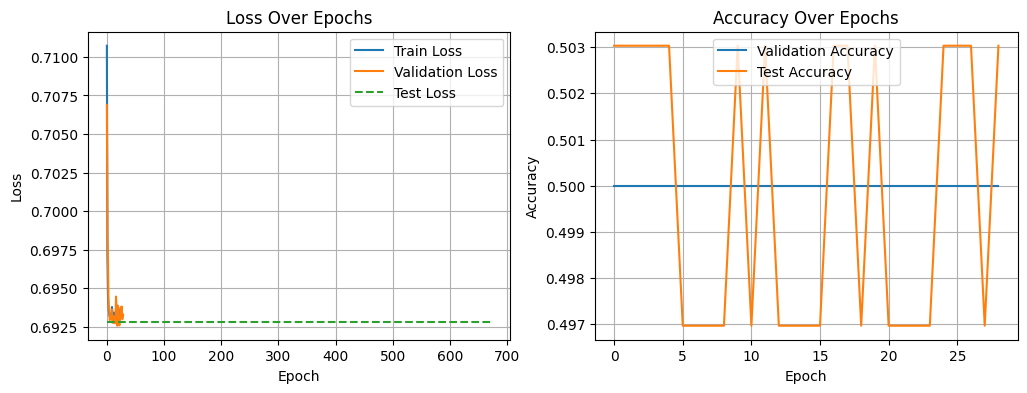

Hyperparameter Trials:   3%|▎         | 3/100 [01:25<51:06, 31.61s/it]


🔁 Trial 4: hidden_dim=32, num_layers=2, lr=0.0001, batch_size=8, dropout=0.3
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.0001, batch_size=8, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6950, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6949, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6940, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6951, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6934, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6923, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6936, Val Loss: 0.6923, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6923, Val Loss: 0.6920, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.6

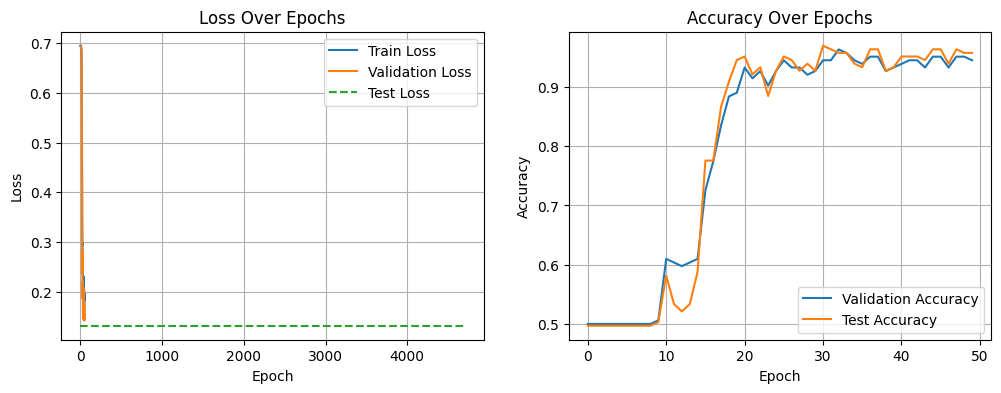

Hyperparameter Trials:   4%|▍         | 4/100 [01:53<47:45, 29.85s/it]


🔁 Trial 5: hidden_dim=160, num_layers=2, lr=0.01, batch_size=8, dropout=0.3
Debug - Parameters: hidden_dim=160, num_layers=2, learning_rate=0.01, batch_size=8, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6970, Val Loss: 0.6939, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6938, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6937, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6936, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6938, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6938, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6941, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6951, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.694

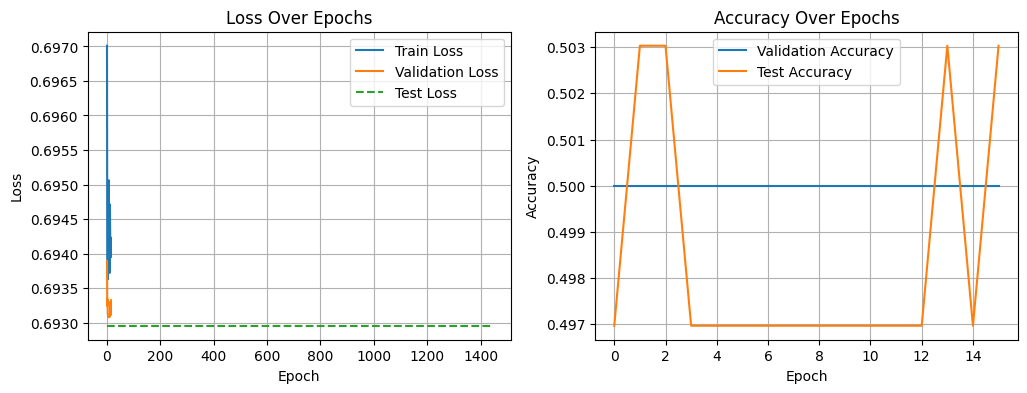

Hyperparameter Trials:   5%|▌         | 5/100 [02:25<48:36, 30.70s/it]


🔁 Trial 6: hidden_dim=160, num_layers=3, lr=0.0001, batch_size=32, dropout=0.3
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.0001, batch_size=32, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6997, Val Loss: 0.7064, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6985, Val Loss: 0.7045, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6962, Val Loss: 0.7010, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6954, Val Loss: 0.6980, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6924, Val Loss: 0.6917, Val Acc: 0.5854, Test Acc: 0.5939
Epoch [6/50], Train Loss: 0.6909, Val Loss: 0.6895, Val Acc: 0.5122, Test Acc: 0.5091
Epoch [7/50], Train Loss: 0.6939, Val Loss: 0.6905, Val Acc: 0.5915, Test Acc: 0.5273
Epoch [8/50], Train Loss: 0.6919, Val Loss: 0.6898, Val Acc: 0.6098, Test Acc: 0.5212
Epoch [9/50], Train Loss:

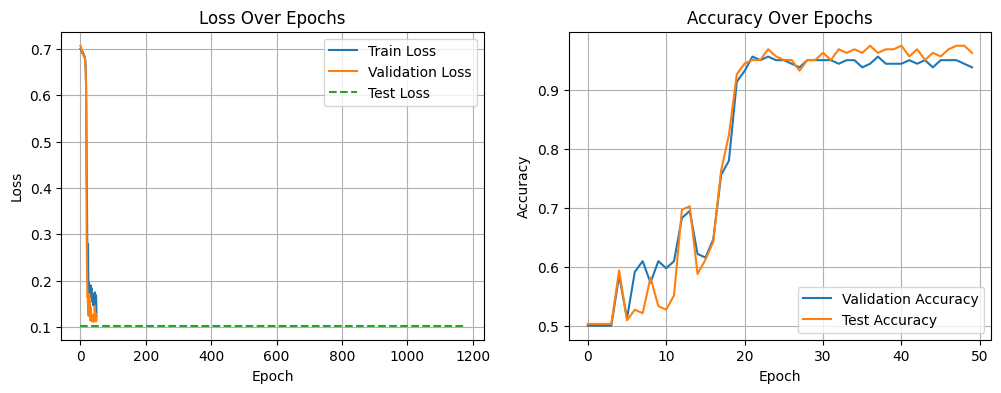

Hyperparameter Trials:   6%|▌         | 6/100 [04:13<1:29:34, 57.18s/it]


🔁 Trial 7: hidden_dim=96, num_layers=2, lr=0.0001, batch_size=32, dropout=0.2
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.0001, batch_size=32, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6942, Val Loss: 0.6908, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6942, Val Loss: 0.6909, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6940, Val Loss: 0.6910, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6938, Val Loss: 0.6910, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6934, Val Loss: 0.6910, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6937, Val Loss: 0.6910, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6930, Val Loss: 0.6911, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6926, Val Loss: 0.6912, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0

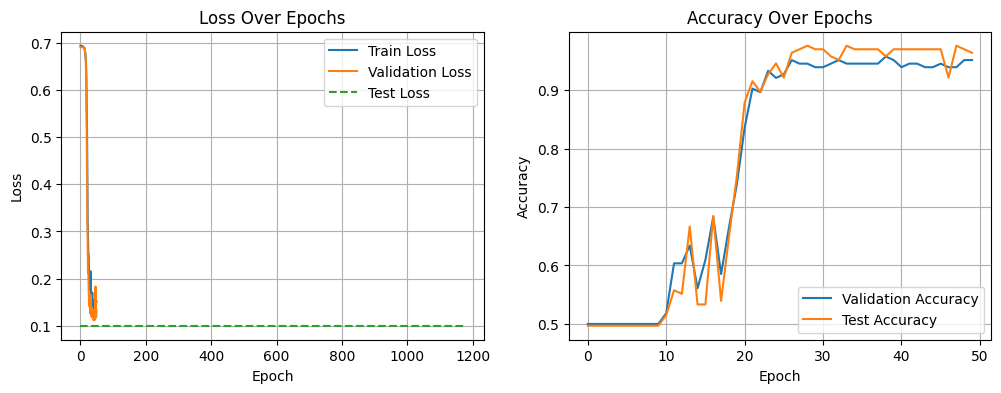

Hyperparameter Trials:   7%|▋         | 7/100 [04:48<1:17:21, 49.91s/it]


🔁 Trial 8: hidden_dim=96, num_layers=2, lr=0.0001, batch_size=16, dropout=0.1
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.0001, batch_size=16, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6977, Val Loss: 0.7001, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6967, Val Loss: 0.6986, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6946, Val Loss: 0.6959, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6933, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6909, Val Loss: 0.6901, Val Acc: 0.6159, Test Acc: 0.5879
Epoch [6/50], Train Loss: 0.6908, Val Loss: 0.6898, Val Acc: 0.6890, Test Acc: 0.6970
Epoch [7/50], Train Loss: 0.6906, Val Loss: 0.6887, Val Acc: 0.6280, Test Acc: 0.5697
Epoch [8/50], Train Loss: 0.6877, Val Loss: 0.6860, Val Acc: 0.5366, Test Acc: 0.5515
Epoch [9/50], Train Loss: 0

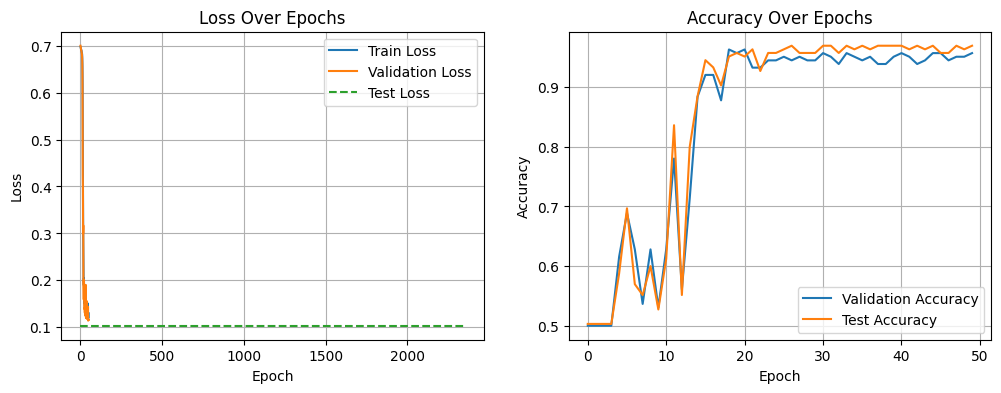

Hyperparameter Trials:   8%|▊         | 8/100 [05:30<1:12:26, 47.25s/it]


🔁 Trial 9: hidden_dim=32, num_layers=3, lr=0.0001, batch_size=16, dropout=0.2
Debug - Parameters: hidden_dim=32, num_layers=3, learning_rate=0.0001, batch_size=16, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6970, Val Loss: 0.6939, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6969, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6958, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6965, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6961, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6938, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6955, Val Loss: 0.6927, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6950, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0

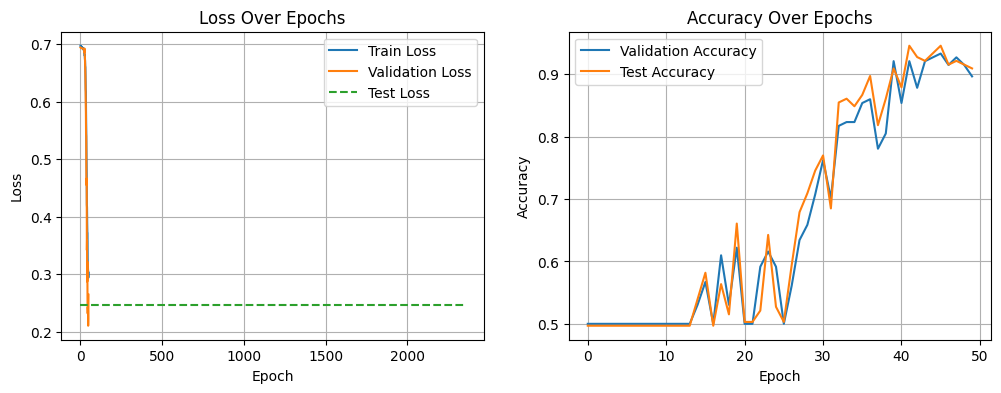

Hyperparameter Trials:   9%|▉         | 9/100 [05:53<1:00:10, 39.67s/it]


🔁 Trial 10: hidden_dim=160, num_layers=3, lr=0.0001, batch_size=32, dropout=0.3
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.0001, batch_size=32, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6947, Val Loss: 0.6978, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6945, Val Loss: 0.6974, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6950, Val Loss: 0.6974, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6947, Val Loss: 0.6970, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6942, Val Loss: 0.6966, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6937, Val Loss: 0.6955, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6927, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6877, Val Loss: 0.6870, Val Acc: 0.5244, Test Acc: 0.5333
Epoch [9/50], Train Loss

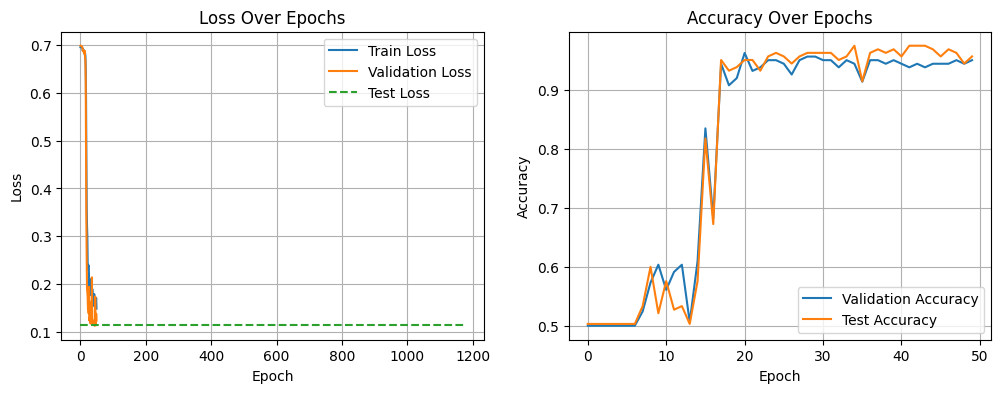

Hyperparameter Trials:  10%|█         | 10/100 [07:41<1:31:01, 60.68s/it]


🔁 Trial 11: hidden_dim=32, num_layers=3, lr=0.0001, batch_size=64, dropout=0.2
Debug - Parameters: hidden_dim=32, num_layers=3, learning_rate=0.0001, batch_size=64, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7008, Val Loss: 0.6984, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.7001, Val Loss: 0.6980, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6996, Val Loss: 0.6977, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6986, Val Loss: 0.6974, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6988, Val Loss: 0.6971, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6986, Val Loss: 0.6968, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6975, Val Loss: 0.6965, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6981, Val Loss: 0.6962, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 

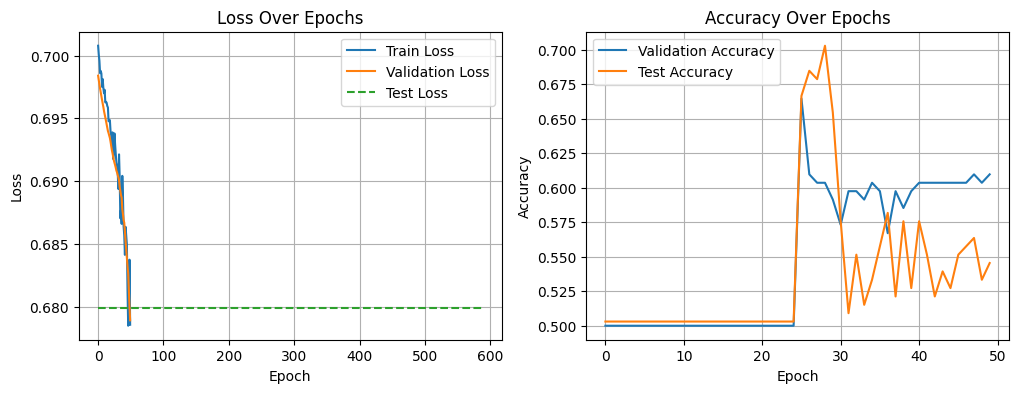

Hyperparameter Trials:  11%|█         | 11/100 [07:55<1:09:13, 46.67s/it]


🔁 Trial 12: hidden_dim=160, num_layers=3, lr=0.01, batch_size=8, dropout=0.3
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.01, batch_size=8, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7003, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6948, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6958, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6942, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6940, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6946, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6937, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6938, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6931, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6940, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


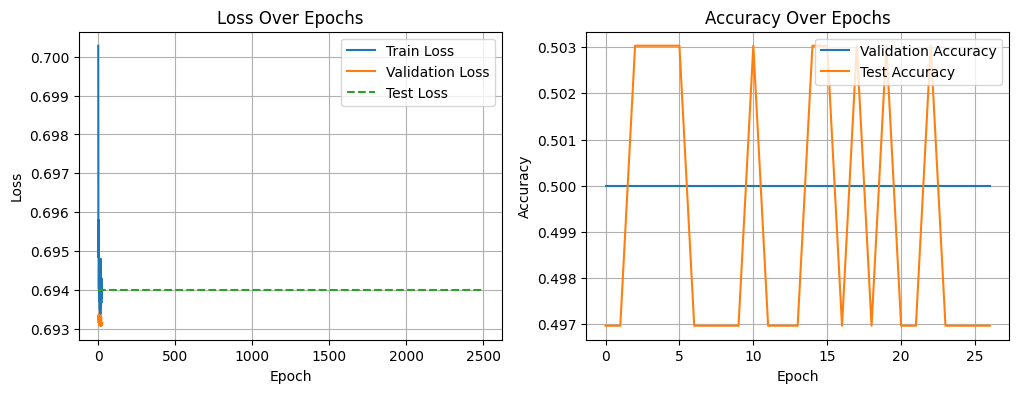

Hyperparameter Trials:  12%|█▏        | 12/100 [09:20<1:25:23, 58.22s/it]


🔁 Trial 13: hidden_dim=32, num_layers=2, lr=0.01, batch_size=8, dropout=0.2
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.01, batch_size=8, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6969, Val Loss: 0.6901, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6825, Val Loss: 0.6844, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.5753, Val Loss: 0.6197, Val Acc: 0.7134, Test Acc: 0.7576
Epoch [4/50], Train Loss: 0.2329, Val Loss: 0.1656, Val Acc: 0.9329, Test Acc: 0.9636
Epoch [5/50], Train Loss: 0.1776, Val Loss: 0.1548, Val Acc: 0.9451, Test Acc: 0.9455
Epoch [6/50], Train Loss: 0.1629, Val Loss: 0.2469, Val Acc: 0.9207, Test Acc: 0.9394
Epoch [7/50], Train Loss: 0.1559, Val Loss: 0.1171, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1244, Val Loss: 0.1495, Val Acc: 0.9573, Test Acc: 0.9697
Epoch [9/50], Train Loss: 0.1338

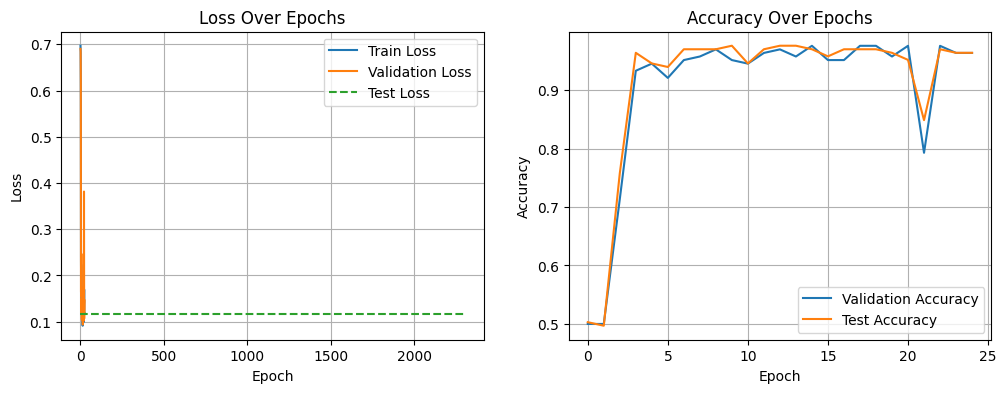

Hyperparameter Trials:  13%|█▎        | 13/100 [09:35<1:05:10, 44.94s/it]


🔁 Trial 14: hidden_dim=32, num_layers=2, lr=0.0001, batch_size=32, dropout=0.2
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.0001, batch_size=32, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6934, Val Loss: 0.6919, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6944, Val Loss: 0.6920, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6940, Val Loss: 0.6920, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6930, Val Loss: 0.6920, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6937, Val Loss: 0.6919, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6923, Val Loss: 0.6920, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6931, Val Loss: 0.6920, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6930, Val Loss: 0.6920, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


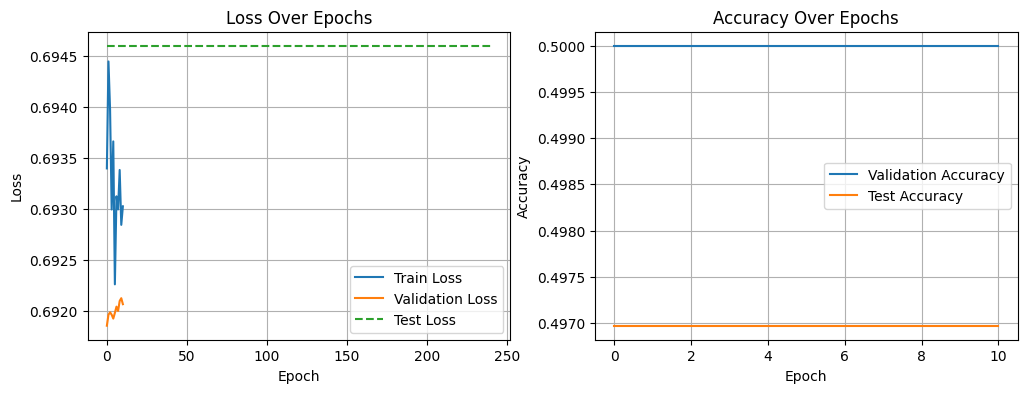

Hyperparameter Trials:  14%|█▍        | 14/100 [09:38<46:24, 32.38s/it]  


🔁 Trial 15: hidden_dim=128, num_layers=3, lr=0.0001, batch_size=16, dropout=0.2
Debug - Parameters: hidden_dim=128, num_layers=3, learning_rate=0.0001, batch_size=16, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6957, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6950, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6942, Val Loss: 0.6924, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6934, Val Loss: 0.6918, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6926, Val Loss: 0.6908, Val Acc: 0.5976, Test Acc: 0.6545
Epoch [6/50], Train Loss: 0.6909, Val Loss: 0.6883, Val Acc: 0.5610, Test Acc: 0.5758
Epoch [7/50], Train Loss: 0.6869, Val Loss: 0.6846, Val Acc: 0.5610, Test Acc: 0.5333
Epoch [8/50], Train Loss: 0.6831, Val Loss: 0.6795, Val Acc: 0.5976, Test Acc: 0.5879
Epoch [9/50], Train Loss

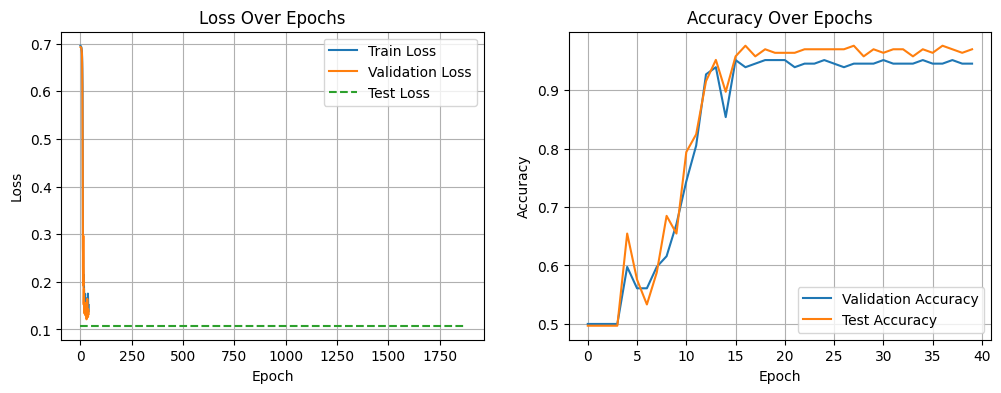

Hyperparameter Trials:  15%|█▌        | 15/100 [10:46<1:01:15, 43.24s/it]


🔁 Trial 16: hidden_dim=64, num_layers=3, lr=0.01, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=64, num_layers=3, learning_rate=0.01, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6974, Val Loss: 0.6949, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6961, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6944, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6938, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6943, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6943, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.7010, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6943, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.6942

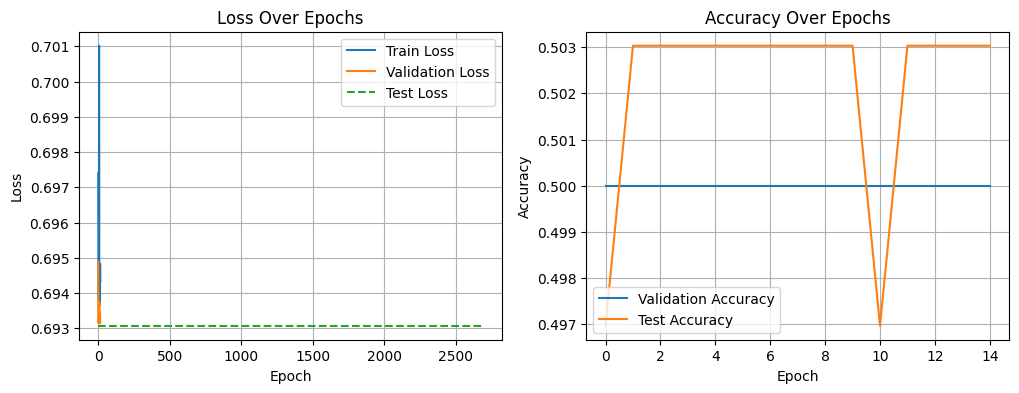

Hyperparameter Trials:  16%|█▌        | 16/100 [11:11<52:37, 37.59s/it]  


🔁 Trial 17: hidden_dim=64, num_layers=2, lr=0.0001, batch_size=32, dropout=0.2
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.0001, batch_size=32, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6979, Val Loss: 0.6907, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6974, Val Loss: 0.6906, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6972, Val Loss: 0.6906, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6966, Val Loss: 0.6905, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6964, Val Loss: 0.6905, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6964, Val Loss: 0.6904, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6953, Val Loss: 0.6904, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6947, Val Loss: 0.6904, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 

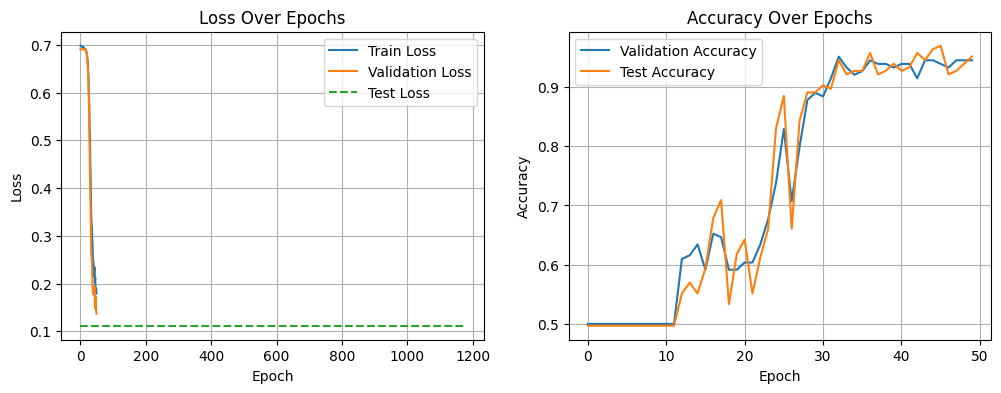

Hyperparameter Trials:  17%|█▋        | 17/100 [11:34<45:56, 33.21s/it]


🔁 Trial 18: hidden_dim=96, num_layers=2, lr=0.01, batch_size=16, dropout=0.1
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.01, batch_size=16, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6952, Val Loss: 0.6940, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6939, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6936, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6933, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6935, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6934, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6937, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6942, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


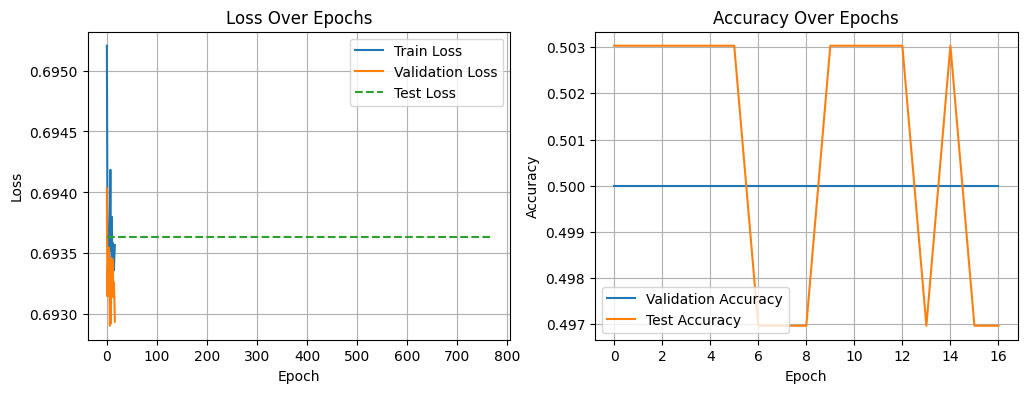

Hyperparameter Trials:  18%|█▊        | 18/100 [11:49<37:50, 27.68s/it]


🔁 Trial 19: hidden_dim=64, num_layers=2, lr=0.001, batch_size=32, dropout=0.2
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.001, batch_size=32, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6928, Val Loss: 0.6923, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6925, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6912, Val Loss: 0.6847, Val Acc: 0.5183, Test Acc: 0.5091
Epoch [4/50], Train Loss: 0.6793, Val Loss: 0.6539, Val Acc: 0.8049, Test Acc: 0.7939
Epoch [5/50], Train Loss: 0.6232, Val Loss: 0.5328, Val Acc: 0.6646, Test Acc: 0.7091
Epoch [6/50], Train Loss: 0.3806, Val Loss: 0.2274, Val Acc: 0.9268, Test Acc: 0.9394
Epoch [7/50], Train Loss: 0.2220, Val Loss: 0.1330, Val Acc: 0.9390, Test Acc: 0.9576
Epoch [8/50], Train Loss: 0.1830, Val Loss: 0.1924, Val Acc: 0.9146, Test Acc: 0.9212
Epoch [9/50], Train Loss: 0.

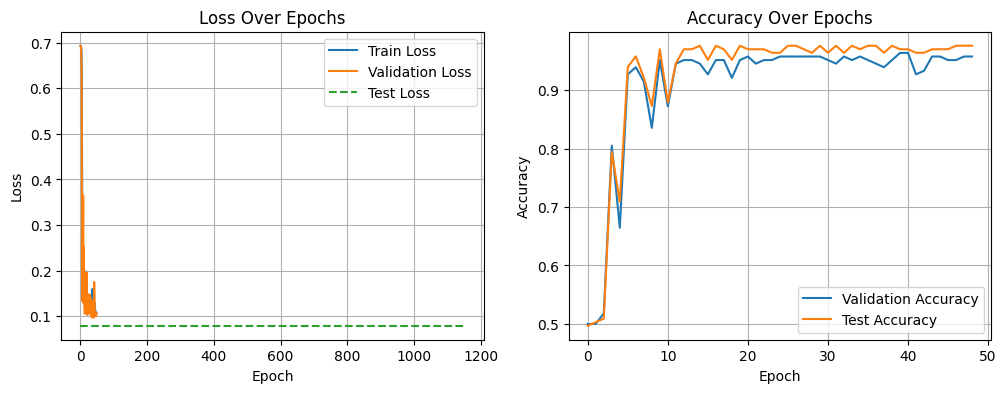

Hyperparameter Trials:  19%|█▉        | 19/100 [12:11<35:07, 26.02s/it]

✅ New Best Model at Trial 19 with Test Loss = 0.0792
✅ New Best Model at Trial 19 with Test Loss = 0.0792

🔁 Trial 20: hidden_dim=32, num_layers=2, lr=0.01, batch_size=16, dropout=0.1
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.01, batch_size=16, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6960, Val Loss: 0.6940, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6337, Val Loss: 0.6216, Val Acc: 0.7195, Test Acc: 0.7091
Epoch [3/50], Train Loss: 0.4385, Val Loss: 0.1761, Val Acc: 0.9451, Test Acc: 0.9758
Epoch [4/50], Train Loss: 0.2490, Val Loss: 0.1368, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [5/50], Train Loss: 0.1746, Val Loss: 0.1032, Val Acc: 0.9573, Test Acc: 0.9697
Epoch [6/50], Train Loss: 0.1246, Val Loss: 0.0968, Val Acc: 0.9634, Test Acc: 0.9697
Epoch [7/50], Train Loss: 0.1112, Val Loss: 0.1612, Val Acc: 0.9634, Test Acc: 0.9697
Epoch [8/5

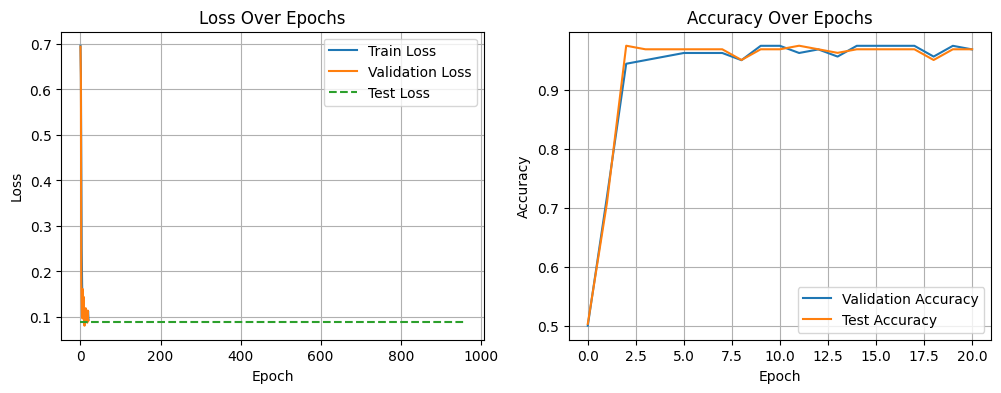

Hyperparameter Trials:  20%|██        | 20/100 [12:19<27:25, 20.57s/it]


🔁 Trial 21: hidden_dim=128, num_layers=3, lr=0.01, batch_size=32, dropout=0.1
Debug - Parameters: hidden_dim=128, num_layers=3, learning_rate=0.01, batch_size=32, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7033, Val Loss: 0.6923, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.7016, Val Loss: 0.6939, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6939, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6934, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6934, Val Loss: 0.6916, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6939, Val Loss: 0.6942, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6939, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6935, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6916, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6937, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


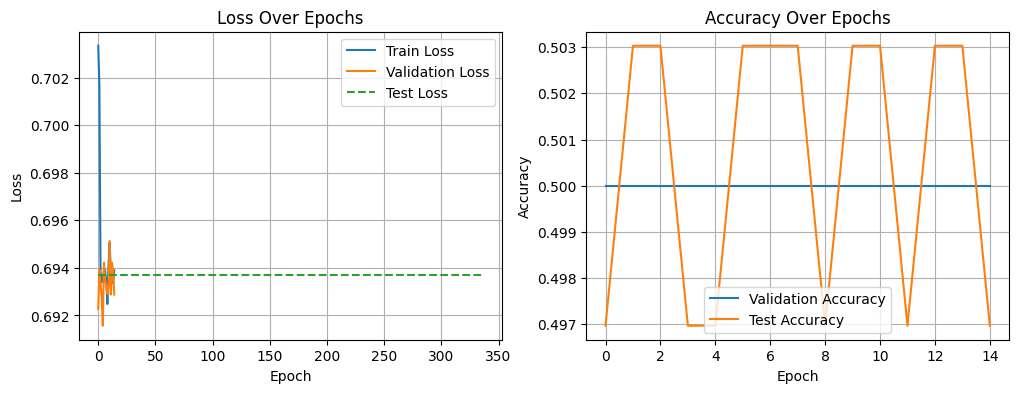

Hyperparameter Trials:  21%|██        | 21/100 [12:43<28:26, 21.60s/it]


🔁 Trial 22: hidden_dim=96, num_layers=2, lr=0.0001, batch_size=64, dropout=0.3
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.0001, batch_size=64, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6975, Val Loss: 0.6988, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6973, Val Loss: 0.6982, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6969, Val Loss: 0.6977, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6962, Val Loss: 0.6973, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6957, Val Loss: 0.6969, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6946, Val Loss: 0.6964, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6954, Val Loss: 0.6960, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6957, Val Loss: 0.6956, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 

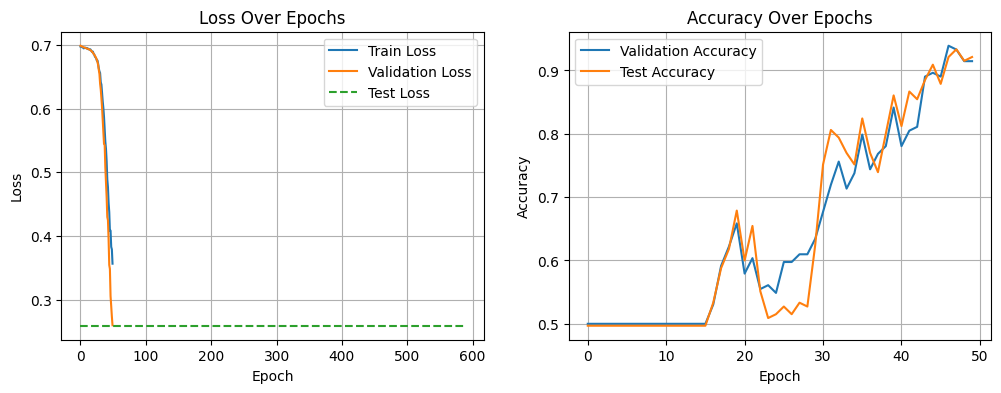

Hyperparameter Trials:  22%|██▏       | 22/100 [13:13<31:28, 24.21s/it]


🔁 Trial 23: hidden_dim=96, num_layers=3, lr=0.01, batch_size=32, dropout=0.2
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.01, batch_size=32, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6967, Val Loss: 0.7014, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6943, Val Loss: 0.6944, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6933, Val Loss: 0.6940, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6934, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6933, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6932, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6933, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6934, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6926, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6935, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


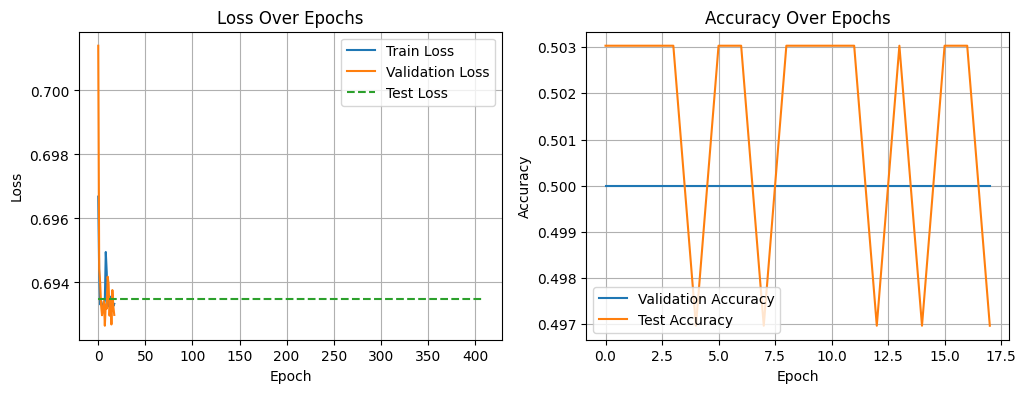

Hyperparameter Trials:  23%|██▎       | 23/100 [13:31<28:50, 22.48s/it]


🔁 Trial 24: hidden_dim=64, num_layers=2, lr=0.01, batch_size=32, dropout=0.1
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.01, batch_size=32, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6952, Val Loss: 0.6921, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6942, Val Loss: 0.6906, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6145, Val Loss: 0.3129, Val Acc: 0.8720, Test Acc: 0.9273
Epoch [4/50], Train Loss: 0.2260, Val Loss: 0.1927, Val Acc: 0.9451, Test Acc: 0.9212
Epoch [5/50], Train Loss: 0.1417, Val Loss: 0.1860, Val Acc: 0.9329, Test Acc: 0.9333
Epoch [6/50], Train Loss: 0.1555, Val Loss: 0.1481, Val Acc: 0.9512, Test Acc: 0.9879
Epoch [7/50], Train Loss: 0.1329, Val Loss: 0.1045, Val Acc: 0.9695, Test Acc: 0.9576
Epoch [8/50], Train Loss: 0.1149, Val Loss: 0.1498, Val Acc: 0.9573, Test Acc: 0.9636
Epoch [9/50], Train Loss: 0.13

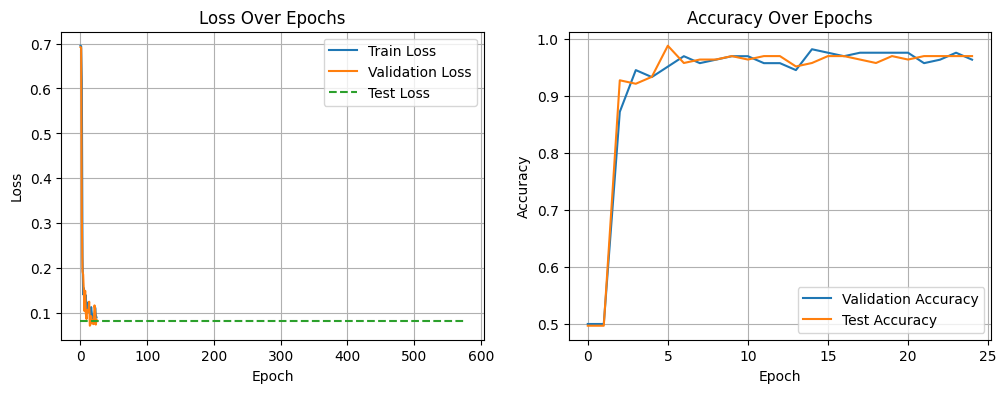

Hyperparameter Trials:  24%|██▍       | 24/100 [13:43<24:17, 19.17s/it]


🔁 Trial 25: hidden_dim=32, num_layers=2, lr=0.0001, batch_size=8, dropout=0.3
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.0001, batch_size=8, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6939, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6933, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6934, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6926, Val Loss: 0.6927, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6934, Val Loss: 0.6925, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6928, Val Loss: 0.6922, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6925, Val Loss: 0.6917, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6912, Val Loss: 0.6909, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.

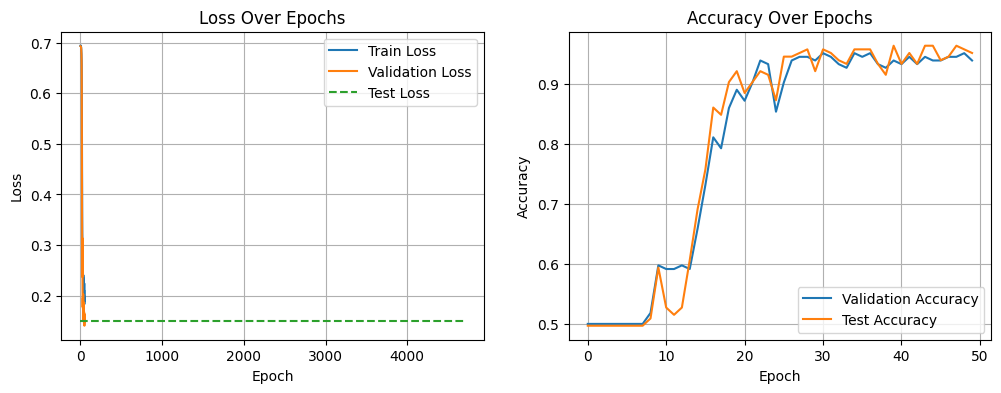

Hyperparameter Trials:  25%|██▌       | 25/100 [14:10<27:02, 21.64s/it]


🔁 Trial 26: hidden_dim=128, num_layers=2, lr=0.001, batch_size=32, dropout=0.3
Debug - Parameters: hidden_dim=128, num_layers=2, learning_rate=0.001, batch_size=32, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6933, Val Loss: 0.6915, Val Acc: 0.5671, Test Acc: 0.5758
Epoch [2/50], Train Loss: 0.6908, Val Loss: 0.6847, Val Acc: 0.5122, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6740, Val Loss: 0.6370, Val Acc: 0.8293, Test Acc: 0.8667
Epoch [4/50], Train Loss: 0.4402, Val Loss: 0.2810, Val Acc: 0.8720, Test Acc: 0.8848
Epoch [5/50], Train Loss: 0.3739, Val Loss: 0.2005, Val Acc: 0.9207, Test Acc: 0.9515
Epoch [6/50], Train Loss: 0.2659, Val Loss: 0.2173, Val Acc: 0.9024, Test Acc: 0.9333
Epoch [7/50], Train Loss: 0.1865, Val Loss: 0.1256, Val Acc: 0.9390, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1630, Val Loss: 0.1316, Val Acc: 0.9573, Test Acc: 0.9697
Epoch [9/50], Train Loss: 

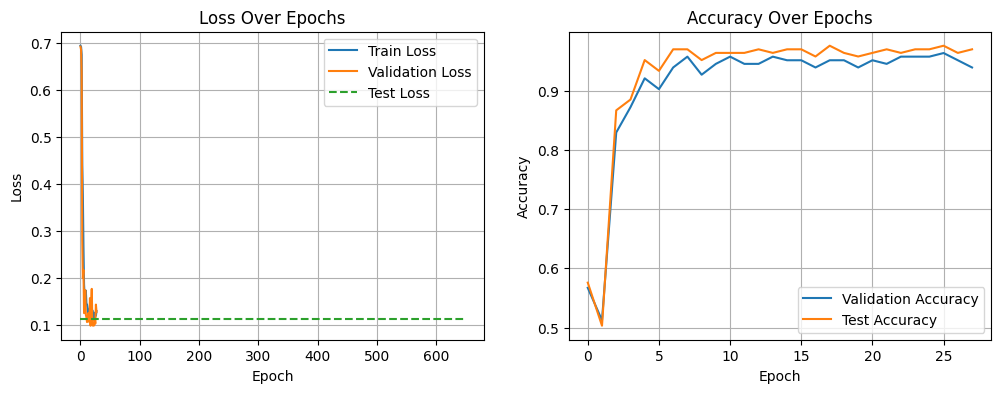

Hyperparameter Trials:  26%|██▌       | 26/100 [14:38<29:09, 23.64s/it]


🔁 Trial 27: hidden_dim=128, num_layers=3, lr=0.01, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=128, num_layers=3, learning_rate=0.01, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7010, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6942, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6936, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6944, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6946, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6943, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6938, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6944, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6931, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6952, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


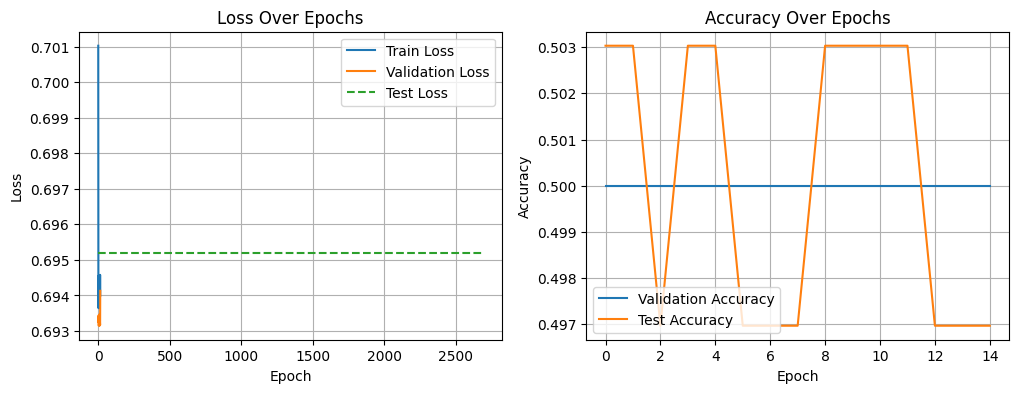

Hyperparameter Trials:  27%|██▋       | 27/100 [15:31<39:21, 32.35s/it]


🔁 Trial 28: hidden_dim=32, num_layers=3, lr=0.01, batch_size=16, dropout=0.1
Debug - Parameters: hidden_dim=32, num_layers=3, learning_rate=0.01, batch_size=16, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6975, Val Loss: 0.6959, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6948, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6940, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6937, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6961, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6938, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6933, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6934, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


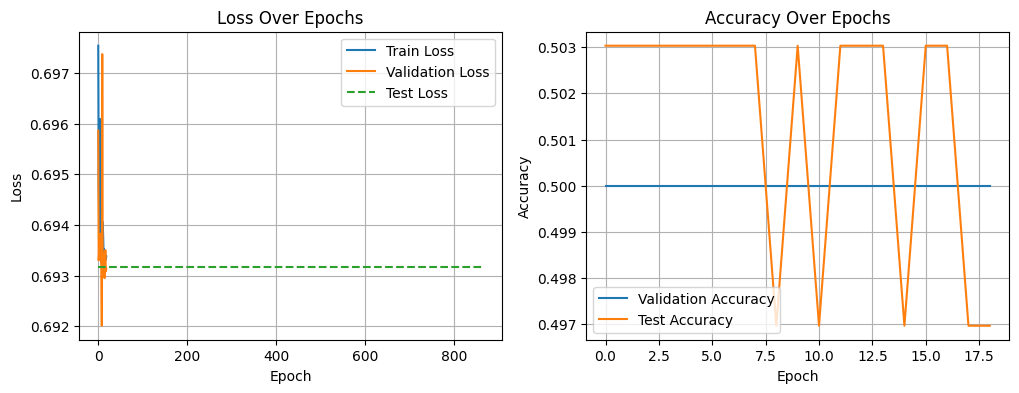

Hyperparameter Trials:  28%|██▊       | 28/100 [15:41<30:40, 25.57s/it]


🔁 Trial 29: hidden_dim=96, num_layers=3, lr=0.0001, batch_size=32, dropout=0.1
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.0001, batch_size=32, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6981, Val Loss: 0.7049, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6973, Val Loss: 0.7027, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6962, Val Loss: 0.7010, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6951, Val Loss: 0.6995, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6944, Val Loss: 0.6969, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6922, Val Loss: 0.6918, Val Acc: 0.5549, Test Acc: 0.5212
Epoch [7/50], Train Loss: 0.6927, Val Loss: 0.6909, Val Acc: 0.6037, Test Acc: 0.5212
Epoch [8/50], Train Loss: 0.6907, Val Loss: 0.6897, Val Acc: 0.5610, Test Acc: 0.5758
Epoch [9/50], Train Loss: 

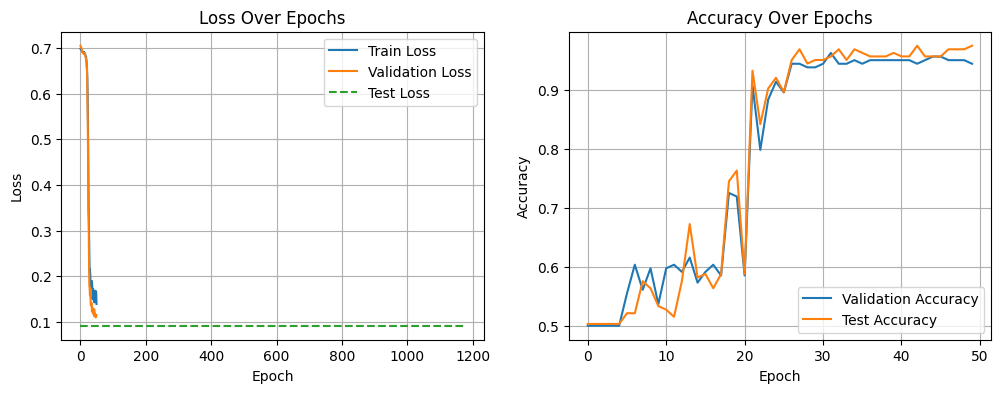

Hyperparameter Trials:  29%|██▉       | 29/100 [16:32<39:14, 33.16s/it]


🔁 Trial 30: hidden_dim=96, num_layers=2, lr=0.01, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.01, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7063, Val Loss: 0.6943, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6945, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6945, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6943, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6942, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6937, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6943, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6941, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.6941

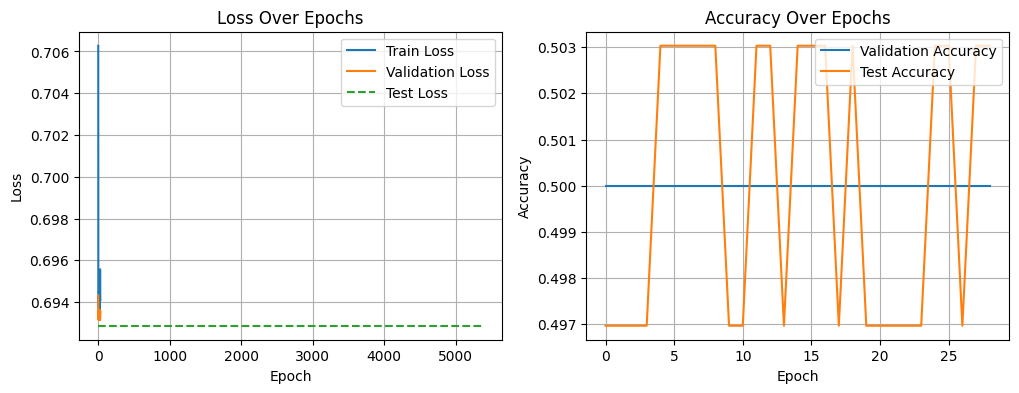

Hyperparameter Trials:  30%|███       | 30/100 [17:21<44:23, 38.05s/it]


🔁 Trial 31: hidden_dim=96, num_layers=2, lr=0.0001, batch_size=16, dropout=0.1
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.0001, batch_size=16, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6955, Val Loss: 0.6973, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6944, Val Loss: 0.6959, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6943, Val Loss: 0.6951, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6932, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6924, Val Loss: 0.6913, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6893, Val Loss: 0.6874, Val Acc: 0.5366, Test Acc: 0.5576
Epoch [7/50], Train Loss: 0.6876, Val Loss: 0.6862, Val Acc: 0.6463, Test Acc: 0.6182
Epoch [8/50], Train Loss: 0.6855, Val Loss: 0.6807, Val Acc: 0.6341, Test Acc: 0.6182
Epoch [9/50], Train Loss: 

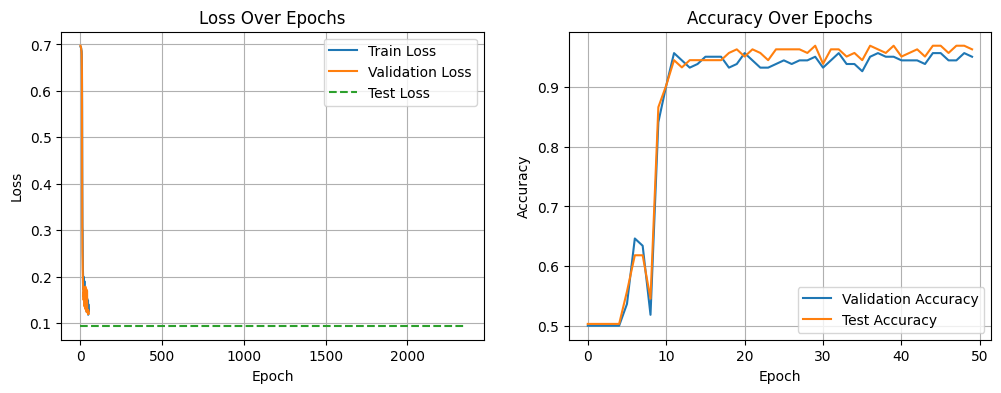

Hyperparameter Trials:  31%|███       | 31/100 [18:02<44:46, 38.93s/it]


🔁 Trial 32: hidden_dim=160, num_layers=2, lr=0.01, batch_size=16, dropout=0.2
Debug - Parameters: hidden_dim=160, num_layers=2, learning_rate=0.01, batch_size=16, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7004, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6953, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6965, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6964, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6941, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6932, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6939, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6936, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6926, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6934, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


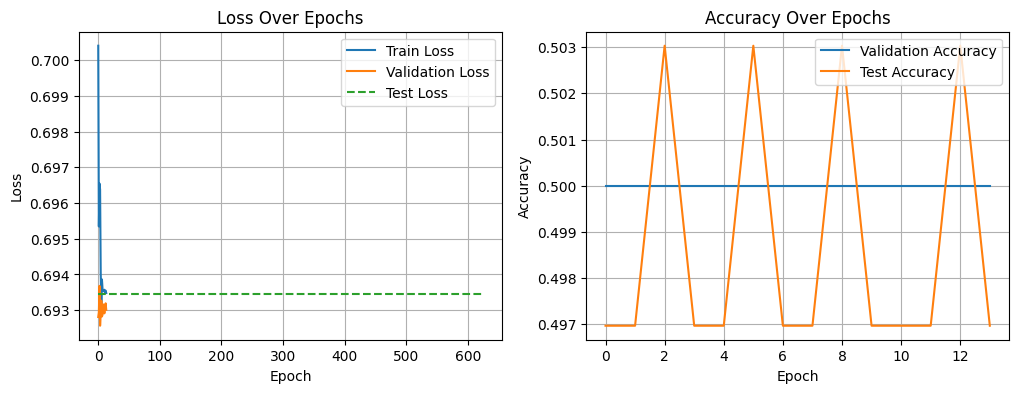

Hyperparameter Trials:  32%|███▏      | 32/100 [18:25<38:46, 34.21s/it]


🔁 Trial 33: hidden_dim=32, num_layers=2, lr=0.001, batch_size=16, dropout=0.1
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.001, batch_size=16, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6944, Val Loss: 0.6942, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6921, Val Loss: 0.6905, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6804, Val Loss: 0.6527, Val Acc: 0.7683, Test Acc: 0.8242
Epoch [4/50], Train Loss: 0.4942, Val Loss: 0.2748, Val Acc: 0.9207, Test Acc: 0.9333
Epoch [5/50], Train Loss: 0.2511, Val Loss: 0.1774, Val Acc: 0.9451, Test Acc: 0.9455
Epoch [6/50], Train Loss: 0.1924, Val Loss: 0.1506, Val Acc: 0.9390, Test Acc: 0.9515
Epoch [7/50], Train Loss: 0.1814, Val Loss: 0.1430, Val Acc: 0.9512, Test Acc: 0.9576
Epoch [8/50], Train Loss: 0.1568, Val Loss: 0.1186, Val Acc: 0.9573, Test Acc: 0.9636
Epoch [9/50], Train Loss: 0.

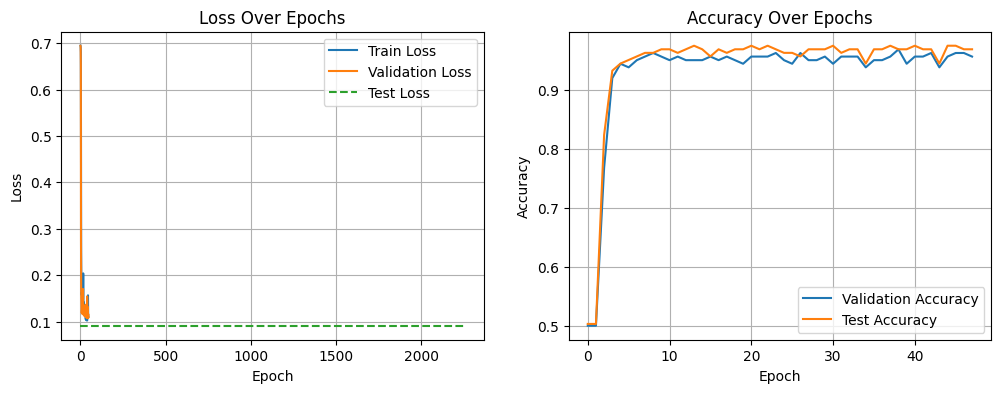

Hyperparameter Trials:  33%|███▎      | 33/100 [18:43<32:41, 29.27s/it]


🔁 Trial 34: hidden_dim=32, num_layers=2, lr=0.01, batch_size=4, dropout=0.1
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.01, batch_size=4, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6970, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6944, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6940, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6943, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6932, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6942, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6938, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6935, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.6939

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


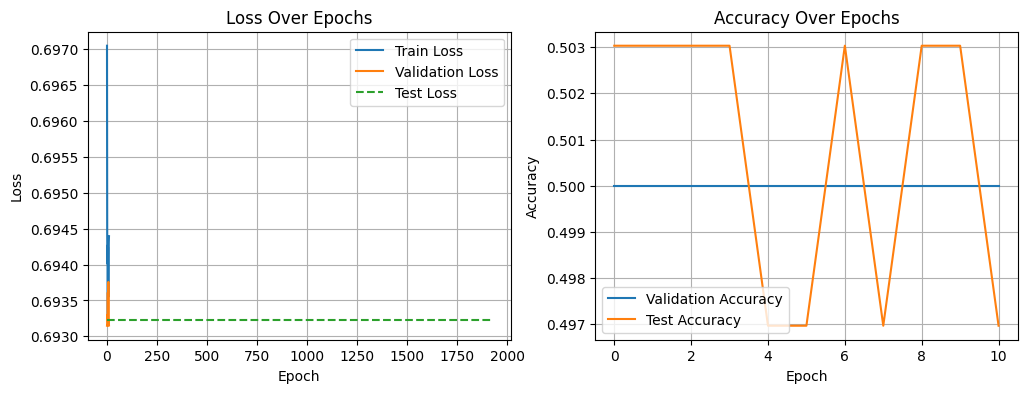

Hyperparameter Trials:  34%|███▍      | 34/100 [18:55<26:18, 23.92s/it]


🔁 Trial 35: hidden_dim=128, num_layers=2, lr=0.01, batch_size=8, dropout=0.1
Debug - Parameters: hidden_dim=128, num_layers=2, learning_rate=0.01, batch_size=8, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6968, Val Loss: 0.6945, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6945, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6936, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6935, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6937, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6937, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6937, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6939, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6931, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6934, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


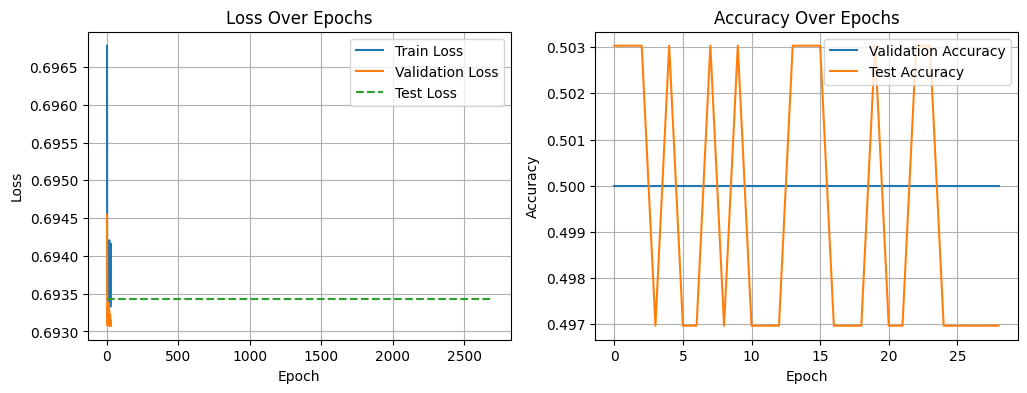

Hyperparameter Trials:  35%|███▌      | 35/100 [19:42<33:28, 30.90s/it]


🔁 Trial 36: hidden_dim=128, num_layers=2, lr=0.001, batch_size=64, dropout=0.3
Debug - Parameters: hidden_dim=128, num_layers=2, learning_rate=0.001, batch_size=64, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6943, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6936, Val Loss: 0.6906, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6872, Val Loss: 0.6848, Val Acc: 0.5610, Test Acc: 0.5818
Epoch [4/50], Train Loss: 0.6730, Val Loss: 0.6495, Val Acc: 0.7134, Test Acc: 0.7152
Epoch [5/50], Train Loss: 0.6199, Val Loss: 0.5494, Val Acc: 0.8720, Test Acc: 0.8848
Epoch [6/50], Train Loss: 0.4513, Val Loss: 0.3161, Val Acc: 0.9268, Test Acc: 0.9333
Epoch [7/50], Train Loss: 0.3715, Val Loss: 0.2957, Val Acc: 0.8902, Test Acc: 0.9152
Epoch [8/50], Train Loss: 0.2823, Val Loss: 0.1796, Val Acc: 0.9451, Test Acc: 0.9697
Epoch [9/50], Train Loss: 

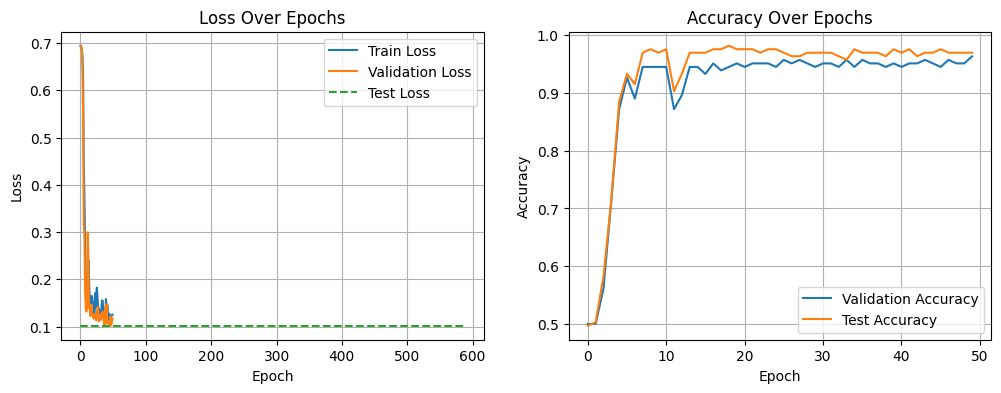

Hyperparameter Trials:  36%|███▌      | 36/100 [20:35<40:00, 37.50s/it]


🔁 Trial 37: hidden_dim=128, num_layers=2, lr=0.01, batch_size=8, dropout=0.3
Debug - Parameters: hidden_dim=128, num_layers=2, learning_rate=0.01, batch_size=8, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7082, Val Loss: 0.6942, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6928, Val Loss: 0.6964, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6958, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6940, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6938, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6941, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6944, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6935, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6931, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6938, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


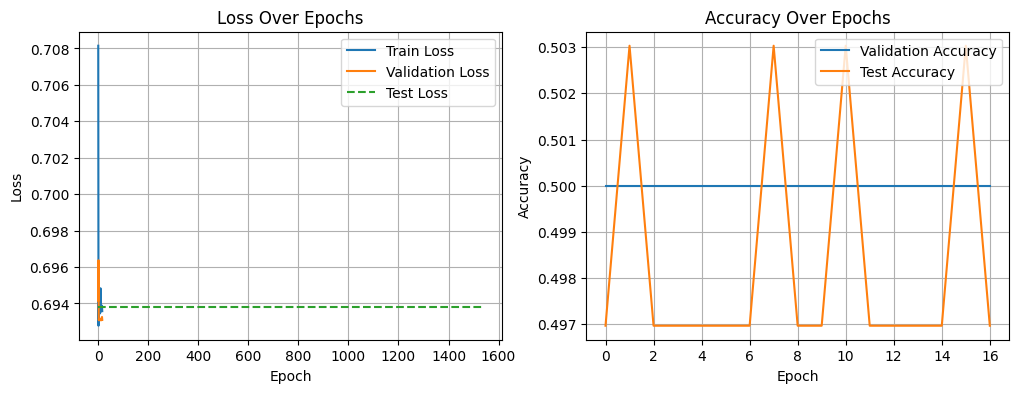

Hyperparameter Trials:  37%|███▋      | 37/100 [21:01<35:47, 34.08s/it]


🔁 Trial 38: hidden_dim=96, num_layers=3, lr=0.01, batch_size=16, dropout=0.2
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.01, batch_size=16, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6652, Val Loss: 0.5883, Val Acc: 0.6951, Test Acc: 0.7152
Epoch [2/50], Train Loss: 0.2465, Val Loss: 0.1558, Val Acc: 0.9390, Test Acc: 0.9455
Epoch [3/50], Train Loss: 0.1466, Val Loss: 0.0901, Val Acc: 0.9817, Test Acc: 0.9697
Epoch [4/50], Train Loss: 0.2122, Val Loss: 0.2648, Val Acc: 0.9268, Test Acc: 0.9333
Epoch [5/50], Train Loss: 0.1912, Val Loss: 0.0983, Val Acc: 0.9756, Test Acc: 0.9758
Epoch [6/50], Train Loss: 0.1669, Val Loss: 0.1110, Val Acc: 0.9695, Test Acc: 0.9697
Epoch [7/50], Train Loss: 0.1116, Val Loss: 0.0821, Val Acc: 0.9817, Test Acc: 0.9636
Epoch [8/50], Train Loss: 0.1050, Val Loss: 0.1001, Val Acc: 0.9695, Test Acc: 0.9758
Epoch [9/50], Train Loss: 0.10

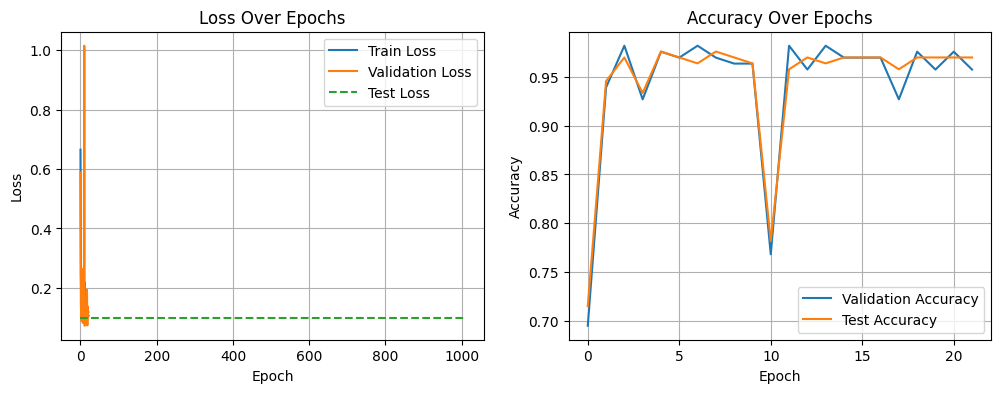

Hyperparameter Trials:  38%|███▊      | 38/100 [21:28<33:08, 32.07s/it]


🔁 Trial 39: hidden_dim=160, num_layers=3, lr=0.0001, batch_size=8, dropout=0.1
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.0001, batch_size=8, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6940, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6931, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6924, Val Loss: 0.6904, Val Acc: 0.5244, Test Acc: 0.5212
Epoch [4/50], Train Loss: 0.6877, Val Loss: 0.6825, Val Acc: 0.6037, Test Acc: 0.5212
Epoch [5/50], Train Loss: 0.6651, Val Loss: 0.6252, Val Acc: 0.7561, Test Acc: 0.8061
Epoch [6/50], Train Loss: 0.5509, Val Loss: 0.4656, Val Acc: 0.7622, Test Acc: 0.7697
Epoch [7/50], Train Loss: 0.2445, Val Loss: 0.2434, Val Acc: 0.9024, Test Acc: 0.9212
Epoch [8/50], Train Loss: 0.2334, Val Loss: 0.1524, Val Acc: 0.9451, Test Acc: 0.9636
Epoch [9/50], Train Loss: 

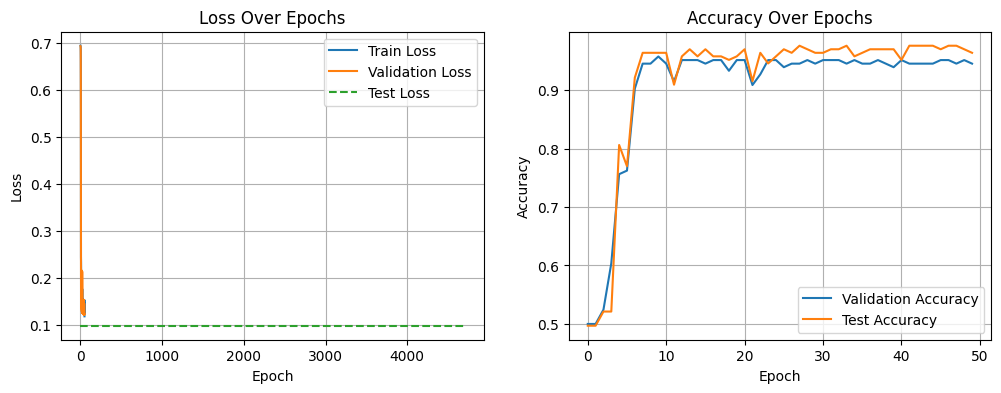

Hyperparameter Trials:  39%|███▉      | 39/100 [24:00<1:09:00, 67.87s/it]


🔁 Trial 40: hidden_dim=32, num_layers=3, lr=0.0001, batch_size=64, dropout=0.3
Debug - Parameters: hidden_dim=32, num_layers=3, learning_rate=0.0001, batch_size=64, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6974, Val Loss: 0.6981, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6966, Val Loss: 0.6978, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6961, Val Loss: 0.6975, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6959, Val Loss: 0.6972, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6953, Val Loss: 0.6970, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6952, Val Loss: 0.6967, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6955, Val Loss: 0.6965, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6950, Val Loss: 0.6962, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 

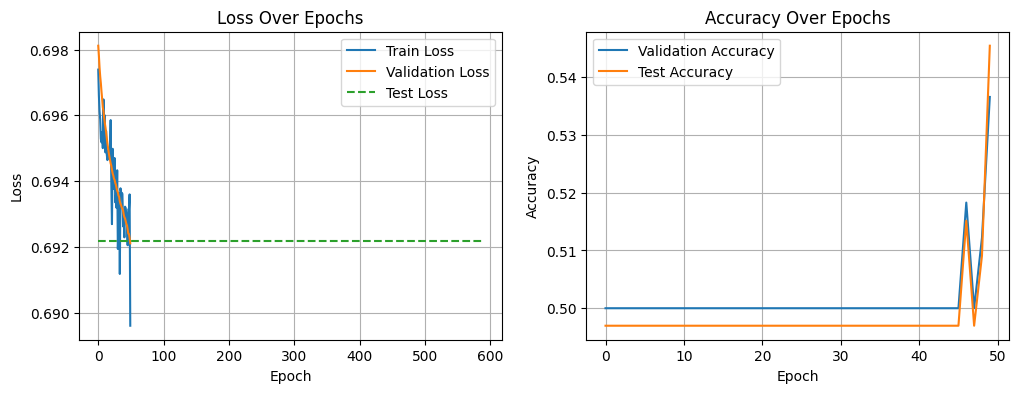

Hyperparameter Trials:  40%|████      | 40/100 [24:14<51:53, 51.89s/it]  


🔁 Trial 41: hidden_dim=64, num_layers=2, lr=0.0001, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.0001, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6964, Val Loss: 0.6946, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6940, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6935, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6933, Val Loss: 0.6911, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6906, Val Loss: 0.6896, Val Acc: 0.6220, Test Acc: 0.5515
Epoch [6/50], Train Loss: 0.6880, Val Loss: 0.6877, Val Acc: 0.5610, Test Acc: 0.5697
Epoch [7/50], Train Loss: 0.6874, Val Loss: 0.6856, Val Acc: 0.6098, Test Acc: 0.5515
Epoch [8/50], Train Loss: 0.6859, Val Loss: 0.6806, Val Acc: 0.6098, Test Acc: 0.5576
Epoch [9/50], Train Loss: 0.

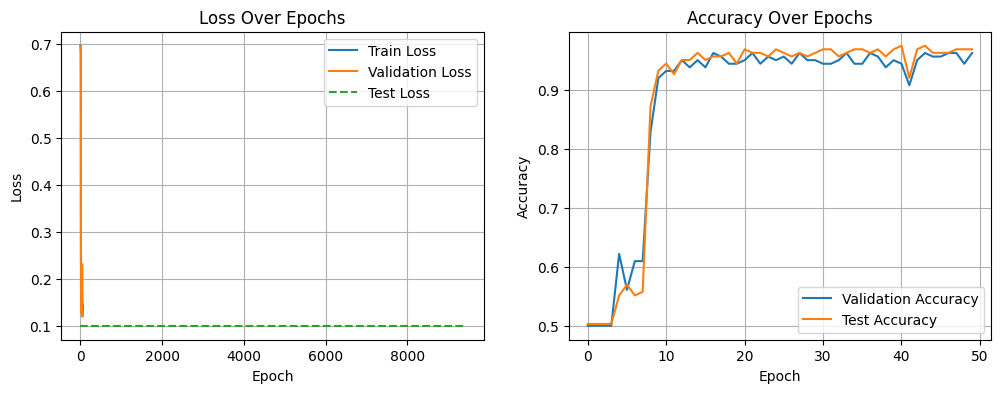

Hyperparameter Trials:  41%|████      | 41/100 [25:14<53:16, 54.18s/it]


🔁 Trial 42: hidden_dim=32, num_layers=2, lr=0.0001, batch_size=4, dropout=0.2
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.0001, batch_size=4, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7009, Val Loss: 0.7000, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6995, Val Loss: 0.6983, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6975, Val Loss: 0.6967, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6970, Val Loss: 0.6960, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6963, Val Loss: 0.6959, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6957, Val Loss: 0.6956, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6959, Val Loss: 0.6954, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6953, Val Loss: 0.6940, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.

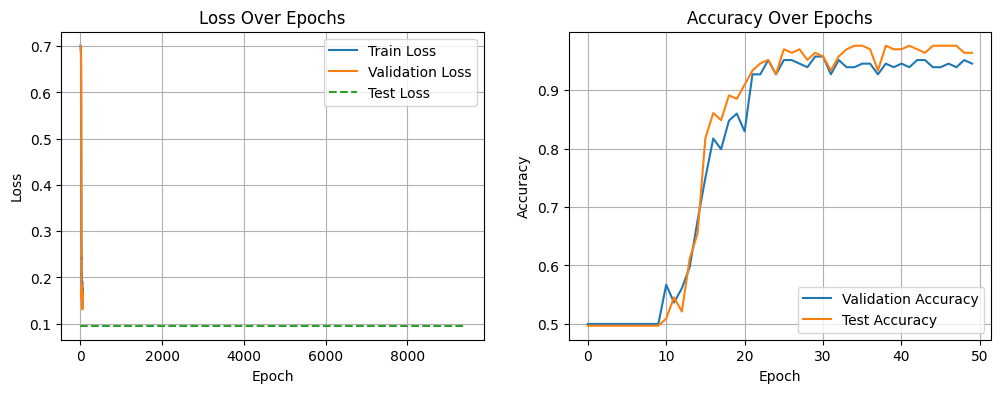

Hyperparameter Trials:  42%|████▏     | 42/100 [26:01<50:29, 52.24s/it]


🔁 Trial 43: hidden_dim=32, num_layers=2, lr=0.001, batch_size=32, dropout=0.1
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.001, batch_size=32, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6950, Val Loss: 0.6984, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6944, Val Loss: 0.6964, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6937, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6913, Val Loss: 0.6883, Val Acc: 0.5488, Test Acc: 0.5576
Epoch [5/50], Train Loss: 0.6881, Val Loss: 0.6809, Val Acc: 0.6280, Test Acc: 0.6000
Epoch [6/50], Train Loss: 0.6722, Val Loss: 0.6374, Val Acc: 0.8841, Test Acc: 0.9030
Epoch [7/50], Train Loss: 0.5939, Val Loss: 0.4856, Val Acc: 0.8476, Test Acc: 0.8727
Epoch [8/50], Train Loss: 0.4338, Val Loss: 0.2680, Val Acc: 0.9512, Test Acc: 0.9636
Epoch [9/50], Train Loss: 0.

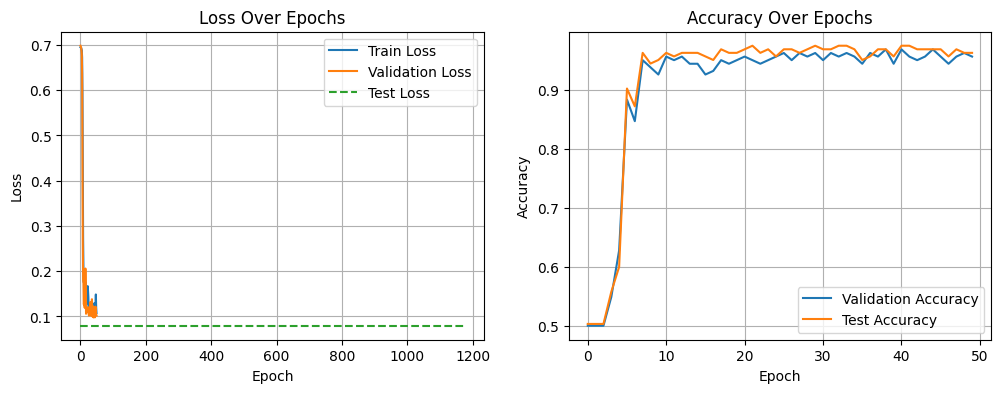

Hyperparameter Trials:  43%|████▎     | 43/100 [26:15<38:33, 40.58s/it]


🔁 Trial 44: hidden_dim=160, num_layers=2, lr=0.01, batch_size=64, dropout=0.3
Debug - Parameters: hidden_dim=160, num_layers=2, learning_rate=0.01, batch_size=64, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6983, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6960, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6934, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6934, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6933, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6932, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6932, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6932, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6930, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6932, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


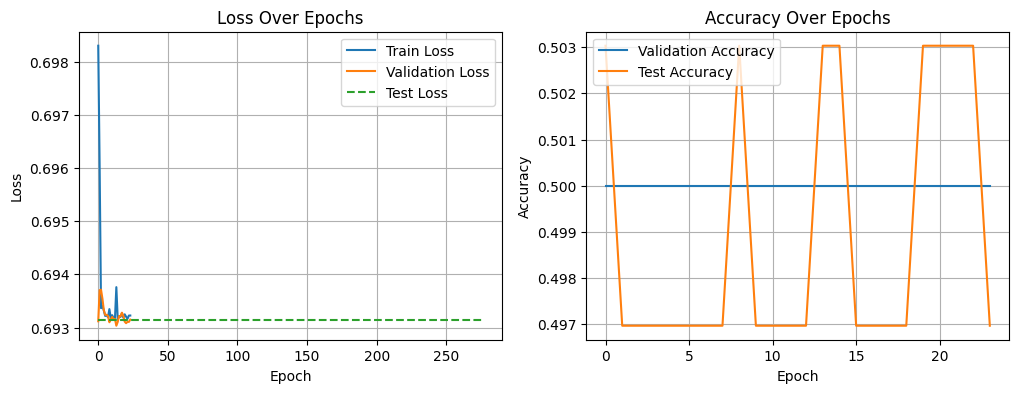

Hyperparameter Trials:  44%|████▍     | 44/100 [26:49<36:08, 38.73s/it]


🔁 Trial 45: hidden_dim=128, num_layers=2, lr=0.001, batch_size=32, dropout=0.1
Debug - Parameters: hidden_dim=128, num_layers=2, learning_rate=0.001, batch_size=32, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6925, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6897, Val Loss: 0.6819, Val Acc: 0.5061, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6493, Val Loss: 0.5235, Val Acc: 0.8659, Test Acc: 0.8909
Epoch [4/50], Train Loss: 0.3929, Val Loss: 0.3340, Val Acc: 0.8415, Test Acc: 0.8788
Epoch [5/50], Train Loss: 0.2288, Val Loss: 0.1307, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [6/50], Train Loss: 0.1397, Val Loss: 0.1116, Val Acc: 0.9573, Test Acc: 0.9697
Epoch [7/50], Train Loss: 0.1691, Val Loss: 0.1255, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1503, Val Loss: 0.1267, Val Acc: 0.9390, Test Acc: 0.9758
Epoch [9/50], Train Loss: 

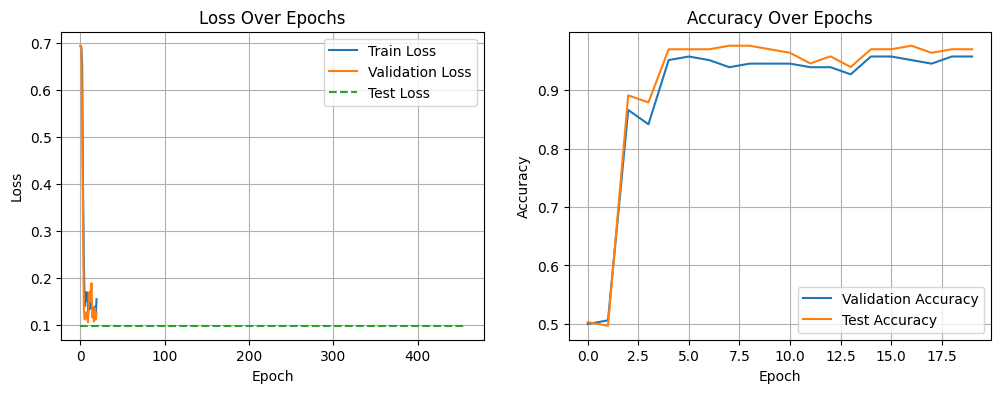

Hyperparameter Trials:  45%|████▌     | 45/100 [27:10<30:32, 33.32s/it]


🔁 Trial 46: hidden_dim=32, num_layers=2, lr=0.01, batch_size=32, dropout=0.2
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.01, batch_size=32, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6957, Val Loss: 0.6957, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6875, Val Loss: 0.6412, Val Acc: 0.8354, Test Acc: 0.8970
Epoch [3/50], Train Loss: 0.4786, Val Loss: 0.2205, Val Acc: 0.8902, Test Acc: 0.9091
Epoch [4/50], Train Loss: 0.3037, Val Loss: 0.1827, Val Acc: 0.9207, Test Acc: 0.9576
Epoch [5/50], Train Loss: 0.2190, Val Loss: 0.3076, Val Acc: 0.8963, Test Acc: 0.9273
Epoch [6/50], Train Loss: 0.1676, Val Loss: 0.0948, Val Acc: 0.9634, Test Acc: 0.9697
Epoch [7/50], Train Loss: 0.1144, Val Loss: 0.0982, Val Acc: 0.9634, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1275, Val Loss: 0.0896, Val Acc: 0.9695, Test Acc: 0.9576
Epoch [9/50], Train Loss: 0.12

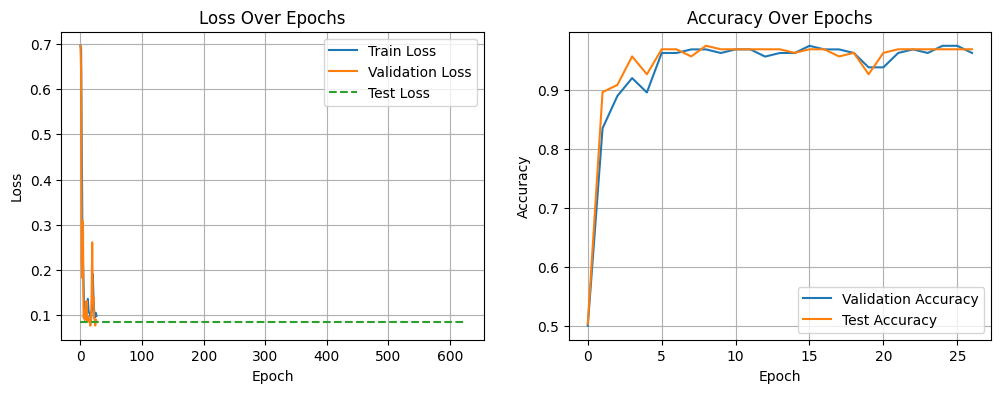

Hyperparameter Trials:  46%|████▌     | 46/100 [27:17<23:02, 25.61s/it]


🔁 Trial 47: hidden_dim=128, num_layers=3, lr=0.001, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=128, num_layers=3, learning_rate=0.001, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6973, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.7014, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6966, Val Loss: 0.6946, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6959, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6942, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6944, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6946, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6932, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6914, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6934, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


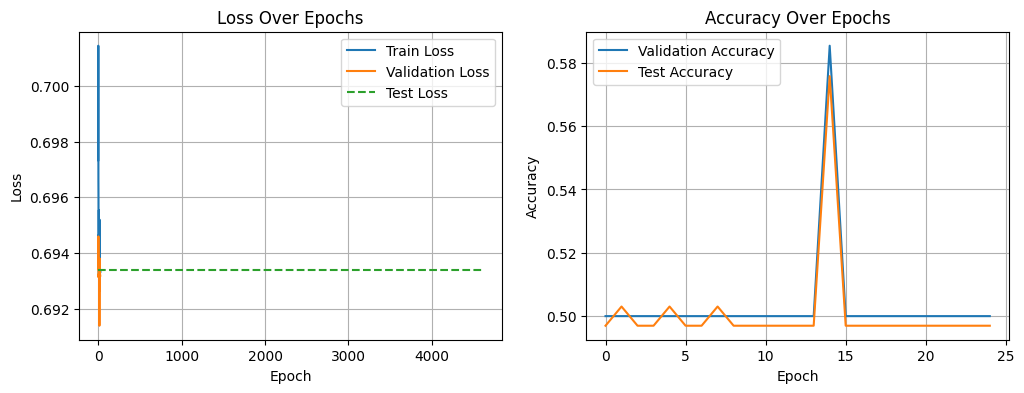

Hyperparameter Trials:  47%|████▋     | 47/100 [28:33<35:52, 40.61s/it]


🔁 Trial 48: hidden_dim=32, num_layers=2, lr=0.001, batch_size=16, dropout=0.1
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.001, batch_size=16, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6947, Val Loss: 0.6920, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6906, Val Loss: 0.6860, Val Acc: 0.5915, Test Acc: 0.6000
Epoch [3/50], Train Loss: 0.6634, Val Loss: 0.5485, Val Acc: 0.9207, Test Acc: 0.9333
Epoch [4/50], Train Loss: 0.3546, Val Loss: 0.1793, Val Acc: 0.9634, Test Acc: 0.9576
Epoch [5/50], Train Loss: 0.2300, Val Loss: 0.3988, Val Acc: 0.7866, Test Acc: 0.8545
Epoch [6/50], Train Loss: 0.2340, Val Loss: 0.1624, Val Acc: 0.9390, Test Acc: 0.9515
Epoch [7/50], Train Loss: 0.1643, Val Loss: 0.1272, Val Acc: 0.9451, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1366, Val Loss: 0.2328, Val Acc: 0.9146, Test Acc: 0.9394
Epoch [9/50], Train Loss: 0.

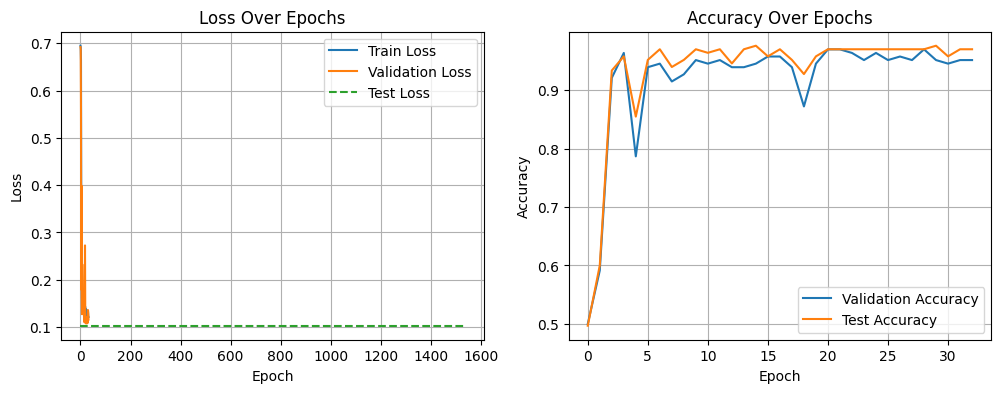

Hyperparameter Trials:  48%|████▊     | 48/100 [28:45<27:51, 32.14s/it]


🔁 Trial 49: hidden_dim=64, num_layers=2, lr=0.0001, batch_size=64, dropout=0.2
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.0001, batch_size=64, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6947, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6944, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6942, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6942, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6936, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6938, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6936, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6930, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 

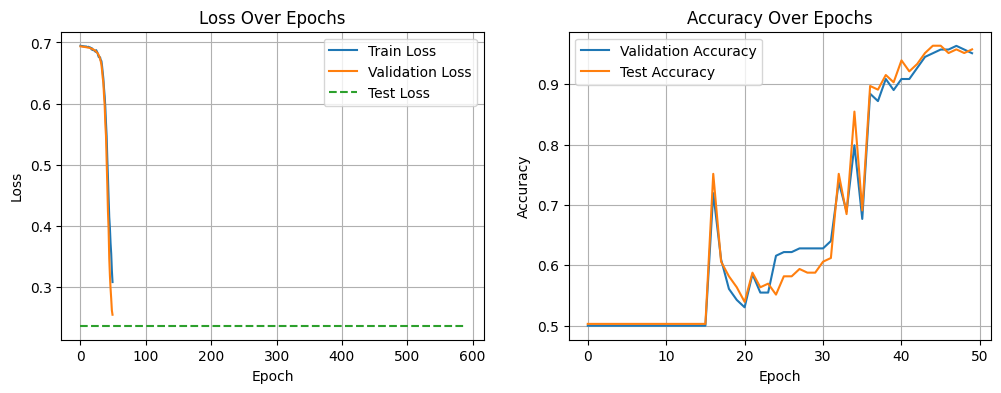

Hyperparameter Trials:  49%|████▉     | 49/100 [29:06<24:25, 28.74s/it]


🔁 Trial 50: hidden_dim=64, num_layers=3, lr=0.0001, batch_size=16, dropout=0.2
Debug - Parameters: hidden_dim=64, num_layers=3, learning_rate=0.0001, batch_size=16, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6933, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6937, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6934, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6933, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6935, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6937, Val Loss: 0.6927, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6925, Val Loss: 0.6922, Val Acc: 0.6037, Test Acc: 0.6061
Epoch [8/50], Train Loss: 0.6921, Val Loss: 0.6914, Val Acc: 0.5305, Test Acc: 0.5273
Epoch [9/50], Train Loss: 

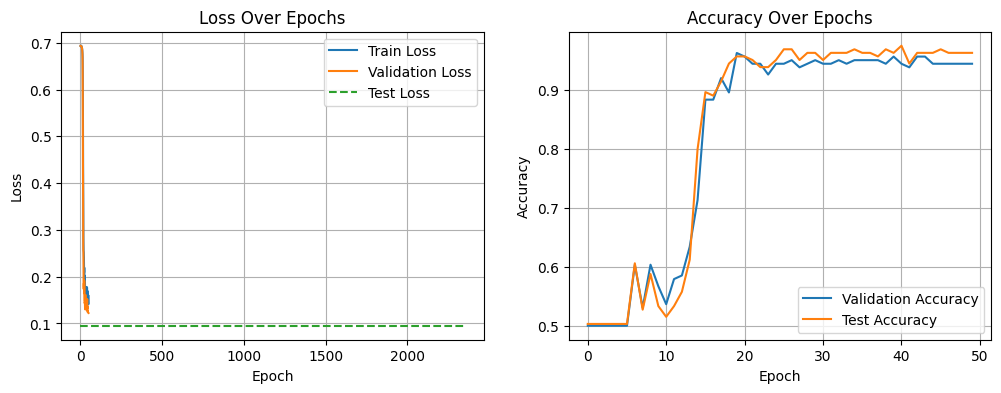

Hyperparameter Trials:  50%|█████     | 50/100 [29:47<26:56, 32.33s/it]


🔁 Trial 51: hidden_dim=64, num_layers=2, lr=0.001, batch_size=64, dropout=0.1
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.001, batch_size=64, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6972, Val Loss: 0.6943, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6931, Val Loss: 0.6912, Val Acc: 0.5244, Test Acc: 0.5152
Epoch [3/50], Train Loss: 0.6954, Val Loss: 0.6906, Val Acc: 0.5732, Test Acc: 0.6061
Epoch [4/50], Train Loss: 0.6925, Val Loss: 0.6921, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6925, Val Loss: 0.6915, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6923, Val Loss: 0.6891, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6878, Val Loss: 0.6848, Val Acc: 0.6159, Test Acc: 0.6061
Epoch [8/50], Train Loss: 0.6777, Val Loss: 0.6623, Val Acc: 0.6463, Test Acc: 0.6182
Epoch [9/50], Train Loss: 0.

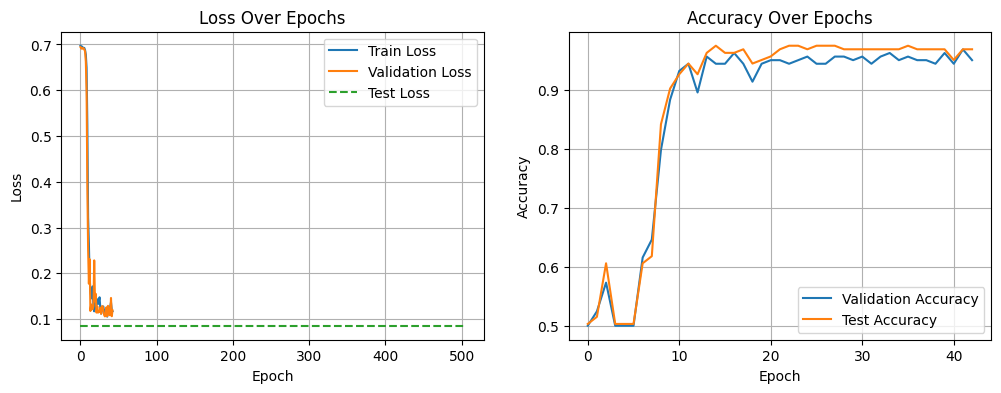

Hyperparameter Trials:  51%|█████     | 51/100 [30:04<22:42, 27.80s/it]


🔁 Trial 52: hidden_dim=32, num_layers=2, lr=0.0001, batch_size=8, dropout=0.1
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.0001, batch_size=8, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6980, Val Loss: 0.6982, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6966, Val Loss: 0.6973, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6959, Val Loss: 0.6962, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6953, Val Loss: 0.6952, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6936, Val Loss: 0.6940, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6931, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6924, Val Loss: 0.6912, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6902, Val Loss: 0.6888, Val Acc: 0.6037, Test Acc: 0.6061
Epoch [9/50], Train Loss: 0.

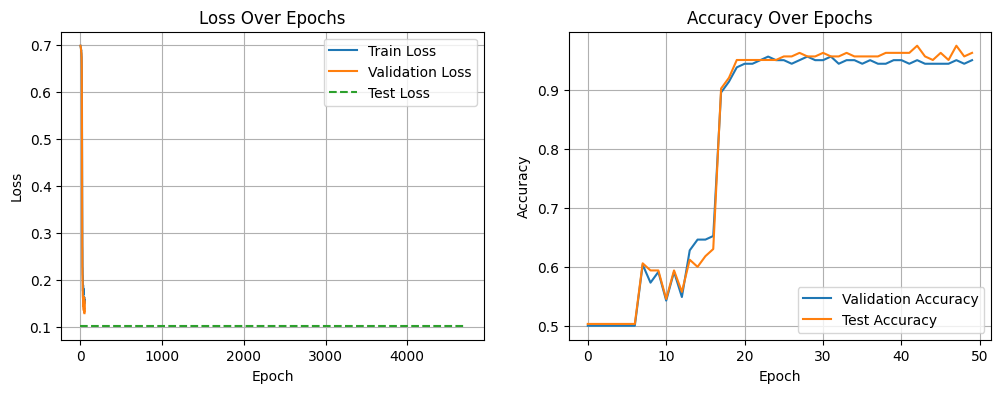

Hyperparameter Trials:  52%|█████▏    | 52/100 [30:34<22:42, 28.38s/it]


🔁 Trial 53: hidden_dim=128, num_layers=3, lr=0.001, batch_size=8, dropout=0.2
Debug - Parameters: hidden_dim=128, num_layers=3, learning_rate=0.001, batch_size=8, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6977, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6934, Val Loss: 0.6887, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6962, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6939, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6936, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6931, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6936, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6937, Val Loss: 0.6921, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6887, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6985, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


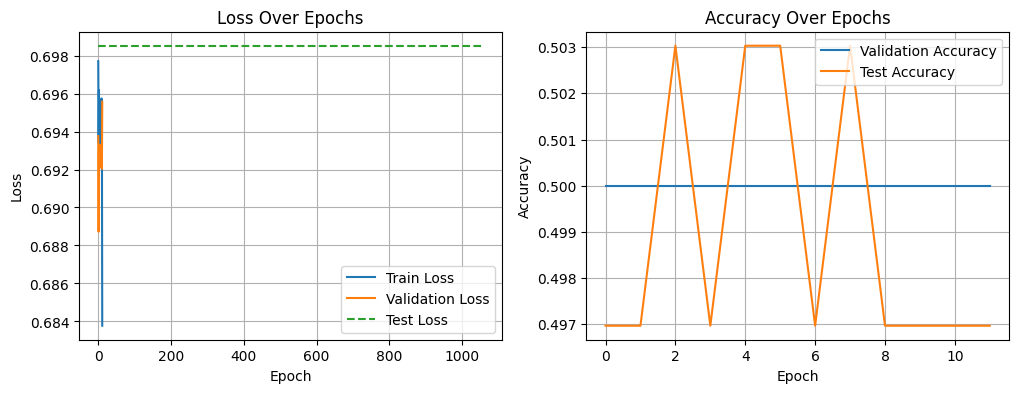

Hyperparameter Trials:  53%|█████▎    | 53/100 [31:02<22:11, 28.32s/it]


🔁 Trial 54: hidden_dim=32, num_layers=2, lr=0.001, batch_size=4, dropout=0.2
Debug - Parameters: hidden_dim=32, num_layers=2, learning_rate=0.001, batch_size=4, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6959, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6852, Val Loss: 0.6121, Val Acc: 0.6220, Test Acc: 0.6242
Epoch [3/50], Train Loss: 0.3635, Val Loss: 0.1393, Val Acc: 0.9451, Test Acc: 0.9697
Epoch [4/50], Train Loss: 0.2133, Val Loss: 0.1338, Val Acc: 0.9573, Test Acc: 0.9758
Epoch [5/50], Train Loss: 0.1958, Val Loss: 0.1271, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [6/50], Train Loss: 0.1579, Val Loss: 0.2424, Val Acc: 0.9024, Test Acc: 0.9152
Epoch [7/50], Train Loss: 0.1468, Val Loss: 0.1358, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1455, Val Loss: 0.1147, Val Acc: 0.9695, Test Acc: 0.9697
Epoch [9/50], Train Loss: 0.14

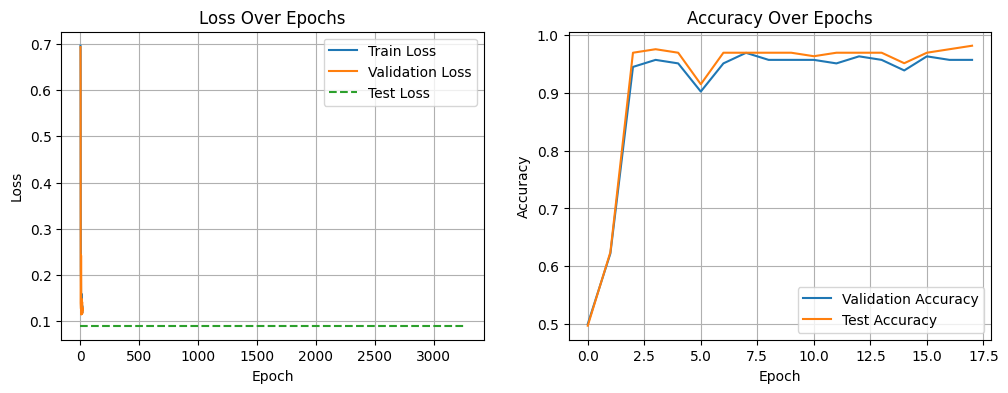

Hyperparameter Trials:  54%|█████▍    | 54/100 [31:20<19:23, 25.30s/it]


🔁 Trial 55: hidden_dim=96, num_layers=3, lr=0.001, batch_size=32, dropout=0.3
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.001, batch_size=32, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6975, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6921, Val Loss: 0.6875, Val Acc: 0.5610, Test Acc: 0.5818
Epoch [3/50], Train Loss: 0.6898, Val Loss: 0.6827, Val Acc: 0.7256, Test Acc: 0.7091
Epoch [4/50], Train Loss: 0.6492, Val Loss: 0.5100, Val Acc: 0.9573, Test Acc: 0.9273
Epoch [5/50], Train Loss: 0.4043, Val Loss: 0.1828, Val Acc: 0.9512, Test Acc: 0.9515
Epoch [6/50], Train Loss: 0.2225, Val Loss: 0.1352, Val Acc: 0.9390, Test Acc: 0.9576
Epoch [7/50], Train Loss: 0.2426, Val Loss: 0.1342, Val Acc: 0.9573, Test Acc: 0.9636
Epoch [8/50], Train Loss: 0.1728, Val Loss: 0.1292, Val Acc: 0.9451, Test Acc: 0.9636
Epoch [9/50], Train Loss: 0.

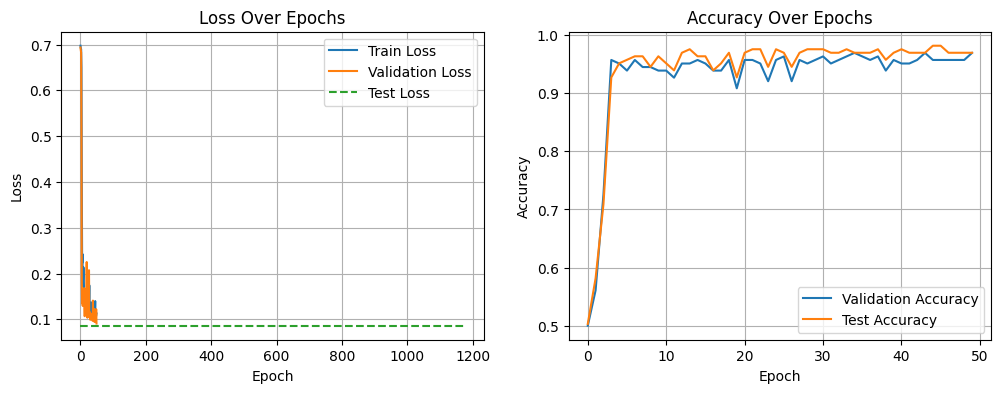

Hyperparameter Trials:  55%|█████▌    | 55/100 [32:14<25:16, 33.71s/it]


🔁 Trial 56: hidden_dim=160, num_layers=3, lr=0.0001, batch_size=8, dropout=0.2
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.0001, batch_size=8, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6939, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6929, Val Loss: 0.6925, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6930, Val Loss: 0.6914, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6894, Val Loss: 0.6901, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6884, Val Loss: 0.6846, Val Acc: 0.6280, Test Acc: 0.5576
Epoch [6/50], Train Loss: 0.6805, Val Loss: 0.6708, Val Acc: 0.8415, Test Acc: 0.9030
Epoch [7/50], Train Loss: 0.5856, Val Loss: 0.4132, Val Acc: 0.8049, Test Acc: 0.8485
Epoch [8/50], Train Loss: 0.2918, Val Loss: 0.1721, Val Acc: 0.9634, Test Acc: 0.9636
Epoch [9/50], Train Loss: 

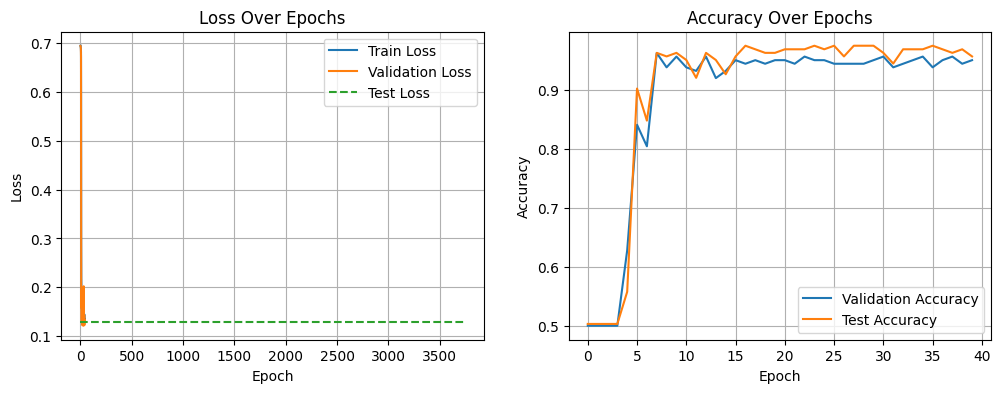

Hyperparameter Trials:  56%|█████▌    | 56/100 [34:18<44:35, 60.82s/it]


🔁 Trial 57: hidden_dim=64, num_layers=2, lr=0.01, batch_size=64, dropout=0.1
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.01, batch_size=64, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6954, Val Loss: 0.6923, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6876, Val Loss: 0.6631, Val Acc: 0.7927, Test Acc: 0.8000
Epoch [3/50], Train Loss: 0.5482, Val Loss: 0.4522, Val Acc: 0.7683, Test Acc: 0.8000
Epoch [4/50], Train Loss: 0.4287, Val Loss: 0.2654, Val Acc: 0.8841, Test Acc: 0.8909
Epoch [5/50], Train Loss: 0.3800, Val Loss: 0.2951, Val Acc: 0.9146, Test Acc: 0.9333
Epoch [6/50], Train Loss: 0.1897, Val Loss: 0.1051, Val Acc: 0.9634, Test Acc: 0.9697
Epoch [7/50], Train Loss: 0.1368, Val Loss: 0.1007, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1032, Val Loss: 0.0976, Val Acc: 0.9573, Test Acc: 0.9758
Epoch [9/50], Train Loss: 0.10

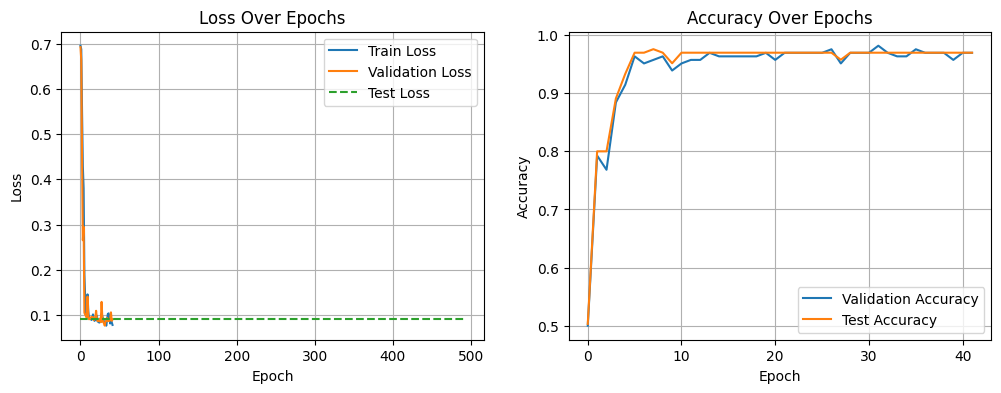

Hyperparameter Trials:  57%|█████▋    | 57/100 [34:35<34:07, 47.61s/it]


🔁 Trial 58: hidden_dim=96, num_layers=2, lr=0.0001, batch_size=64, dropout=0.2
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.0001, batch_size=64, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6938, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6938, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6934, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6937, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6935, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6933, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6931, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6929, Val Loss: 0.6927, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 

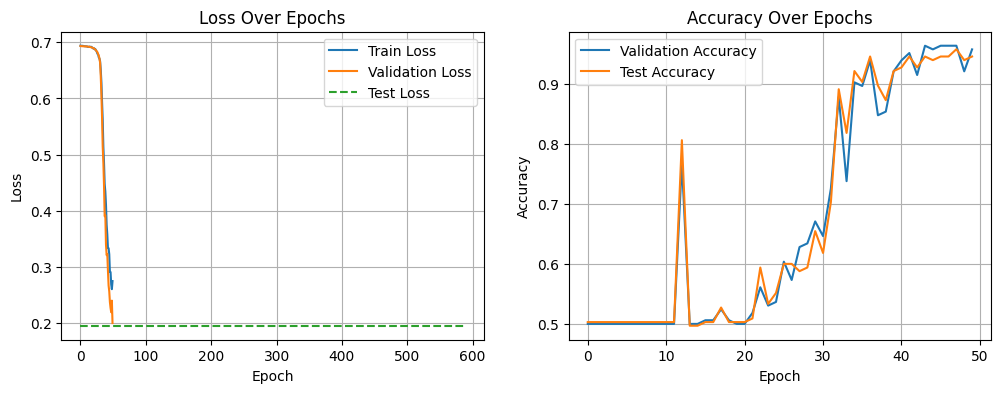

Hyperparameter Trials:  58%|█████▊    | 58/100 [35:07<30:05, 42.98s/it]


🔁 Trial 59: hidden_dim=160, num_layers=2, lr=0.0001, batch_size=64, dropout=0.1
Debug - Parameters: hidden_dim=160, num_layers=2, learning_rate=0.0001, batch_size=64, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6952, Val Loss: 0.6958, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6950, Val Loss: 0.6954, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6945, Val Loss: 0.6950, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6943, Val Loss: 0.6946, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6936, Val Loss: 0.6942, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6931, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6933, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6924, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss

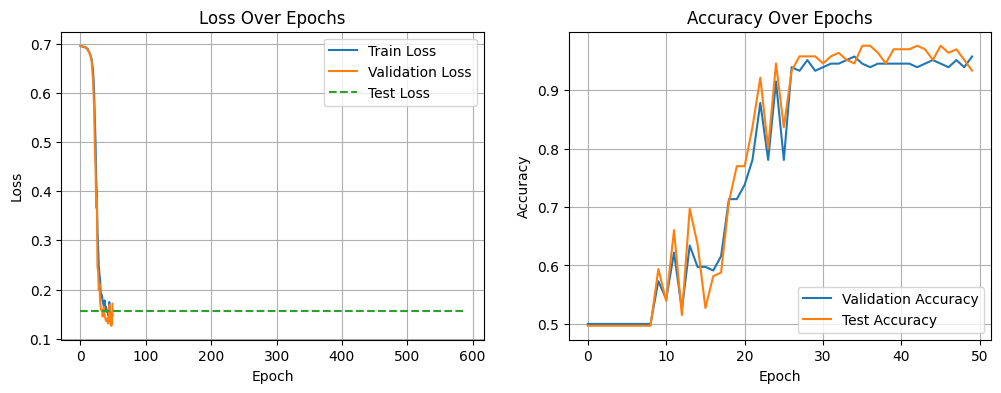

Hyperparameter Trials:  59%|█████▉    | 59/100 [36:17<34:51, 51.01s/it]


🔁 Trial 60: hidden_dim=64, num_layers=2, lr=0.01, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.01, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6998, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6946, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6972, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6966, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6948, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6941, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6942, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6938, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.6940

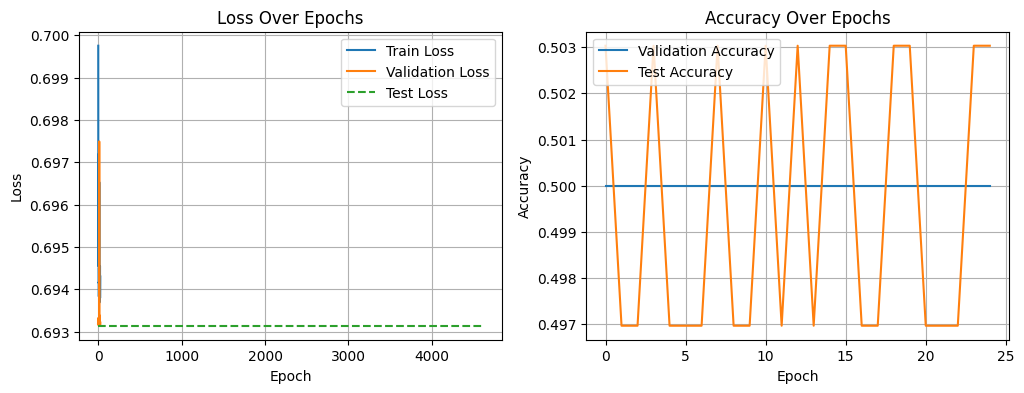

Hyperparameter Trials:  60%|██████    | 60/100 [36:48<30:04, 45.12s/it]


🔁 Trial 61: hidden_dim=64, num_layers=3, lr=0.0001, batch_size=64, dropout=0.1
Debug - Parameters: hidden_dim=64, num_layers=3, learning_rate=0.0001, batch_size=64, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6957, Val Loss: 0.6945, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6956, Val Loss: 0.6941, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6954, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6953, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6943, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6946, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6943, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6929, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 

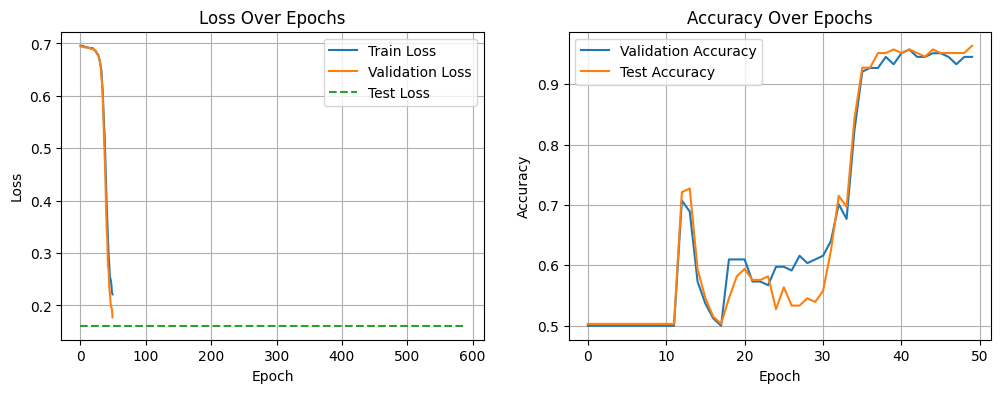

Hyperparameter Trials:  61%|██████    | 61/100 [37:17<26:13, 40.36s/it]


🔁 Trial 62: hidden_dim=160, num_layers=2, lr=0.01, batch_size=4, dropout=0.2
Debug - Parameters: hidden_dim=160, num_layers=2, learning_rate=0.01, batch_size=4, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7059, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6940, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6941, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6940, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6939, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6943, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6939, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6950, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.69

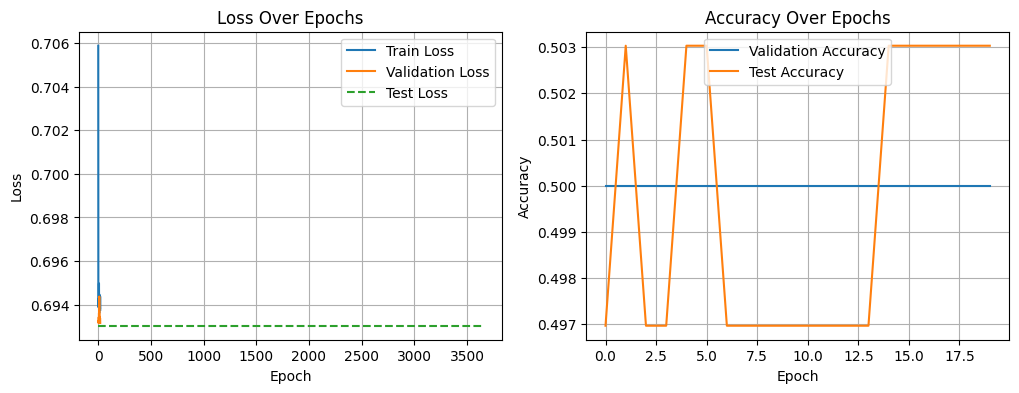

Hyperparameter Trials:  62%|██████▏   | 62/100 [38:30<31:41, 50.03s/it]


🔁 Trial 63: hidden_dim=160, num_layers=3, lr=0.001, batch_size=8, dropout=0.3
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.001, batch_size=8, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6942, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6986, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6954, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6939, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6941, Val Loss: 0.6940, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6935, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6934, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6935, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.

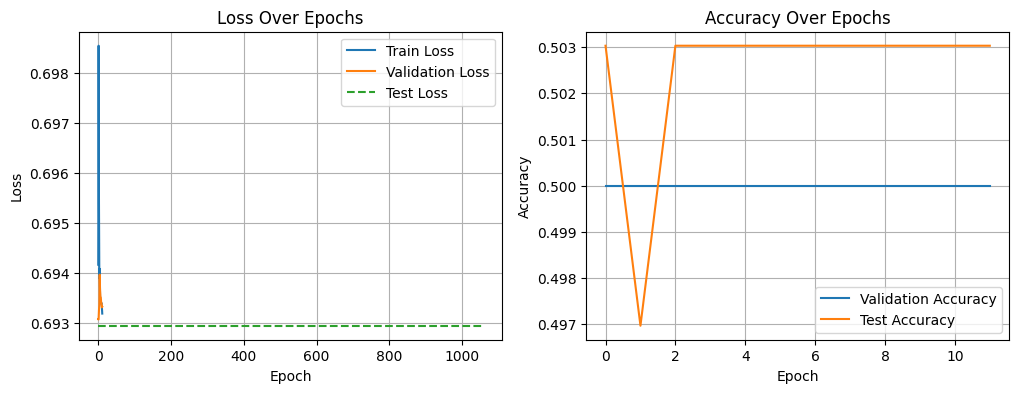

Hyperparameter Trials:  63%|██████▎   | 63/100 [39:08<28:43, 46.57s/it]


🔁 Trial 64: hidden_dim=96, num_layers=2, lr=0.001, batch_size=32, dropout=0.1
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.001, batch_size=32, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6940, Val Loss: 0.6902, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6926, Val Loss: 0.6861, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6811, Val Loss: 0.6379, Val Acc: 0.6463, Test Acc: 0.6485
Epoch [4/50], Train Loss: 0.4615, Val Loss: 0.2756, Val Acc: 0.8598, Test Acc: 0.8909
Epoch [5/50], Train Loss: 0.2147, Val Loss: 0.2182, Val Acc: 0.9085, Test Acc: 0.9333
Epoch [6/50], Train Loss: 0.1494, Val Loss: 0.3184, Val Acc: 0.8232, Test Acc: 0.8667
Epoch [7/50], Train Loss: 0.2067, Val Loss: 0.1271, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1459, Val Loss: 0.1171, Val Acc: 0.9512, Test Acc: 0.9636
Epoch [9/50], Train Loss: 0.

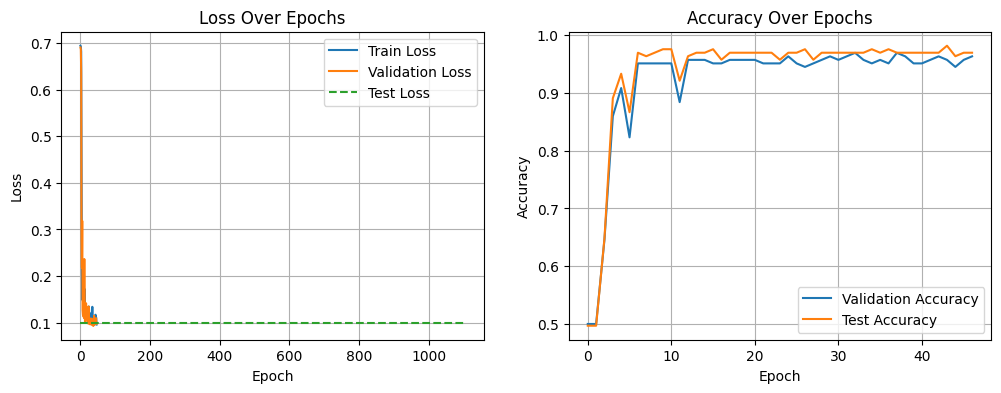

Hyperparameter Trials:  64%|██████▍   | 64/100 [39:42<25:39, 42.75s/it]


🔁 Trial 65: hidden_dim=96, num_layers=3, lr=0.001, batch_size=4, dropout=0.1
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.001, batch_size=4, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6959, Val Loss: 0.6927, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.5248, Val Loss: 0.1470, Val Acc: 0.9512, Test Acc: 0.9758
Epoch [3/50], Train Loss: 0.1799, Val Loss: 0.1533, Val Acc: 0.9390, Test Acc: 0.9758
Epoch [4/50], Train Loss: 0.1678, Val Loss: 0.1212, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [5/50], Train Loss: 0.1474, Val Loss: 0.1161, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [6/50], Train Loss: 0.1550, Val Loss: 0.1144, Val Acc: 0.9634, Test Acc: 0.9818
Epoch [7/50], Train Loss: 0.1636, Val Loss: 0.1299, Val Acc: 0.9634, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1542, Val Loss: 0.1524, Val Acc: 0.9390, Test Acc: 0.9636
Epoch [9/50], Train Loss: 0.12

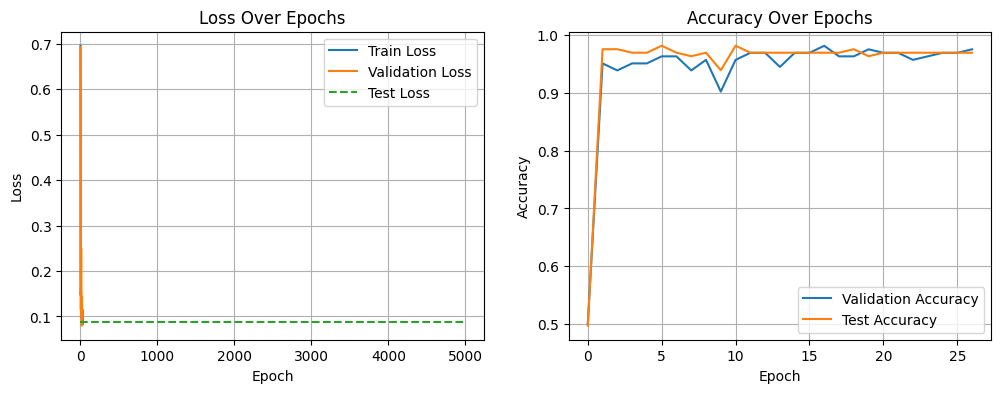

Hyperparameter Trials:  65%|██████▌   | 65/100 [40:45<28:27, 48.80s/it]


🔁 Trial 66: hidden_dim=128, num_layers=2, lr=0.0001, batch_size=64, dropout=0.1
Debug - Parameters: hidden_dim=128, num_layers=2, learning_rate=0.0001, batch_size=64, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6996, Val Loss: 0.7009, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6987, Val Loss: 0.7000, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6980, Val Loss: 0.6991, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6974, Val Loss: 0.6984, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6967, Val Loss: 0.6977, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6958, Val Loss: 0.6968, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6953, Val Loss: 0.6958, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6943, Val Loss: 0.6947, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss

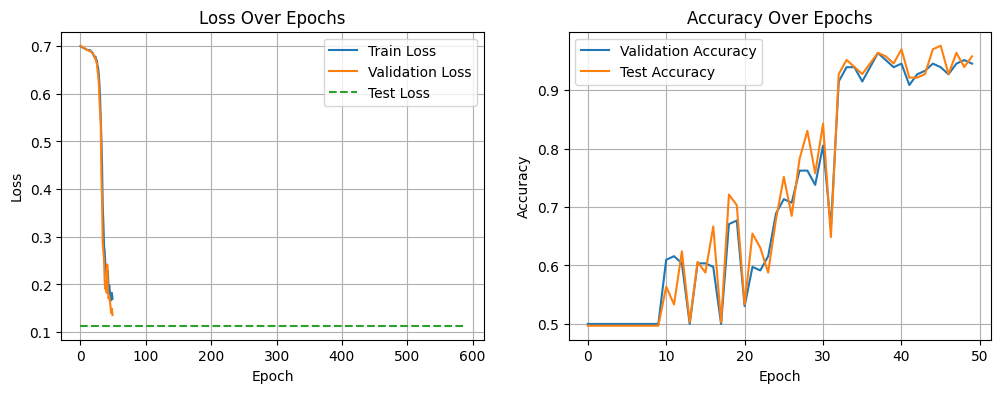

Hyperparameter Trials:  66%|██████▌   | 66/100 [41:38<28:19, 49.99s/it]


🔁 Trial 67: hidden_dim=160, num_layers=3, lr=0.0001, batch_size=16, dropout=0.1
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.0001, batch_size=16, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6946, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6945, Val Loss: 0.6925, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6938, Val Loss: 0.6923, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6940, Val Loss: 0.6920, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6926, Val Loss: 0.6910, Val Acc: 0.5549, Test Acc: 0.5212
Epoch [6/50], Train Loss: 0.6903, Val Loss: 0.6888, Val Acc: 0.5610, Test Acc: 0.5091
Epoch [7/50], Train Loss: 0.6845, Val Loss: 0.7113, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6877, Val Loss: 0.6813, Val Acc: 0.6341, Test Acc: 0.6061
Epoch [9/50], Train Loss

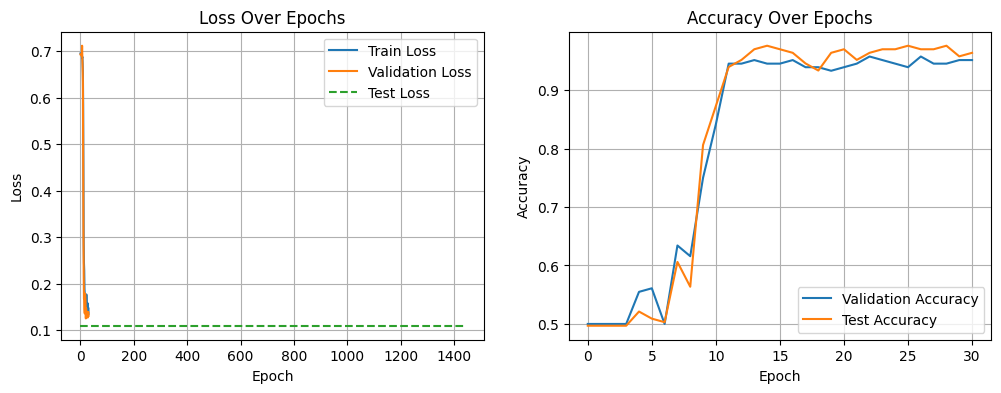

Hyperparameter Trials:  67%|██████▋   | 67/100 [42:53<31:40, 57.60s/it]


🔁 Trial 68: hidden_dim=64, num_layers=3, lr=0.001, batch_size=8, dropout=0.2
Debug - Parameters: hidden_dim=64, num_layers=3, learning_rate=0.001, batch_size=8, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6943, Val Loss: 0.6922, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6908, Val Loss: 0.6839, Val Acc: 0.5610, Test Acc: 0.5333
Epoch [3/50], Train Loss: 0.4980, Val Loss: 0.2816, Val Acc: 0.8963, Test Acc: 0.9091
Epoch [4/50], Train Loss: 0.2251, Val Loss: 0.4381, Val Acc: 0.7744, Test Acc: 0.8364
Epoch [5/50], Train Loss: 0.1737, Val Loss: 0.1234, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [6/50], Train Loss: 0.1832, Val Loss: 0.2834, Val Acc: 0.8963, Test Acc: 0.9273
Epoch [7/50], Train Loss: 0.1673, Val Loss: 0.1564, Val Acc: 0.9451, Test Acc: 0.9515
Epoch [8/50], Train Loss: 0.1532, Val Loss: 0.1140, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [9/50], Train Loss: 0.12

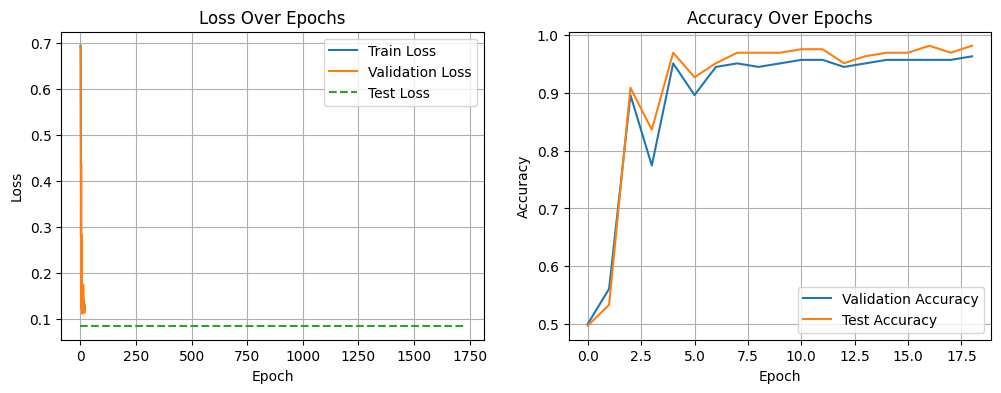

Hyperparameter Trials:  68%|██████▊   | 68/100 [43:15<25:03, 46.99s/it]


🔁 Trial 69: hidden_dim=160, num_layers=3, lr=0.01, batch_size=64, dropout=0.1
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.01, batch_size=64, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6902, Val Loss: 0.7546, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6966, Val Loss: 0.7174, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.7054, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6971, Val Loss: 0.6961, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6929, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6952, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6956, Val Loss: 0.6939, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6929, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.

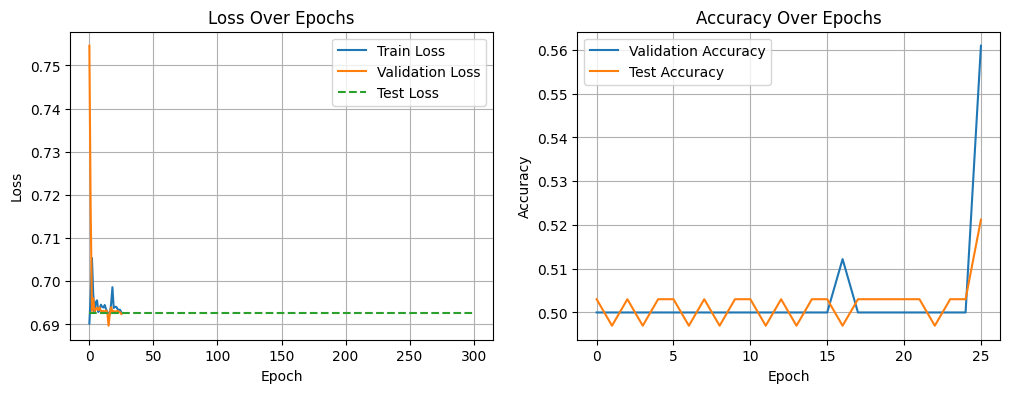

Hyperparameter Trials:  69%|██████▉   | 69/100 [44:13<25:57, 50.25s/it]


🔁 Trial 70: hidden_dim=160, num_layers=3, lr=0.01, batch_size=4, dropout=0.1
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.01, batch_size=4, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7003, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6938, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6940, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6944, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6937, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6940, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6939, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6944, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6931, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6934, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


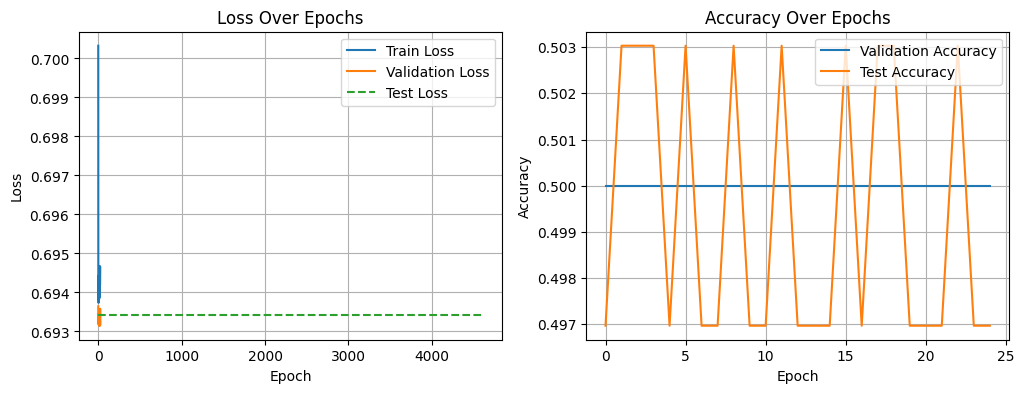

Hyperparameter Trials:  70%|███████   | 70/100 [46:30<38:05, 76.19s/it]


🔁 Trial 71: hidden_dim=96, num_layers=2, lr=0.0001, batch_size=64, dropout=0.1
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.0001, batch_size=64, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6995, Val Loss: 0.7012, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6993, Val Loss: 0.7008, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6987, Val Loss: 0.7002, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6981, Val Loss: 0.6996, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6980, Val Loss: 0.6990, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6975, Val Loss: 0.6985, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6966, Val Loss: 0.6980, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6965, Val Loss: 0.6974, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 

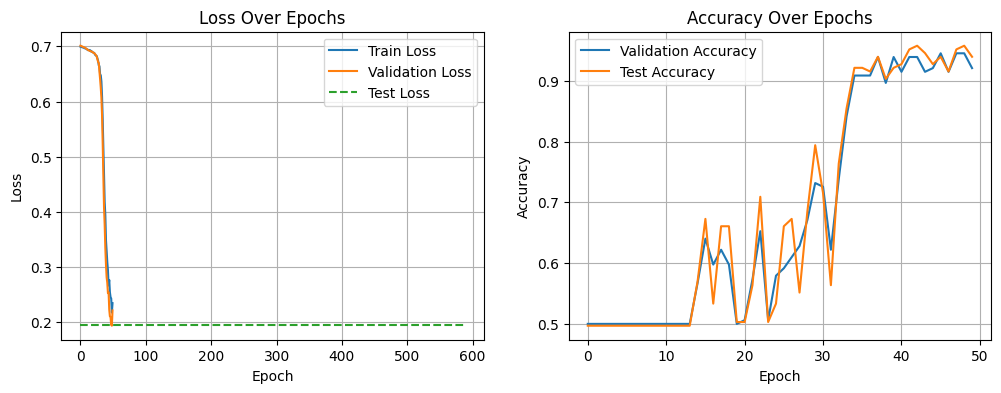

Hyperparameter Trials:  71%|███████   | 71/100 [47:02<30:22, 62.84s/it]


🔁 Trial 72: hidden_dim=96, num_layers=3, lr=0.01, batch_size=8, dropout=0.3
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.01, batch_size=8, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7015, Val Loss: 0.6950, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6960, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6943, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6942, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6936, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6945, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6950, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6940, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.6937

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6931, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6933, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


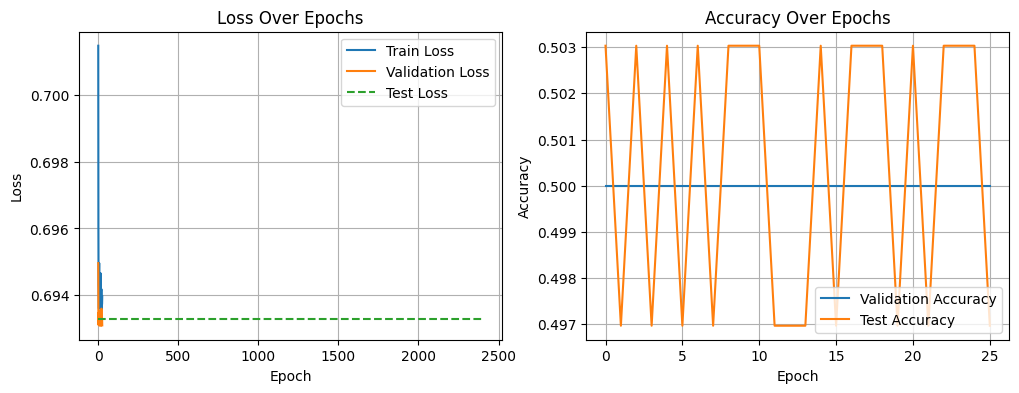

Hyperparameter Trials:  72%|███████▏  | 72/100 [47:44<26:31, 56.83s/it]


🔁 Trial 73: hidden_dim=96, num_layers=2, lr=0.01, batch_size=16, dropout=0.3
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.01, batch_size=16, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7033, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6946, Val Loss: 0.6946, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6945, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6943, Val Loss: 0.6939, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6940, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6934, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6934, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6934, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


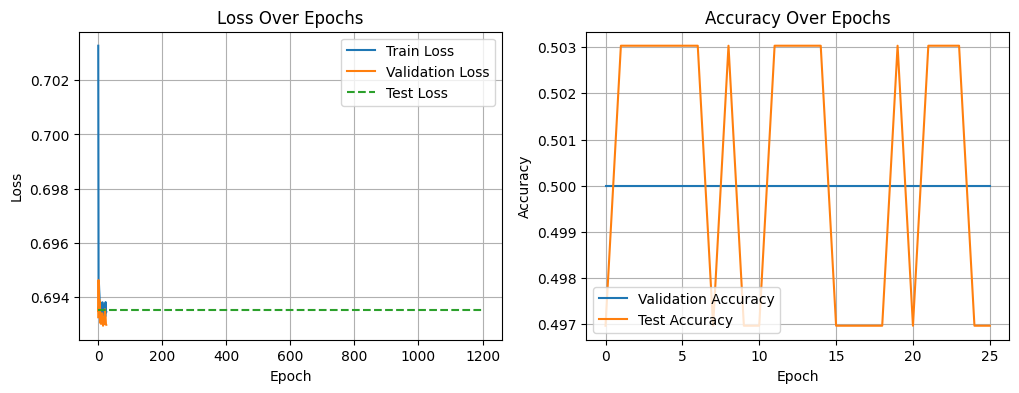

Hyperparameter Trials:  73%|███████▎  | 73/100 [48:08<21:02, 46.75s/it]


🔁 Trial 74: hidden_dim=128, num_layers=3, lr=0.0001, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=128, num_layers=3, learning_rate=0.0001, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6954, Val Loss: 0.6943, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6945, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6930, Val Loss: 0.6919, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6923, Val Loss: 0.6910, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6894, Val Loss: 0.6870, Val Acc: 0.5488, Test Acc: 0.5515
Epoch [6/50], Train Loss: 0.6852, Val Loss: 0.6863, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6803, Val Loss: 0.6618, Val Acc: 0.6646, Test Acc: 0.6242
Epoch [8/50], Train Loss: 0.5457, Val Loss: 0.2747, Val Acc: 0.9329, Test Acc: 0.9515
Epoch [9/50], Train Loss: 

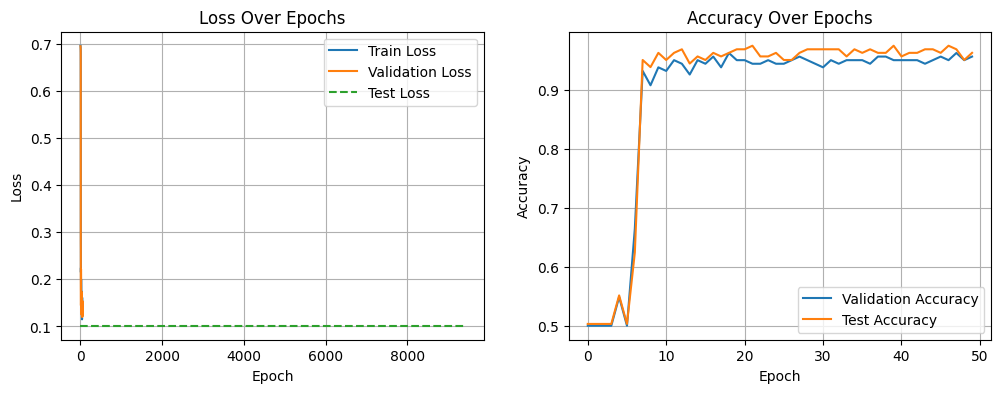

Hyperparameter Trials:  74%|███████▍  | 74/100 [50:40<34:00, 78.49s/it]


🔁 Trial 75: hidden_dim=128, num_layers=3, lr=0.0001, batch_size=4, dropout=0.2
Debug - Parameters: hidden_dim=128, num_layers=3, learning_rate=0.0001, batch_size=4, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6944, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6932, Val Loss: 0.6913, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6891, Val Loss: 0.6878, Val Acc: 0.5122, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6844, Val Loss: 0.6806, Val Acc: 0.5976, Test Acc: 0.6182
Epoch [5/50], Train Loss: 0.6665, Val Loss: 0.6293, Val Acc: 0.6829, Test Acc: 0.7212
Epoch [6/50], Train Loss: 0.4224, Val Loss: 0.2234, Val Acc: 0.9329, Test Acc: 0.9394
Epoch [7/50], Train Loss: 0.2299, Val Loss: 0.1893, Val Acc: 0.9390, Test Acc: 0.9515
Epoch [8/50], Train Loss: 0.2148, Val Loss: 0.1472, Val Acc: 0.9451, Test Acc: 0.9576
Epoch [9/50], Train Loss: 

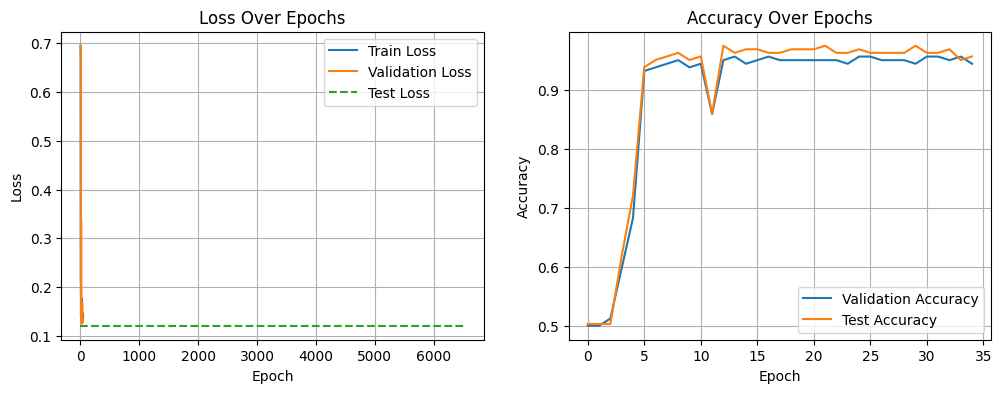

Hyperparameter Trials:  75%|███████▌  | 75/100 [52:27<36:17, 87.09s/it]


🔁 Trial 76: hidden_dim=64, num_layers=3, lr=0.0001, batch_size=32, dropout=0.3
Debug - Parameters: hidden_dim=64, num_layers=3, learning_rate=0.0001, batch_size=32, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6975, Val Loss: 0.6906, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6966, Val Loss: 0.6905, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6961, Val Loss: 0.6905, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6963, Val Loss: 0.6904, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6953, Val Loss: 0.6905, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6957, Val Loss: 0.6905, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6939, Val Loss: 0.6905, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6950, Val Loss: 0.6907, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 

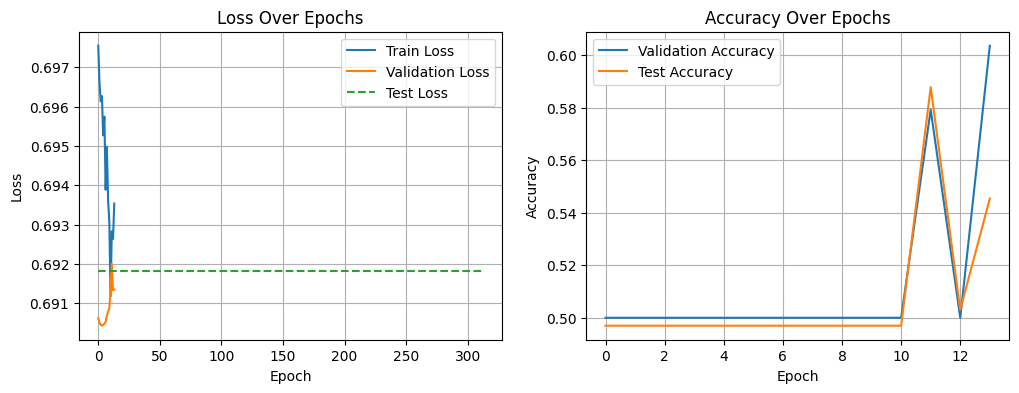

Hyperparameter Trials:  76%|███████▌  | 76/100 [52:37<25:32, 63.85s/it]


🔁 Trial 77: hidden_dim=128, num_layers=2, lr=0.0001, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=128, num_layers=2, learning_rate=0.0001, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6973, Val Loss: 0.6952, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6921, Val Loss: 0.6908, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6904, Val Loss: 0.6888, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6904, Val Loss: 0.6864, Val Acc: 0.6646, Test Acc: 0.6848
Epoch [5/50], Train Loss: 0.6862, Val Loss: 0.6856, Val Acc: 0.5122, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6797, Val Loss: 0.6824, Val Acc: 0.5183, Test Acc: 0.5152
Epoch [7/50], Train Loss: 0.6807, Val Loss: 0.6700, Val Acc: 0.8110, Test Acc: 0.8182
Epoch [8/50], Train Loss: 0.6522, Val Loss: 0.5790, Val Acc: 0.8659, Test Acc: 0.8909
Epoch [9/50], Train Loss: 

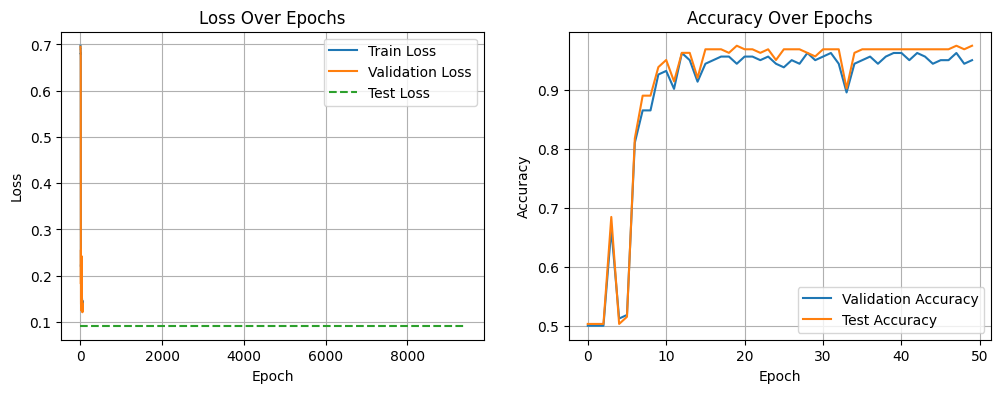

Hyperparameter Trials:  77%|███████▋  | 77/100 [54:28<29:52, 77.94s/it]


🔁 Trial 78: hidden_dim=64, num_layers=2, lr=0.001, batch_size=64, dropout=0.3
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.001, batch_size=64, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6942, Val Loss: 0.6939, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6932, Val Loss: 0.6929, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6931, Val Loss: 0.6924, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6923, Val Loss: 0.6905, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6884, Val Loss: 0.6884, Val Acc: 0.5366, Test Acc: 0.5333
Epoch [6/50], Train Loss: 0.6795, Val Loss: 0.6687, Val Acc: 0.6220, Test Acc: 0.5939
Epoch [7/50], Train Loss: 0.6612, Val Loss: 0.6187, Val Acc: 0.7683, Test Acc: 0.7879
Epoch [8/50], Train Loss: 0.5707, Val Loss: 0.3750, Val Acc: 0.9207, Test Acc: 0.9394
Epoch [9/50], Train Loss: 0.

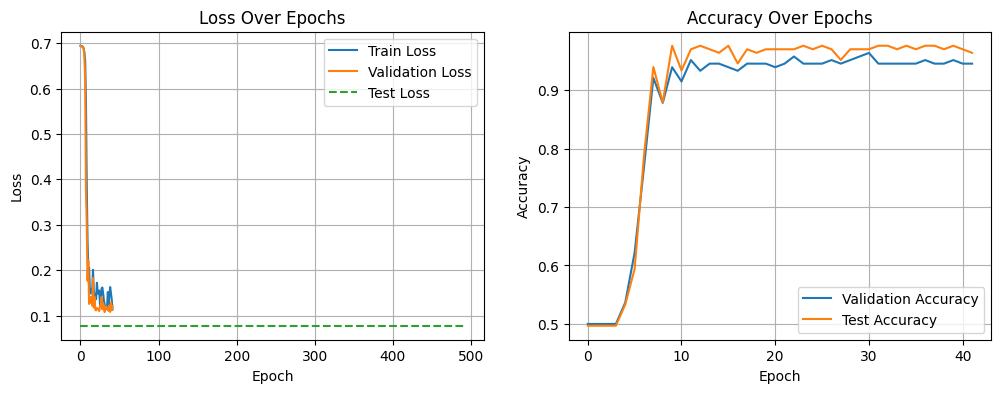

Hyperparameter Trials:  78%|███████▊  | 78/100 [54:46<22:00, 60.02s/it]

✅ New Best Model at Trial 78 with Test Loss = 0.0777
✅ New Best Model at Trial 78 with Test Loss = 0.0777

🔁 Trial 79: hidden_dim=64, num_layers=3, lr=0.0001, batch_size=4, dropout=0.2
Debug - Parameters: hidden_dim=64, num_layers=3, learning_rate=0.0001, batch_size=4, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6946, Val Loss: 0.6942, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6941, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6935, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6923, Val Loss: 0.6924, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6923, Val Loss: 0.6914, Val Acc: 0.6037, Test Acc: 0.6303
Epoch [6/50], Train Loss: 0.6909, Val Loss: 0.6886, Val Acc: 0.5671, Test Acc: 0.5697
Epoch [7/50], Train Loss: 0.6863, Val Loss: 0.6837, Val Acc: 0.5976, Test Acc: 0.5152
Epoch [8

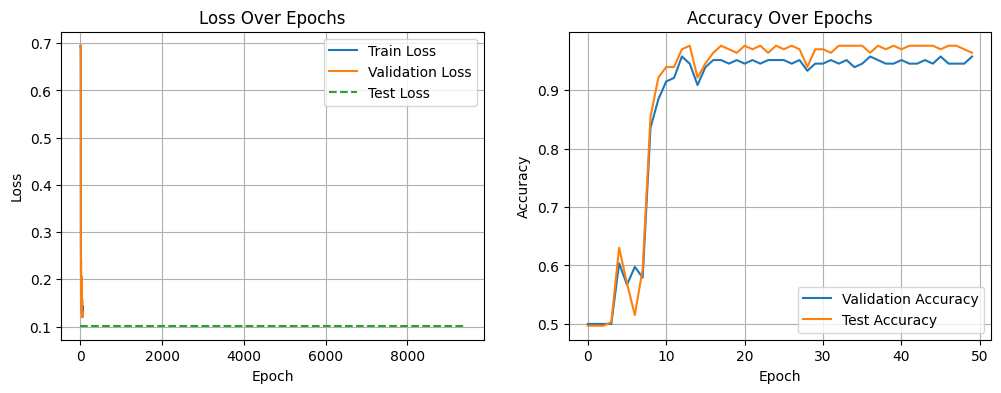

Hyperparameter Trials:  79%|███████▉  | 79/100 [56:12<23:45, 67.87s/it]


🔁 Trial 80: hidden_dim=96, num_layers=2, lr=0.001, batch_size=8, dropout=0.3
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.001, batch_size=8, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6962, Val Loss: 0.6919, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6895, Val Loss: 0.6712, Val Acc: 0.6463, Test Acc: 0.6909
Epoch [3/50], Train Loss: 0.5083, Val Loss: 0.2513, Val Acc: 0.9573, Test Acc: 0.9636
Epoch [4/50], Train Loss: 0.2363, Val Loss: 0.1753, Val Acc: 0.9390, Test Acc: 0.9697
Epoch [5/50], Train Loss: 0.1768, Val Loss: 0.1407, Val Acc: 0.9390, Test Acc: 0.9758
Epoch [6/50], Train Loss: 0.1603, Val Loss: 0.1412, Val Acc: 0.9451, Test Acc: 0.9636
Epoch [7/50], Train Loss: 0.1517, Val Loss: 0.1389, Val Acc: 0.9451, Test Acc: 0.9758
Epoch [8/50], Train Loss: 0.1710, Val Loss: 0.1122, Val Acc: 0.9573, Test Acc: 0.9758
Epoch [9/50], Train Loss: 0.15

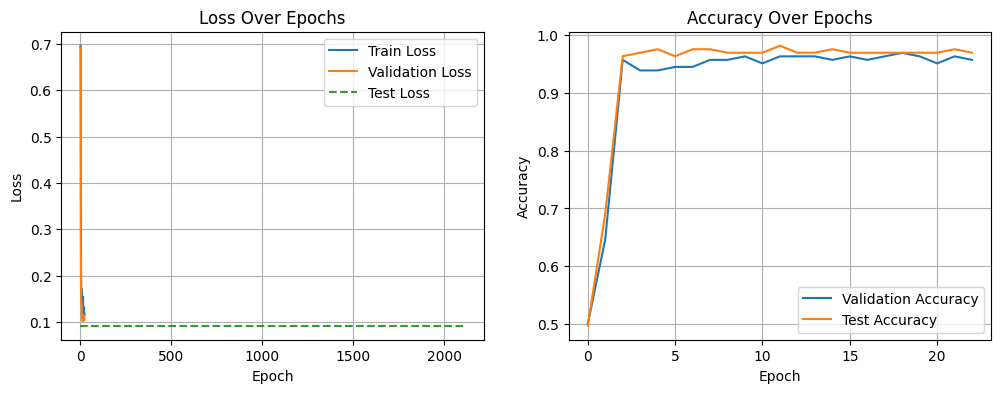

Hyperparameter Trials:  80%|████████  | 80/100 [56:39<18:33, 55.66s/it]


🔁 Trial 81: hidden_dim=64, num_layers=2, lr=0.001, batch_size=64, dropout=0.2
Debug - Parameters: hidden_dim=64, num_layers=2, learning_rate=0.001, batch_size=64, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6965, Val Loss: 0.6959, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6951, Val Loss: 0.6939, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6934, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6916, Val Loss: 0.6910, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6903, Val Loss: 0.6886, Val Acc: 0.6159, Test Acc: 0.5758
Epoch [6/50], Train Loss: 0.6836, Val Loss: 0.6798, Val Acc: 0.6402, Test Acc: 0.6788
Epoch [7/50], Train Loss: 0.6767, Val Loss: 0.6717, Val Acc: 0.6402, Test Acc: 0.6242
Epoch [8/50], Train Loss: 0.6555, Val Loss: 0.6193, Val Acc: 0.8354, Test Acc: 0.8788
Epoch [9/50], Train Loss: 0.

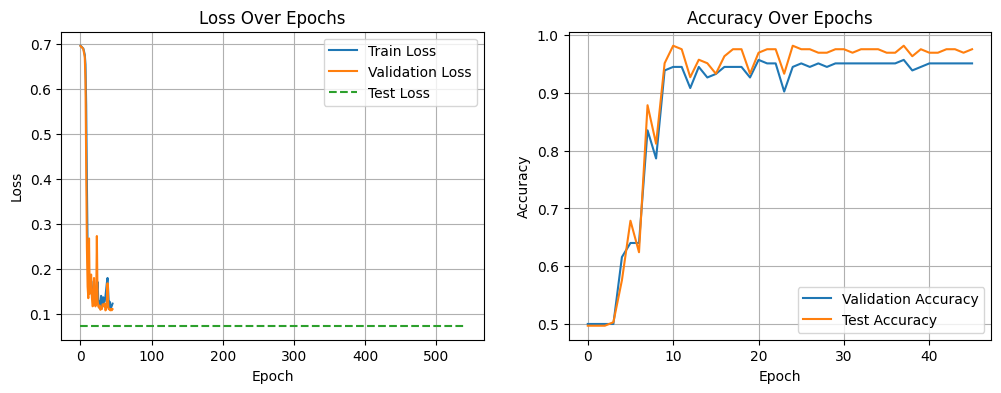

Hyperparameter Trials:  81%|████████  | 81/100 [56:58<14:06, 44.55s/it]

✅ New Best Model at Trial 81 with Test Loss = 0.0742
✅ New Best Model at Trial 81 with Test Loss = 0.0742

🔁 Trial 82: hidden_dim=160, num_layers=2, lr=0.0001, batch_size=8, dropout=0.1
Debug - Parameters: hidden_dim=160, num_layers=2, learning_rate=0.0001, batch_size=8, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6977, Val Loss: 0.6948, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6949, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6936, Val Loss: 0.6915, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6923, Val Loss: 0.6894, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6868, Val Loss: 0.6856, Val Acc: 0.6280, Test Acc: 0.5515
Epoch [6/50], Train Loss: 0.6809, Val Loss: 0.6761, Val Acc: 0.7012, Test Acc: 0.6848
Epoch [7/50], Train Loss: 0.6688, Val Loss: 0.6464, Val Acc: 0.5671, Test Acc: 0.5455
Epoch 

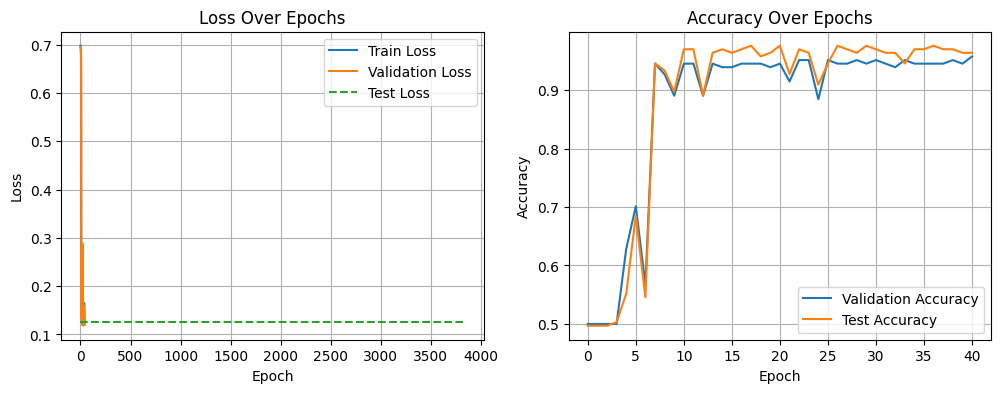

Hyperparameter Trials:  82%|████████▏ | 82/100 [58:24<17:03, 56.88s/it]


🔁 Trial 83: hidden_dim=128, num_layers=2, lr=0.0001, batch_size=16, dropout=0.2
Debug - Parameters: hidden_dim=128, num_layers=2, learning_rate=0.0001, batch_size=16, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6992, Val Loss: 0.6949, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6980, Val Loss: 0.6937, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6957, Val Loss: 0.6922, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6952, Val Loss: 0.6914, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6925, Val Loss: 0.6907, Val Acc: 0.6341, Test Acc: 0.6667
Epoch [6/50], Train Loss: 0.6883, Val Loss: 0.6899, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6896, Val Loss: 0.6877, Val Acc: 0.5488, Test Acc: 0.5697
Epoch [8/50], Train Loss: 0.6867, Val Loss: 0.6854, Val Acc: 0.6829, Test Acc: 0.6909
Epoch [9/50], Train Loss

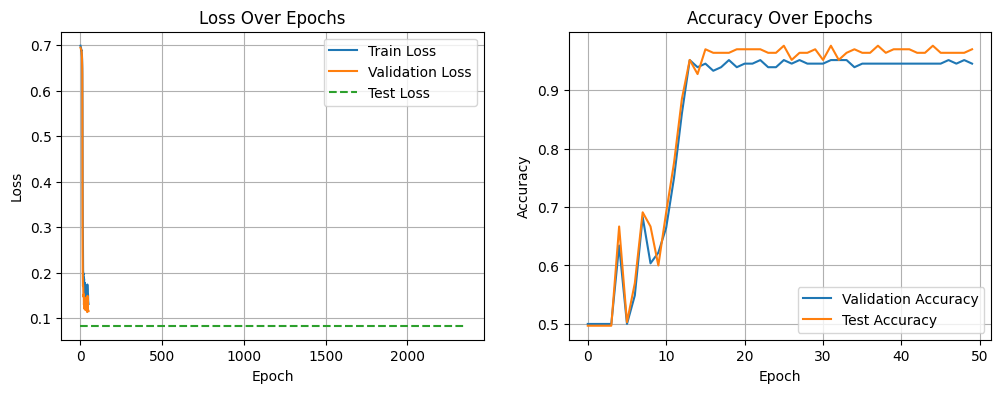

Hyperparameter Trials:  83%|████████▎ | 83/100 [59:27<16:39, 58.80s/it]


🔁 Trial 84: hidden_dim=64, num_layers=3, lr=0.0001, batch_size=4, dropout=0.2
Debug - Parameters: hidden_dim=64, num_layers=3, learning_rate=0.0001, batch_size=4, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6966, Val Loss: 0.6953, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6944, Val Loss: 0.6941, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6943, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6934, Val Loss: 0.6921, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6904, Val Loss: 0.6898, Val Acc: 0.6037, Test Acc: 0.5515
Epoch [6/50], Train Loss: 0.6885, Val Loss: 0.6891, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6854, Val Loss: 0.6814, Val Acc: 0.5549, Test Acc: 0.5758
Epoch [8/50], Train Loss: 0.6791, Val Loss: 0.6736, Val Acc: 0.5976, Test Acc: 0.5333
Epoch [9/50], Train Loss: 0.

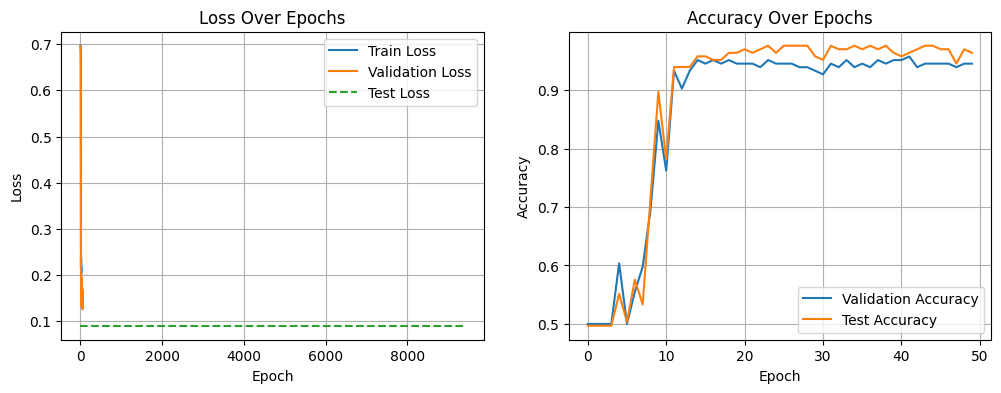

Hyperparameter Trials:  84%|████████▍ | 84/100 [1:00:52<17:45, 66.61s/it]


🔁 Trial 85: hidden_dim=32, num_layers=3, lr=0.0001, batch_size=8, dropout=0.2
Debug - Parameters: hidden_dim=32, num_layers=3, learning_rate=0.0001, batch_size=8, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6999, Val Loss: 0.7010, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6999, Val Loss: 0.7008, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6993, Val Loss: 0.7002, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6988, Val Loss: 0.6996, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6984, Val Loss: 0.6990, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6973, Val Loss: 0.6978, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6961, Val Loss: 0.6958, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6940, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.

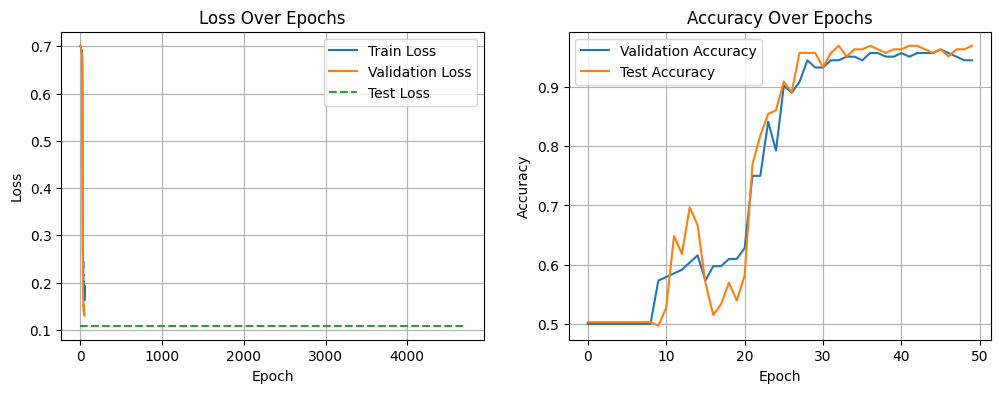

Hyperparameter Trials:  85%|████████▌ | 85/100 [1:01:31<14:34, 58.32s/it]


🔁 Trial 86: hidden_dim=96, num_layers=3, lr=0.0001, batch_size=8, dropout=0.1
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.0001, batch_size=8, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6945, Val Loss: 0.6948, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6944, Val Loss: 0.6942, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6938, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6920, Val Loss: 0.6900, Val Acc: 0.5976, Test Acc: 0.5152
Epoch [5/50], Train Loss: 0.6895, Val Loss: 0.6871, Val Acc: 0.5671, Test Acc: 0.5818
Epoch [6/50], Train Loss: 0.6861, Val Loss: 0.6849, Val Acc: 0.6341, Test Acc: 0.6121
Epoch [7/50], Train Loss: 0.6811, Val Loss: 0.6738, Val Acc: 0.7256, Test Acc: 0.7394
Epoch [8/50], Train Loss: 0.6336, Val Loss: 0.5352, Val Acc: 0.8171, Test Acc: 0.8667
Epoch [9/50], Train Loss: 0.

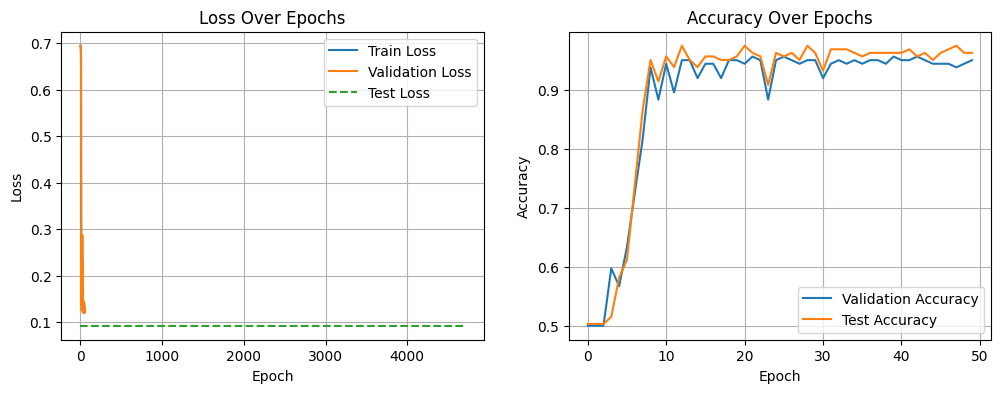

Hyperparameter Trials:  86%|████████▌ | 86/100 [1:02:53<15:17, 65.54s/it]


🔁 Trial 87: hidden_dim=64, num_layers=3, lr=0.001, batch_size=16, dropout=0.1
Debug - Parameters: hidden_dim=64, num_layers=3, learning_rate=0.001, batch_size=16, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6939, Val Loss: 0.6918, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6907, Val Loss: 0.6835, Val Acc: 0.5122, Test Acc: 0.5091
Epoch [3/50], Train Loss: 0.6314, Val Loss: 0.4188, Val Acc: 0.8232, Test Acc: 0.8424
Epoch [4/50], Train Loss: 0.2631, Val Loss: 0.4531, Val Acc: 0.8415, Test Acc: 0.8545
Epoch [5/50], Train Loss: 0.1774, Val Loss: 0.1294, Val Acc: 0.9329, Test Acc: 0.9515
Epoch [6/50], Train Loss: 0.1551, Val Loss: 0.1412, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [7/50], Train Loss: 0.1811, Val Loss: 0.1219, Val Acc: 0.9512, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1291, Val Loss: 0.1831, Val Acc: 0.9390, Test Acc: 0.9576
Epoch [9/50], Train Loss: 0.

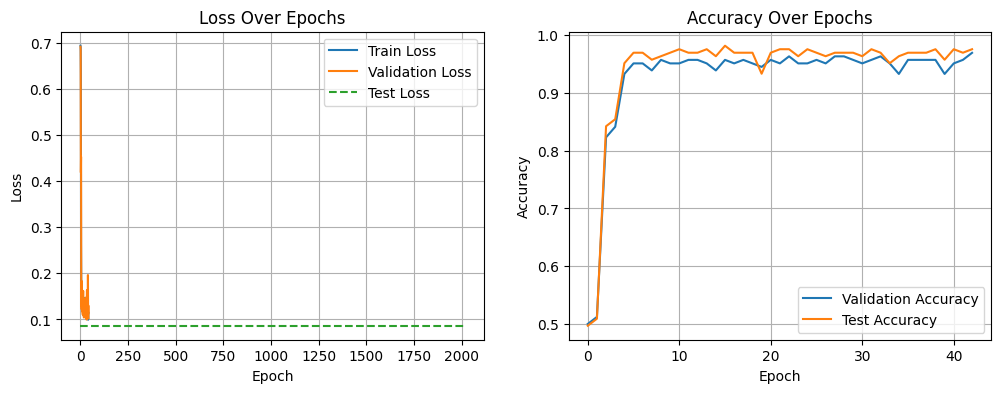

Hyperparameter Trials:  87%|████████▋ | 87/100 [1:03:29<12:14, 56.52s/it]


🔁 Trial 88: hidden_dim=96, num_layers=3, lr=0.01, batch_size=64, dropout=0.2
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.01, batch_size=64, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6963, Val Loss: 0.6938, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6972, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6951, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6939, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6932, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6931, Val Loss: 0.6936, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6945, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6935, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.69

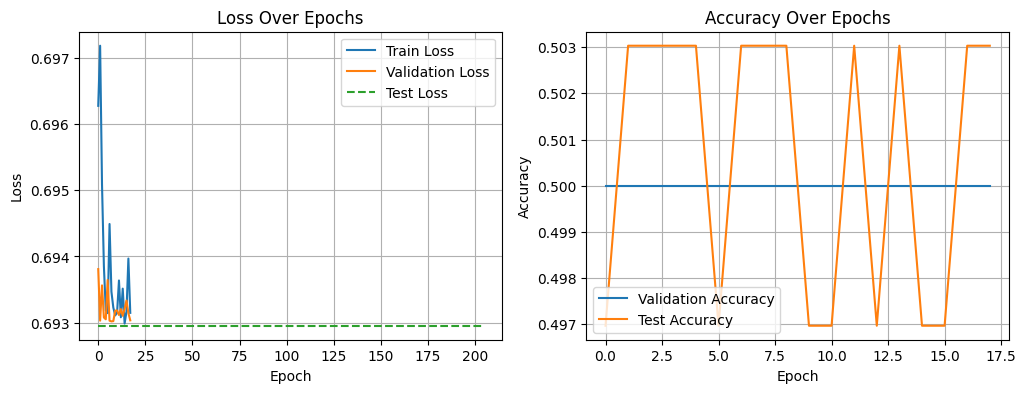

Hyperparameter Trials:  88%|████████▊ | 88/100 [1:03:47<08:59, 44.93s/it]


🔁 Trial 89: hidden_dim=160, num_layers=3, lr=0.0001, batch_size=4, dropout=0.2
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.0001, batch_size=4, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6948, Val Loss: 0.6941, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6942, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6914, Val Loss: 0.6908, Val Acc: 0.5305, Test Acc: 0.5394
Epoch [4/50], Train Loss: 0.6897, Val Loss: 0.6856, Val Acc: 0.5976, Test Acc: 0.5333
Epoch [5/50], Train Loss: 0.6784, Val Loss: 0.6651, Val Acc: 0.5976, Test Acc: 0.6182
Epoch [6/50], Train Loss: 0.5605, Val Loss: 0.3502, Val Acc: 0.8902, Test Acc: 0.9273
Epoch [7/50], Train Loss: 0.2728, Val Loss: 0.2144, Val Acc: 0.9329, Test Acc: 0.9515
Epoch [8/50], Train Loss: 0.2137, Val Loss: 0.1718, Val Acc: 0.9451, Test Acc: 0.9394
Epoch [9/50], Train Loss: 

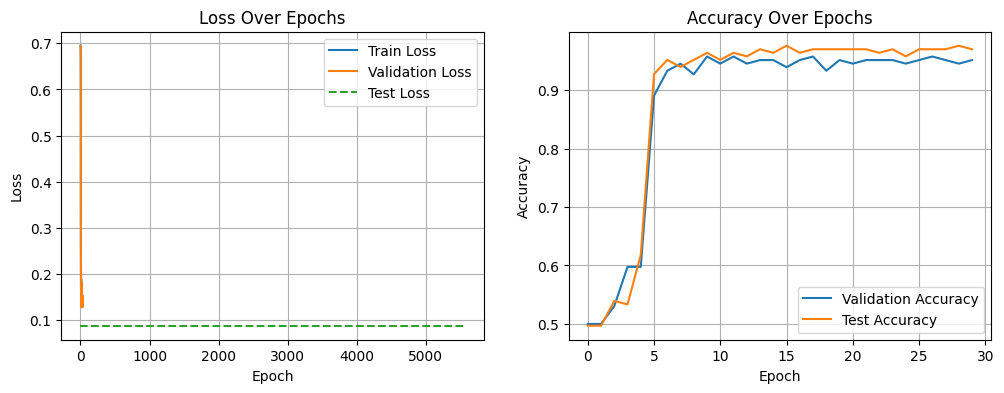

Hyperparameter Trials:  89%|████████▉ | 89/100 [1:05:52<12:40, 69.14s/it]


🔁 Trial 90: hidden_dim=64, num_layers=3, lr=0.0001, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=64, num_layers=3, learning_rate=0.0001, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6939, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6932, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6933, Val Loss: 0.6928, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6928, Val Loss: 0.6919, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6920, Val Loss: 0.6897, Val Acc: 0.5915, Test Acc: 0.5879
Epoch [6/50], Train Loss: 0.6880, Val Loss: 0.6853, Val Acc: 0.5671, Test Acc: 0.5818
Epoch [7/50], Train Loss: 0.6821, Val Loss: 0.6762, Val Acc: 0.6768, Test Acc: 0.7091
Epoch [8/50], Train Loss: 0.6517, Val Loss: 0.5639, Val Acc: 0.8354, Test Acc: 0.8545
Epoch [9/50], Train Loss: 0.

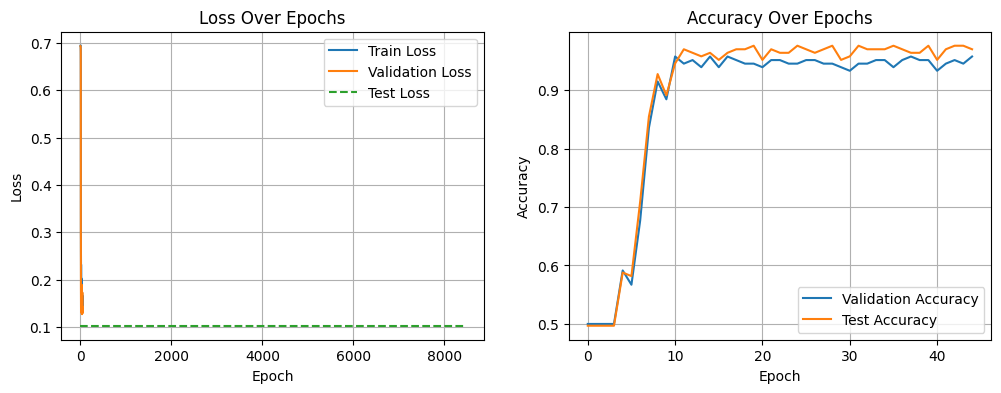

Hyperparameter Trials:  90%|█████████ | 90/100 [1:07:09<11:54, 71.44s/it]


🔁 Trial 91: hidden_dim=128, num_layers=3, lr=0.01, batch_size=16, dropout=0.2
Debug - Parameters: hidden_dim=128, num_layers=3, learning_rate=0.01, batch_size=16, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6919, Val Loss: 0.5498, Val Acc: 0.9024, Test Acc: 0.9273
Epoch [2/50], Train Loss: 0.6566, Val Loss: 0.4526, Val Acc: 0.9695, Test Acc: 0.9636
Epoch [3/50], Train Loss: 0.2720, Val Loss: 0.1410, Val Acc: 0.9451, Test Acc: 0.9758
Epoch [4/50], Train Loss: 0.2121, Val Loss: 0.1415, Val Acc: 0.9451, Test Acc: 0.9576
Epoch [5/50], Train Loss: 0.2200, Val Loss: 0.1276, Val Acc: 0.9573, Test Acc: 0.9697
Epoch [6/50], Train Loss: 0.1249, Val Loss: 0.2154, Val Acc: 0.9268, Test Acc: 0.9515
Epoch [7/50], Train Loss: 0.1442, Val Loss: 0.2478, Val Acc: 0.9329, Test Acc: 0.9576
Epoch [8/50], Train Loss: 0.2264, Val Loss: 0.1327, Val Acc: 0.9695, Test Acc: 0.9697
Epoch [9/50], Train Loss: 0.

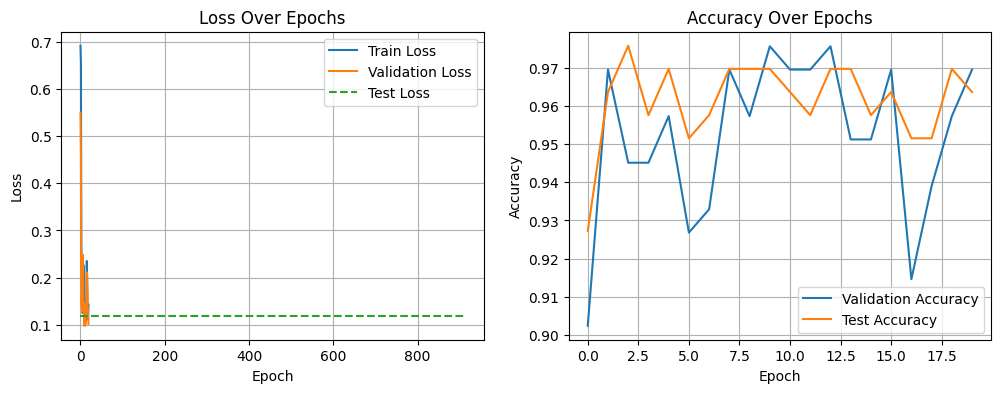

Hyperparameter Trials:  91%|█████████ | 91/100 [1:07:46<09:08, 60.98s/it]


🔁 Trial 92: hidden_dim=160, num_layers=2, lr=0.001, batch_size=64, dropout=0.1
Debug - Parameters: hidden_dim=160, num_layers=2, learning_rate=0.001, batch_size=64, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6937, Val Loss: 0.6918, Val Acc: 0.5061, Test Acc: 0.5212
Epoch [2/50], Train Loss: 0.6901, Val Loss: 0.6884, Val Acc: 0.5061, Test Acc: 0.5212
Epoch [3/50], Train Loss: 0.6827, Val Loss: 0.6662, Val Acc: 0.5061, Test Acc: 0.5273
Epoch [4/50], Train Loss: 0.6487, Val Loss: 0.6264, Val Acc: 0.7683, Test Acc: 0.8121
Epoch [5/50], Train Loss: 0.5343, Val Loss: 0.4550, Val Acc: 0.9207, Test Acc: 0.9333
Epoch [6/50], Train Loss: 0.3841, Val Loss: 0.4137, Val Acc: 0.8659, Test Acc: 0.8788
Epoch [7/50], Train Loss: 0.3249, Val Loss: 0.2635, Val Acc: 0.9146, Test Acc: 0.9273
Epoch [8/50], Train Loss: 0.2452, Val Loss: 0.4542, Val Acc: 0.8659, Test Acc: 0.8545
Epoch [9/50], Train Loss: 

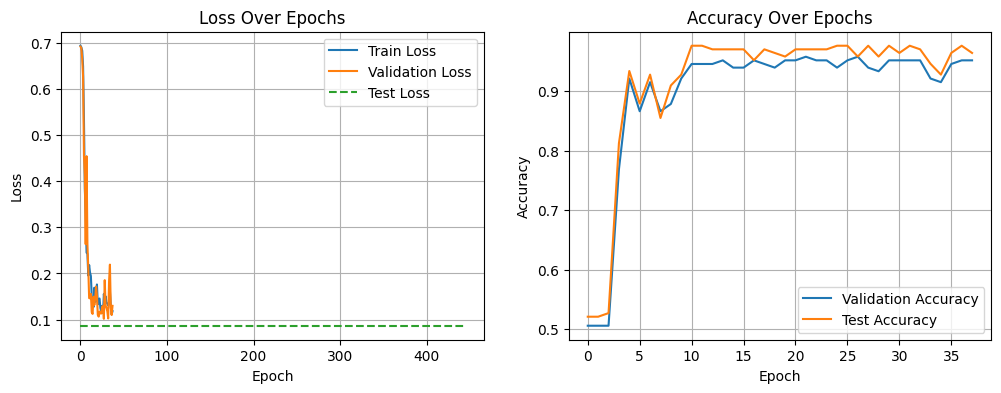

Hyperparameter Trials:  92%|█████████▏| 92/100 [1:08:40<07:52, 59.03s/it]


🔁 Trial 93: hidden_dim=96, num_layers=2, lr=0.01, batch_size=32, dropout=0.1
Debug - Parameters: hidden_dim=96, num_layers=2, learning_rate=0.01, batch_size=32, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7016, Val Loss: 0.6911, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6952, Val Loss: 0.7055, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6980, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6946, Val Loss: 0.6963, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6937, Val Loss: 0.6918, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6937, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6938, Val Loss: 0.6943, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6927, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [9/50], Train Loss: 0.69

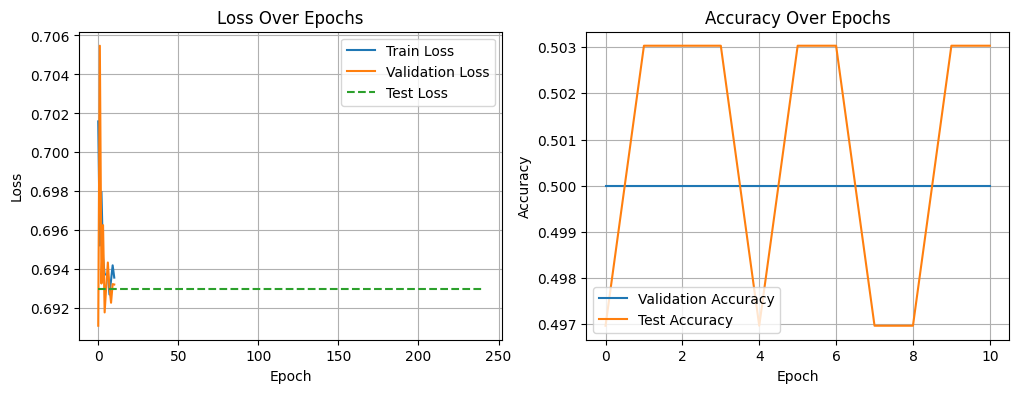

Hyperparameter Trials:  93%|█████████▎| 93/100 [1:08:49<05:07, 43.97s/it]


🔁 Trial 94: hidden_dim=160, num_layers=2, lr=0.001, batch_size=32, dropout=0.1
Debug - Parameters: hidden_dim=160, num_layers=2, learning_rate=0.001, batch_size=32, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6950, Val Loss: 0.6966, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6928, Val Loss: 0.6821, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6370, Val Loss: 0.3852, Val Acc: 0.9024, Test Acc: 0.8909
Epoch [4/50], Train Loss: 0.3173, Val Loss: 0.2109, Val Acc: 0.9329, Test Acc: 0.9515
Epoch [5/50], Train Loss: 0.1668, Val Loss: 0.1153, Val Acc: 0.9329, Test Acc: 0.9636
Epoch [6/50], Train Loss: 0.1378, Val Loss: 0.1601, Val Acc: 0.9390, Test Acc: 0.9394
Epoch [7/50], Train Loss: 0.1582, Val Loss: 0.1184, Val Acc: 0.9390, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1353, Val Loss: 0.1164, Val Acc: 0.9512, Test Acc: 0.9758
Epoch [9/50], Train Loss: 

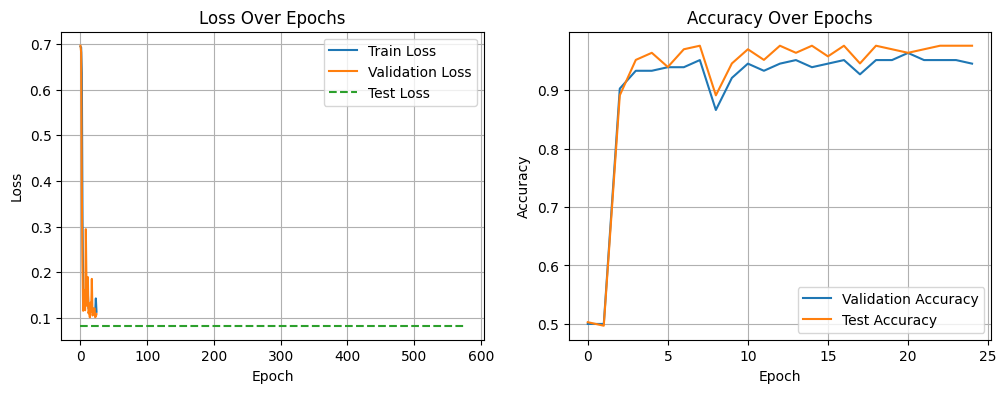

Hyperparameter Trials:  94%|█████████▍| 94/100 [1:09:25<04:10, 41.74s/it]


🔁 Trial 95: hidden_dim=96, num_layers=3, lr=0.01, batch_size=4, dropout=0.3
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.01, batch_size=4, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7053, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6954, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6939, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6948, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6938, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6954, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6940, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [8/50], Train Loss: 0.6952, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.6939

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6931, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6943, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


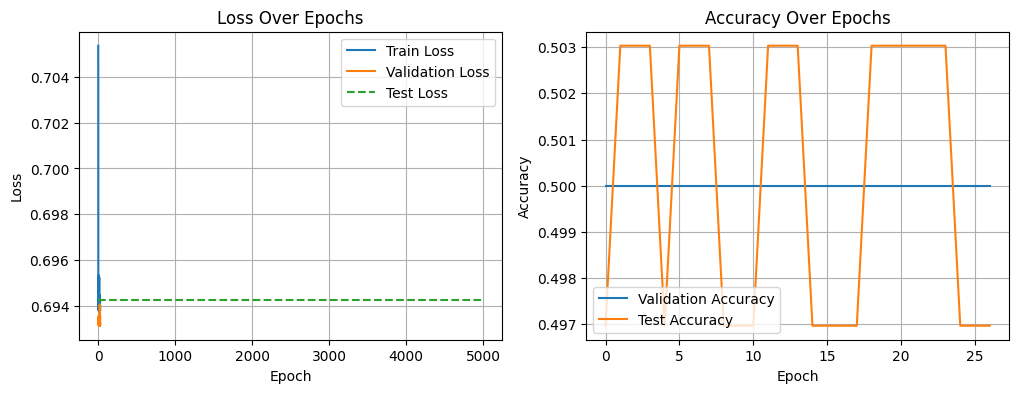

Hyperparameter Trials:  95%|█████████▌| 95/100 [1:10:35<04:10, 50.17s/it]


🔁 Trial 96: hidden_dim=96, num_layers=3, lr=0.01, batch_size=32, dropout=0.2
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.01, batch_size=32, dropout_rate=0.2
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6982, Val Loss: 0.6900, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6800, Val Loss: 0.5023, Val Acc: 0.7866, Test Acc: 0.7697
Epoch [3/50], Train Loss: 0.2392, Val Loss: 0.1522, Val Acc: 0.9634, Test Acc: 0.9697
Epoch [4/50], Train Loss: 0.1484, Val Loss: 0.1384, Val Acc: 0.9451, Test Acc: 0.9576
Epoch [5/50], Train Loss: 0.2189, Val Loss: 0.3354, Val Acc: 0.7988, Test Acc: 0.8364
Epoch [6/50], Train Loss: 0.1209, Val Loss: 0.0964, Val Acc: 0.9573, Test Acc: 0.9697
Epoch [7/50], Train Loss: 0.1102, Val Loss: 0.0957, Val Acc: 0.9756, Test Acc: 0.9697
Epoch [8/50], Train Loss: 0.1003, Val Loss: 0.0917, Val Acc: 0.9695, Test Acc: 0.9697
Epoch [9/50], Train Loss: 0.09

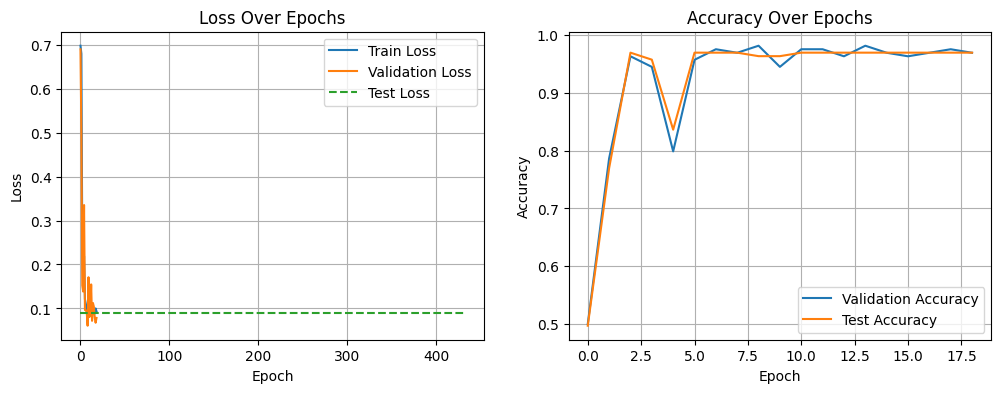

Hyperparameter Trials:  96%|█████████▌| 96/100 [1:10:57<02:46, 41.54s/it]


🔁 Trial 97: hidden_dim=128, num_layers=3, lr=0.01, batch_size=8, dropout=0.1
Debug - Parameters: hidden_dim=128, num_layers=3, learning_rate=0.01, batch_size=8, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.7008, Val Loss: 0.6935, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [2/50], Train Loss: 0.6936, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6937, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [4/50], Train Loss: 0.6938, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6939, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6940, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [7/50], Train Loss: 0.6939, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6939, Val Loss: 0.6932, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6931, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6933, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


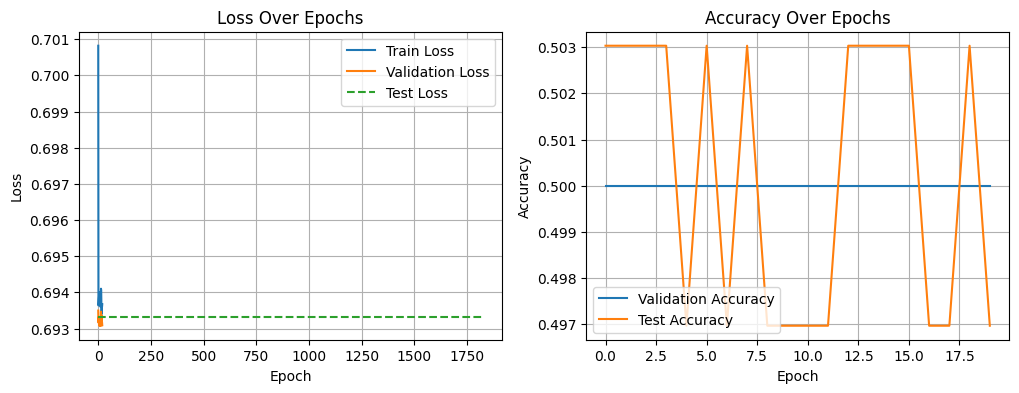

Hyperparameter Trials:  97%|█████████▋| 97/100 [1:11:52<02:16, 45.57s/it]


🔁 Trial 98: hidden_dim=128, num_layers=3, lr=0.01, batch_size=8, dropout=0.3
Debug - Parameters: hidden_dim=128, num_layers=3, learning_rate=0.01, batch_size=8, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6978, Val Loss: 0.6930, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6944, Val Loss: 0.6778, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6610, Val Loss: 0.6410, Val Acc: 0.5732, Test Acc: 0.5333
Epoch [4/50], Train Loss: 0.6711, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6942, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6950, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6942, Val Loss: 0.6931, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [8/50], Train Loss: 0.6941, Val Loss: 0.6933, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [9/50], Train Loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model - Validation: Loss: 0.6410, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best Model - Test: Loss: 0.6942, Accuracy: 0.4970, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


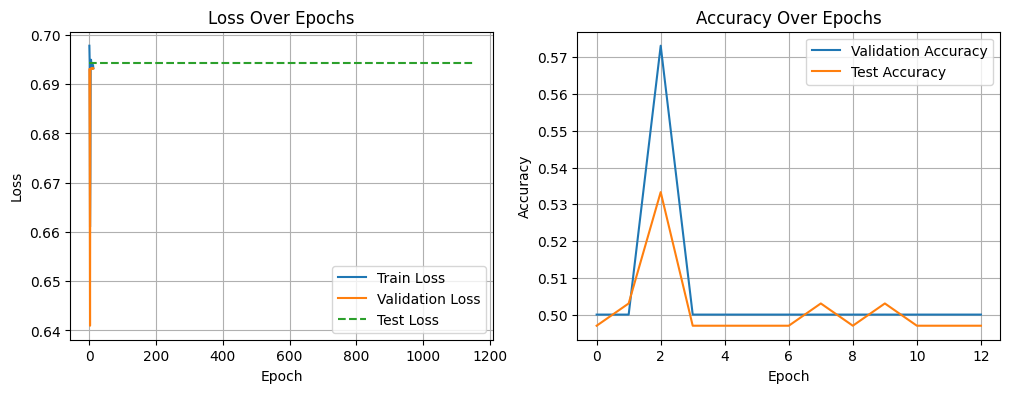

Hyperparameter Trials:  98%|█████████▊| 98/100 [1:12:23<01:22, 41.33s/it]


🔁 Trial 99: hidden_dim=160, num_layers=3, lr=0.001, batch_size=64, dropout=0.1
Debug - Parameters: hidden_dim=160, num_layers=3, learning_rate=0.001, batch_size=64, dropout_rate=0.1
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6991, Val Loss: 0.6970, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6932, Val Loss: 0.6934, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [3/50], Train Loss: 0.6980, Val Loss: 0.6949, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6914, Val Loss: 0.6925, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [5/50], Train Loss: 0.6936, Val Loss: 0.6916, Val Acc: 0.5000, Test Acc: 0.5030
Epoch [6/50], Train Loss: 0.6882, Val Loss: 0.6865, Val Acc: 0.6098, Test Acc: 0.6424
Epoch [7/50], Train Loss: 0.6788, Val Loss: 0.6577, Val Acc: 0.7195, Test Acc: 0.7515
Epoch [8/50], Train Loss: 0.5915, Val Loss: 0.4869, Val Acc: 0.7622, Test Acc: 0.7697
Epoch [9/50], Train Loss: 

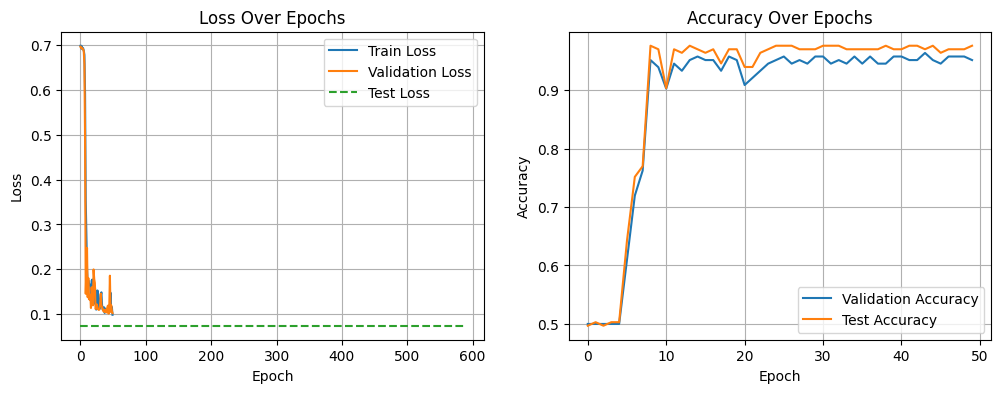

Hyperparameter Trials:  99%|█████████▉| 99/100 [1:14:16<01:02, 62.85s/it]

✅ New Best Model at Trial 99 with Test Loss = 0.0737
✅ New Best Model at Trial 99 with Test Loss = 0.0737

🔁 Trial 100: hidden_dim=96, num_layers=3, lr=0.0001, batch_size=32, dropout=0.3
Debug - Parameters: hidden_dim=96, num_layers=3, learning_rate=0.0001, batch_size=32, dropout_rate=0.3
Debug - hidden_dim type: <class 'int'>, num_layers type: <class 'int'>, batch_size type: <class 'int'>
Epoch [1/50], Train Loss: 0.6937, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [2/50], Train Loss: 0.6936, Val Loss: 0.6925, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [3/50], Train Loss: 0.6932, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [4/50], Train Loss: 0.6931, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [5/50], Train Loss: 0.6929, Val Loss: 0.6927, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [6/50], Train Loss: 0.6933, Val Loss: 0.6926, Val Acc: 0.5000, Test Acc: 0.4970
Epoch [7/50], Train Loss: 0.6930, Val Loss: 0.6925, Val Acc: 0.5000, Test Acc: 0.4970
Epoch

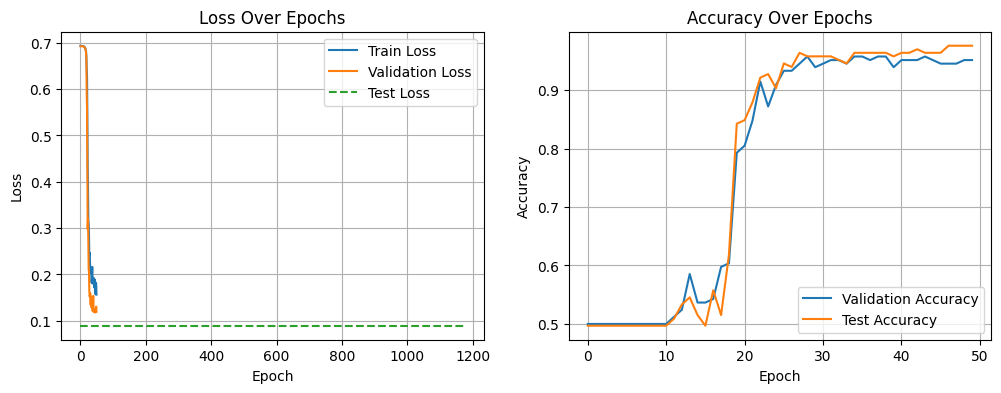

Hyperparameter Trials: 100%|██████████| 100/100 [1:15:11<00:00, 45.11s/it]



📁 Saved all results to 'hyperparameter_trials_lstm.csv'

🏆 Best Hyperparameter Configuration:
trial: 99
hidden_dim: 160
num_layers: 3
learning_rate: 0.001
batch_size: 64
dropout_rate: 0.1
val_accuracy: 0.9512195121951219
test_accuracy: 0.9757575757575757
test_loss: 0.07366939820349216
📦 Best model saved to 'results/best_lstm_model.pt'
📝 Best hyperparameters saved to 'results/best_hyperparameters.txt'
📊 Epoch-wise performance saved to 'results/best_model_epoch_metrics.csv'


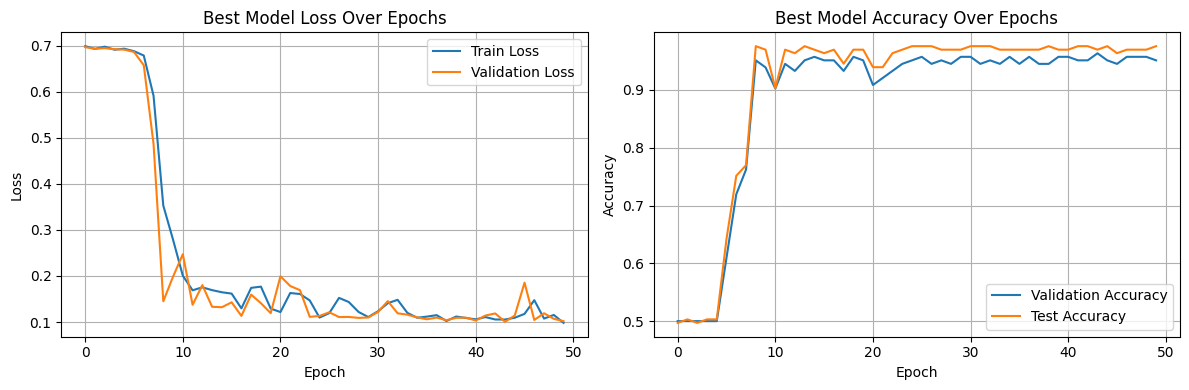

📉 Accuracy and loss curves saved to 'results/best_model_curves.png'

✅ All results successfully saved in the 'results/' directory.


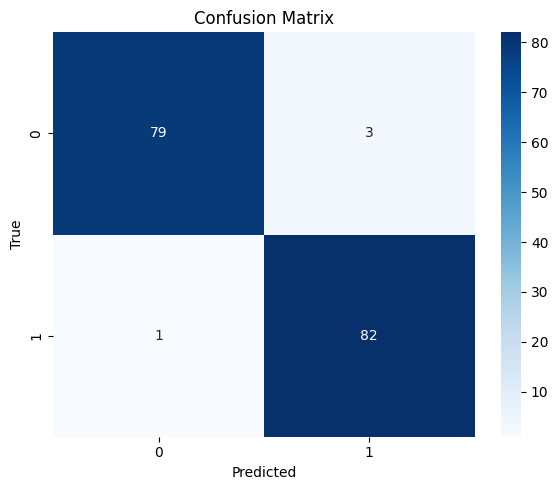

              precision    recall  f1-score   support

     Class 0       0.99      0.96      0.98        82
     Class 1       0.96      0.99      0.98        83

    accuracy                           0.98       165
   macro avg       0.98      0.98      0.98       165
weighted avg       0.98      0.98      0.98       165



In [ ]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Create datasets only once
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Track best results
best_val_loss = float('inf')
best_model = None
best_params = {}
all_trials = []

# Start randomized hyperparameter search
for i in tqdm(range(100), desc="Hyperparameter Trials"):

    # Sample hyperparameters randomly
    hidden_dim = random.choice(param_grid['hidden_dim'])
    num_layers = random.choice(param_grid['num_layers'])
    learning_rate = random.choice(param_grid['learning_rate'])
    batch_size = random.choice(param_grid['batch_size'])
    dropout_rate = random.choice(param_grid['dropout_rate'])

    print(f"\n🔁 Trial {i+1}: hidden_dim={hidden_dim}, num_layers={num_layers}, "
          f"lr={learning_rate}, batch_size={batch_size}, dropout={dropout_rate}")

    # Create DataLoaders inside the loop with current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train and evaluate
    model, hidden_states, val_accs, test_accs, train_losses, val_losses, test_loss = train_and_evaluate(
        hidden_dim, num_layers, learning_rate, batch_size, dropout_rate,
        X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor,
        X_test_tensor, y_test_tensor
    )

    # Track results
    trial = {
        "trial": i + 1,
        "hidden_dim": hidden_dim,
        "num_layers": num_layers,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "dropout_rate": dropout_rate,
        "val_accuracy": val_accs[-1] if val_accs else None,
        "test_accuracy": test_accs[-1] if test_accs else None,
        "test_loss": test_loss
    }
    all_trials.append(trial)

    # Check if best model
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        best_model = model
        best_params = trial
        print(f"✅ New Best Model at Trial {i+1} with Test Loss = {test_loss:.4f}")

        best_val_accs = val_accs
        best_test_accs = test_accs
        best_train_losses = train_losses
        best_val_losses = val_losses

        print(f"✅ New Best Model at Trial {i+1} with Test Loss = {test_loss:.4f}")

# Convert to DataFrame and save
df_trials = pd.DataFrame(all_trials)
df_trials.to_csv("hyperparameter_trials_lstm.csv", index=False)
print("\n📁 Saved all results to 'hyperparameter_trials_lstm.csv'")

# Show best model
print("\n🏆 Best Hyperparameter Configuration:")
for key, value in best_params.items():
    print(f"{key}: {value}")




# 🔧 Create results folder
os.makedirs("results", exist_ok=True)

# ✅ Save best model weights
torch.save(best_model.state_dict(), "results/best_lstm_model.pt")
print("📦 Best model saved to 'results/best_lstm_model.pt'")

# ✅ Save best hyperparameters and summary
with open("results/best_hyperparameters.txt", "w") as f:
    f.write("Best Hyperparameters and Performance:\n")
    for key, value in best_params.items():
        f.write(f"{key}: {value}\n")
    f.write(f"Best Test Loss: {best_val_loss:.4f}\n")

print("📝 Best hyperparameters saved to 'results/best_hyperparameters.txt'")

# ✅ Save epoch-wise metrics
df_metrics = pd.DataFrame({
    "Epoch": list(range(len(best_val_accs))),
    "Validation Accuracy": best_val_accs,
    "Test Accuracy": best_test_accs,
    "Train Loss": best_train_losses,
    "Validation Loss": best_val_losses
})
df_metrics.to_csv("results/best_model_epoch_metrics.csv", index=False)
print("📊 Epoch-wise performance saved to 'results/best_model_epoch_metrics.csv'")

# ✅ Plot and save learning curves
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.title("Best Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(best_val_accs, label='Validation Accuracy')
plt.plot(best_test_accs, label='Test Accuracy')
plt.title("Best Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("results/best_model_curves.png", dpi=300)
plt.show()
print("📉 Accuracy and loss curves saved to 'results/best_model_curves.png'")

print("\n✅ All results successfully saved in the 'results/' directory.")



from sklearn.metrics import confusion_matrix, classification_report


# 🧠 Generate predictions from best model on test set
best_model.eval()
y_preds = []
y_trues = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs, _ = best_model(X_batch)
        preds = torch.sigmoid(outputs).cpu().numpy().flatten() > 0.5  # binary threshold
        y_preds.extend(preds)
        y_trues.extend(y_batch.numpy())

# Convert to numpy arrays
y_true = np.array(y_trues, dtype=int)
y_pred = np.array(y_preds, dtype=int)

# ✅ Create Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()

# Save confusion matrix plot
os.makedirs("results", exist_ok=True)
plt.savefig("results/confusion_matrix.png")
plt.show()

# ✅ Classification Report
report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"])
print(report)

# Save report to text file
with open("results/classification_report.txt", "w") as f:
    f.write(report)



In [ ]:
# Install required libraries
!pip install captum torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18

In [ ]:
# from captum.attr import DeepLiftShap
# from sklearn.model_selection import StratifiedShuffleSplit
# # Set the model to training mode temporarily to allow backward pass
# best_model.train()

# # Define a wrapper model to extract only the classification output
# class LSTMWrapper(nn.Module):
#     def __init__(self, lstm_model):
#         super(LSTMWrapper, self).__init__()
#         self.lstm_model = lstm_model

#     def forward(self, x):
#         output, _ = self.lstm_model(x)  # Extract only classification logits
#         return output  # SHAP requires a single output tensor

# # Wrap the trained LSTM model
# wrapped_model = LSTMWrapper(best_model).to(device)


In [ ]:
import torch
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from captum.attr import DeepLiftShap
os.makedirs("XAI_results_ItalyPowerDemand", exist_ok=True)
# ✅ Re-enable training mode for backward pass (CuDNN)
best_model.train()

# ✅ Define clean wrapper
class LSTMWrapper(nn.Module):
    def __init__(self, lstm_model):
        super().__init__()
        self.lstm_model = lstm_model

    def forward(self, x):
        logits, _ = self.lstm_model(x)
        return logits  # Ensure logits returned for classification

wrapped_model = LSTMWrapper(best_model).to(device)

# ✅ Select background dataset using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=100, random_state=42)
for _, idx in sss.split(X_train_tensor, y_train_tensor):
    X_background = X_train_tensor[idx].to(device)

# ✅ Select test sample
X_test_sample = X_test_tensor[:30].to(device)
X_test_np = X_test_sample.cpu().numpy().squeeze()

# ✅ Initialize DeepLift SHAP
dlshap = DeepLiftShap(wrapped_model)

# ✅ Attribution with training mode on (for RNNs)
def compute_attribution(attr_method, inputs, baselines):
    model = attr_method.forward_func
    original_mode = model.training
    model.train()
    try:
        attributions = attr_method.attribute(inputs, baselines=baselines)
    finally:
        model.train(original_mode)
    return attributions

# ✅ Compute attributions
dlshap_attr = compute_attribution(dlshap, X_test_sample, X_background)
dlshap_attr_np = dlshap_attr.squeeze(-1).detach().cpu().numpy()

# ✅ Sanity check
print(f"Attributions shape: {dlshap_attr_np.shape}")
print(f"Test inputs shape: {X_test_np.shape}")

# ✅ Normalize attributions
def normalize_attr(attr):
    attr_min = attr.min(axis=1, keepdims=True)
    attr_max = attr.max(axis=1, keepdims=True)
    return (attr - attr_min) / (attr_max - attr_min + 1e-8)

dlshap_attr_np_norm = normalize_attr(dlshap_attr_np)

# ✅ SHAP summary plot
#shap.summary_plot(dlshap_attr_np, X_test_np, feature_names=[f"t={i}" for i in range(X_test_np.shape[1])])
plt.title("DeepLIFT SHAP style Summary Plot (Feature Impact and Value Distribution)", fontsize=14)
shap.summary_plot(dlshap_attr_np, X_test_np, feature_names=[f"t={i}" for i in range(X_test_np.shape[1])], show=False)
plt.savefig("XAI_results_ItalyPowerDemand/deeplift_shap_summary_plot.png", dpi=300, bbox_inches="tight")
plt.close()


# ✅ Heatmap
xtick_labels = [f"t={i}" if i % 2 == 0 else "" for i in range(dlshap_attr_np_norm.shape[1])]
plt.figure(figsize=(16,12))
sns.heatmap(dlshap_attr_np_norm, cmap="coolwarm", xticklabels=xtick_labels)
plt.title("DeepLift SHAP Attribution Heatmap",fontsize=20)
plt.xlabel("Time Steps",fontsize=20)
plt.ylabel("Samples",fontsize=20)
plt.tight_layout()
plt.savefig("XAI_results_ItalyPowerDemand/deeplift_shap_heatmap.png", dpi=400, bbox_inches="tight")
plt.close()





# ✅ Mean importance bar plot
mean_importance = np.abs(dlshap_attr_np).mean(axis=0)

# Sort and select top-k important time steps
top_k = 24
sorted_idx = np.argsort(mean_importance)[::-1][:top_k]
sorted_feat_names = [f"t={i}" for i in sorted_idx]
sorted_values = mean_importance[sorted_idx]
#sorted_idx = np.argsort(mean_importance)[::-1]

# sorted_feat_names = [f"t={i}" for i in sorted_idx]
# sorted_values = mean_importance[sorted_idx]

plt.figure(figsize=(8,12))
plt.barh(sorted_feat_names, sorted_values, color="darkblue")
plt.xlabel("mean(|SHAP value|)")
plt.title("Top 24 Time Steps DeepLIFT SHAP Attribution (ECG200)", fontsize=16)
plt.gca().invert_yaxis()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("XAI_results_ItalyPowerDemand/deeplift_shap_bar_plot.png", dpi=500, bbox_inches="tight")
plt.close()

# # ✅ Mean importance bar plot
# mean_importance = np.abs(dlshap_attr_np).mean(axis=0)
# sorted_idx = np.argsort(mean_importance)[::-1]
# sorted_feat_names = [f"t={i}" for i in sorted_idx]
# sorted_values = mean_importance[sorted_idx]

# plt.figure(figsize=(8, 6))
# plt.barh(sorted_feat_names, sorted_values, color="darkblue")
# plt.xlabel("mean(|SHAP value|)")
# plt.title("DeepLift SHAP Feature Importance")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()


/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:810: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  attributions = super().attribute.__wrapped__(  # type: ignore


Attributions shape: (30, 24)
Test inputs shape: (30, 24)


<ipython-input-38-805a71df3b41>:66: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(dlshap_attr_np, X_test_np, feature_names=[f"t={i}" for i in range(X_test_np.shape[1])], show=False)


In [ ]:
from captum.attr import IntegratedGradients
os.makedirs("XAI_results_ItalyPowerDemand", exist_ok=True)
# ✅ Initialize IG explainer
ig = IntegratedGradients(wrapped_model)

# ✅ Use zero baseline (common for normalized time series)
baseline_ig = torch.zeros_like(X_test_sample).to(device)

# ✅ Compute IG attributions with gradient-safe wrapper
ig_attr = compute_attribution(ig, X_test_sample, baselines=baseline_ig)
ig_attr_np = ig_attr.squeeze(-1).cpu().detach().numpy()  # Shape: [samples, time_steps]

# ✅ Normalize IG attributions
ig_attr_np_norm = normalize_attr(ig_attr_np)

# ✅ SHAP-style summary plot
plt.title("Integrated Gradients SHAP style Summary Plot (Feature Impact and Value Distribution)", fontsize=14)
shap.summary_plot(ig_attr_np, X_test_np, feature_names=[f"t={i}" for i in range(X_test_np.shape[1])],show=False )
plt.savefig("XAI_results_ItalyPowerDemand/integrated_gradients_summary_plot.png", dpi=400, bbox_inches="tight")
plt.tight_layout()
plt.close()


# ✅ IG heatmap
xtick_labels = [f"t={i}" if i % 2 == 0 else "" for i in range(ig_attr_np.shape[1])]
plt.figure(figsize=(16,12))
sns.heatmap(ig_attr_np_norm, cmap="coolwarm",
            xticklabels=xtick_labels)
plt.title("Integrated Gradients Attribution Heatmap",fontsize=20)
plt.xlabel("Time Steps",fontsize=20)
plt.ylabel("Samples",fontsize=20)
plt.tight_layout()
plt.savefig("XAI_results_ItalyPowerDemand/integrated_gradients_heatmap.png", dpi=400, bbox_inches="tight")
plt.close()

# ✅ IG feature importance bar plot
mean_ig = np.abs(ig_attr_np).mean(axis=0)
top_k = 24
sorted_idx = np.argsort(mean_ig)[::-1][:top_k]
sorted_feat_names = [f"t={i}" for i in sorted_idx]
sorted_values = mean_ig[sorted_idx]

# sorted_idx = np.argsort(mean_ig)[::-1]
# sorted_feat_names = [f"t={i}" for i in sorted_idx]
# sorted_values = mean_ig[sorted_idx]

plt.figure(figsize=(8,12))
plt.barh(sorted_feat_names, sorted_values, color="darkorange")
plt.xlabel("mean(|IG value|)")
plt.title("Integrated Gradients Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("XAI_results_ItalyPowerDemand/integrated_gradients_bar_plot_top30.png", dpi=400, bbox_inches="tight")
plt.close()


<ipython-input-42-e89059ec924a>:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(ig_attr_np, X_test_np, feature_names=[f"t={i}" for i in range(X_test_np.shape[1])],show=False )


In [52]:
from captum.attr import Saliency

import shap

os.makedirs("XAI_results_ItalyPowerDemand", exist_ok=True)
# ✅ Safe Captum attribution wrapper
def compute_attribution(attr_method, inputs, baselines=None, **kwargs):
    """
    Compute Captum attributions safely with optional baseline and RNN support.
    """
    model = attr_method.forward_func
    was_training = model.training
    model.train()  # Needed for RNN backward pass

    try:
        if baselines is not None:
            attributions = attr_method.attribute(inputs, baselines=baselines, **kwargs)
        else:
            attributions = attr_method.attribute(inputs, **kwargs)
    finally:
        model.train(was_training)  # Restore model's original state

    return attributions

# ✅ Normalize attributions for plotting
def normalize_attr(attr):
    attr_min = attr.min(axis=1, keepdims=True)
    attr_max = attr.max(axis=1, keepdims=True)
    return (attr - attr_min) / (attr_max - attr_min + 1e-8)

# ✅ Initialize Saliency explainer
saliency = Saliency(wrapped_model)

# ✅ Compute Saliency attributions (no baseline needed)
sal_attr = compute_attribution(saliency, X_test_sample, baselines=None)
sal_attr_np = sal_attr.squeeze(-1).cpu().detach().numpy()

# ✅ Normalize for consistent visualization
sal_attr_np_norm = normalize_attr(sal_attr_np)

# ✅ SHAP-style summary plot
plt.title("Saliency Maps SHAP style Summary Plot (Feature Impact and Value Distribution)", fontsize=16)
# shap.summary_plot(
#     sal_attr_np,
#     X_test_np,
#     feature_names=[f"t={i}" for i in range(X_test_np.shape[1]),show=False)]
# )
shap.summary_plot(sal_attr_np, X_test_np, feature_names=[f"t={i}" for i in range(X_test_np.shape[1])],show=False)
plt.savefig("XAI_results_ItalyPowerDemand/saliencymaps_summary_plot.png", dpi=400, bbox_inches="tight")
plt.tight_layout()
plt.close()

# ✅ Heatmap visualization
xtick_labels = [f"t={i}" if i % 2 == 0 else "" for i in range(ig_attr_np.shape[1])]
plt.figure(figsize=(16,12))
sns.heatmap(
    sal_attr_np_norm,
    cmap="coolwarm",
    xticklabels=xtick_labels,
    yticklabels=False,
    center=0
)
plt.title("Saliency Attribution Heatmap",fontsize=20)
plt.xlabel("Time Steps",fontsize=20)
plt.ylabel("Samples",fontsize=20)
plt.tight_layout()
plt.savefig("XAI_results_ItalyPowerDemand/saliencymaps_heatmap.png", dpi=400, bbox_inches="tight")
plt.close()

# ✅ Bar plot of feature importance
mean_sal = np.abs(sal_attr_np).mean(axis=0)
top_k = 24
sorted_idx = np.argsort(mean_ig)[::-1][:top_k]
sorted_feat_names = [f"t={i}" for i in sorted_idx]
sorted_values = mean_sal[sorted_idx]

# sorted_idx = np.argsort(mean_sal)[::-1]
# sorted_feat_names = [f"t={i}" for i in sorted_idx]
# sorted_values = mean_sal[sorted_idx]

plt.figure(figsize=(8,12))
plt.barh(sorted_feat_names, sorted_values, color="crimson")
plt.xlabel("mean(|Saliency|)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Saliency Feature Importance",fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("XAI_results_ItalyPowerDemand/saliencymaps_bar_plot_top50.png", dpi=400, bbox_inches="tight")
plt.close()
#


/usr/local/lib/python3.11/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
<ipython-input-52-625804938e53>:48: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sal_attr_np, X_test_np, feature_names=[f"t={i}" for i in range(X_test_np.shape[1])],show=False)


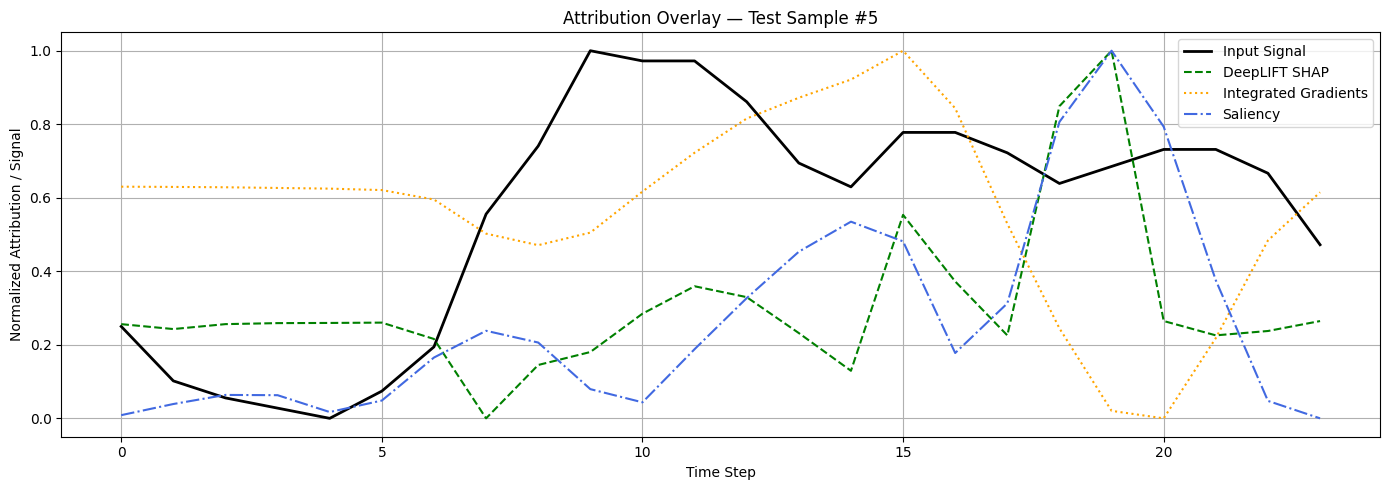

In [53]:


# ✅ Choose the test sample index to visualize
sample_idx = 5  # You can change this to 1, 2, etc.

# ✅ Extract input signal and attributions for the same sample
input_signal = X_test_np[sample_idx]  # shape: [time_steps]
dlshap_values = dlshap_attr_np[sample_idx]
ig_values = ig_attr_np[sample_idx]
saliency_values = sal_attr_np[sample_idx]

# ✅ Normalize attributions (optional but improves visual comparison)
def normalize_1d(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

dlshap_values = normalize_1d(dlshap_values)
ig_values = normalize_1d(ig_values)
saliency_values = normalize_1d(saliency_values)

# ✅ Plot side-by-side overlay
plt.figure(figsize=(14, 5))
plt.plot(input_signal, label='Input Signal', color='black', linewidth=2)
plt.plot(dlshap_values, label='DeepLIFT SHAP', linestyle='--', color='green')
plt.plot(ig_values, label='Integrated Gradients', linestyle=':', color='orange')
plt.plot(saliency_values, label='Saliency', linestyle='-.', color='royalblue')

plt.title(f"Attribution Overlay — Test Sample #{sample_idx}")
plt.xlabel("Time Step")
plt.ylabel("Normalized Attribution / Signal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


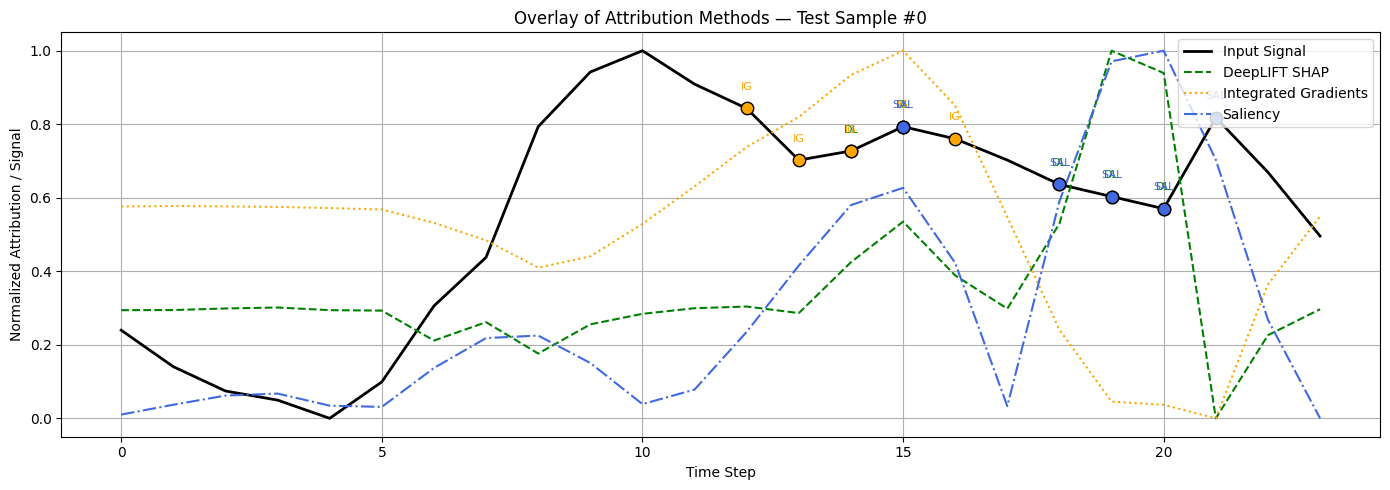

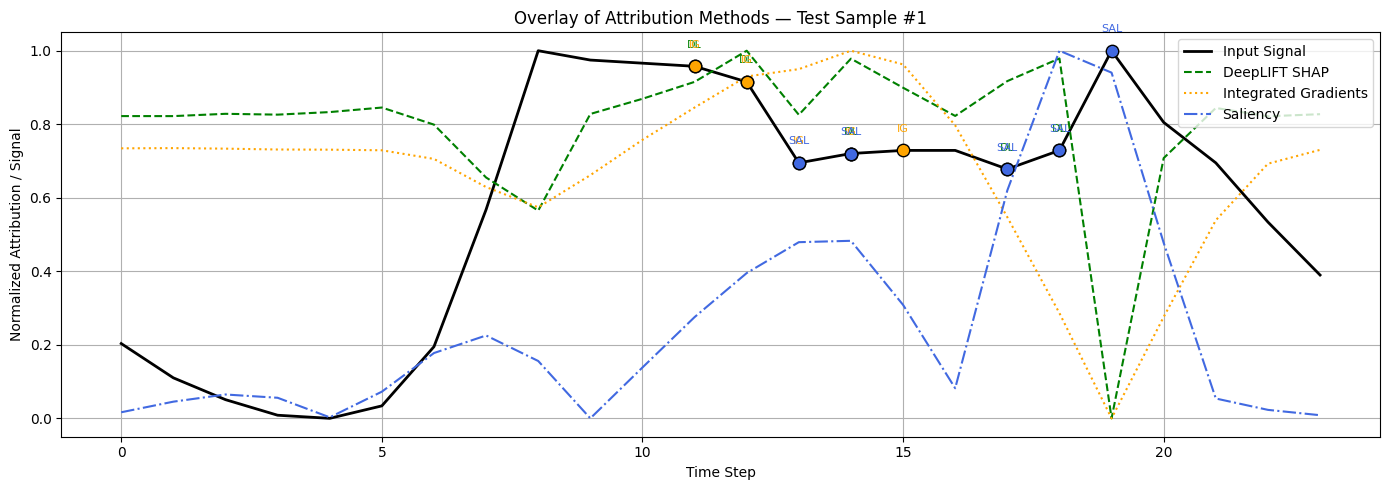

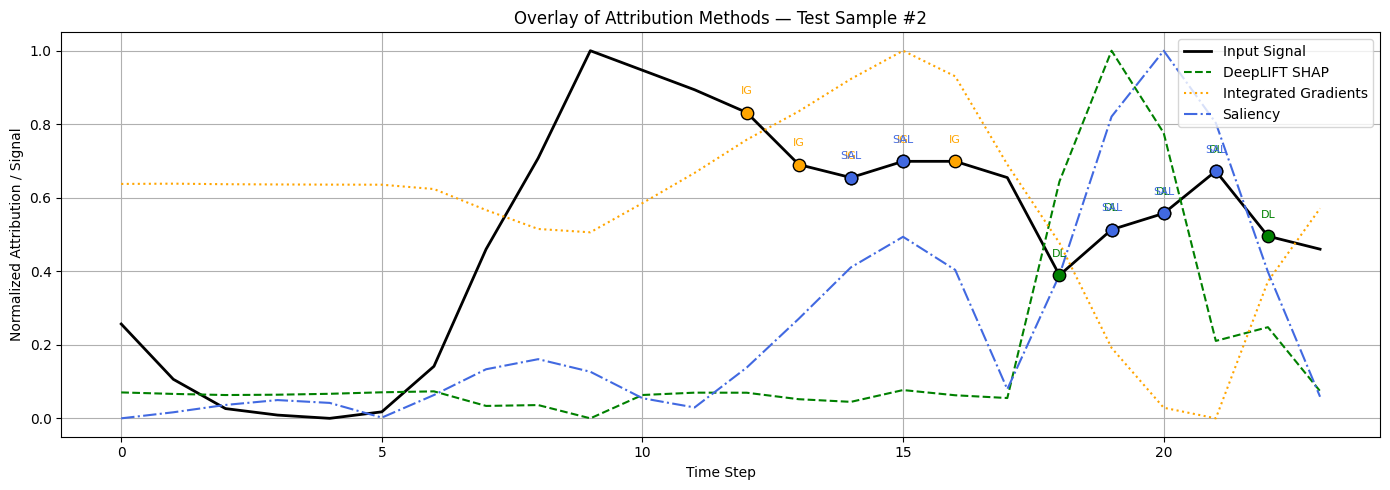

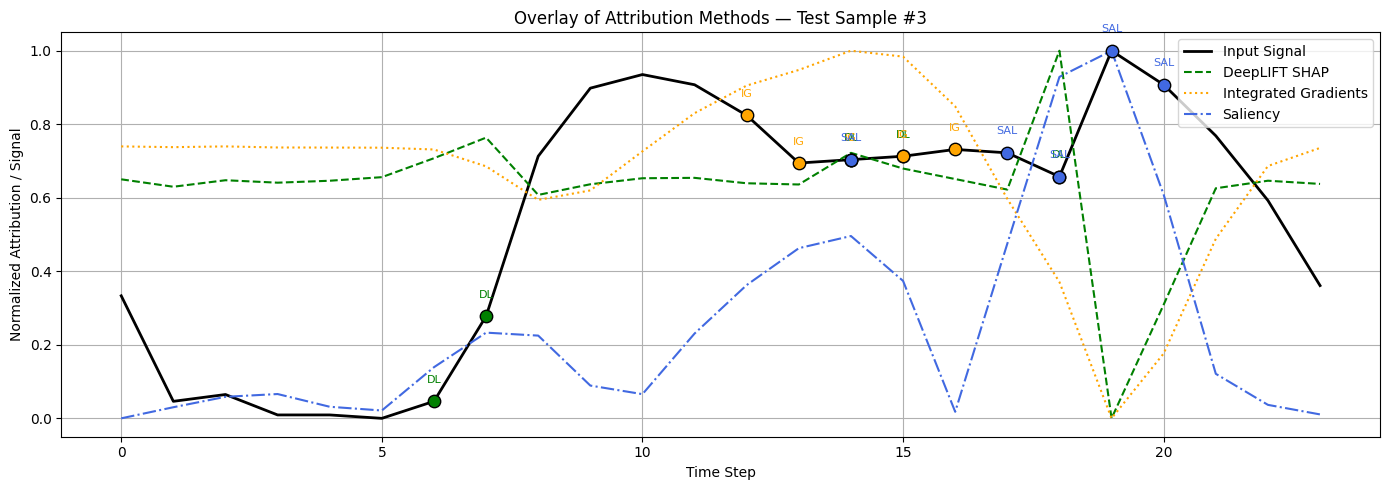

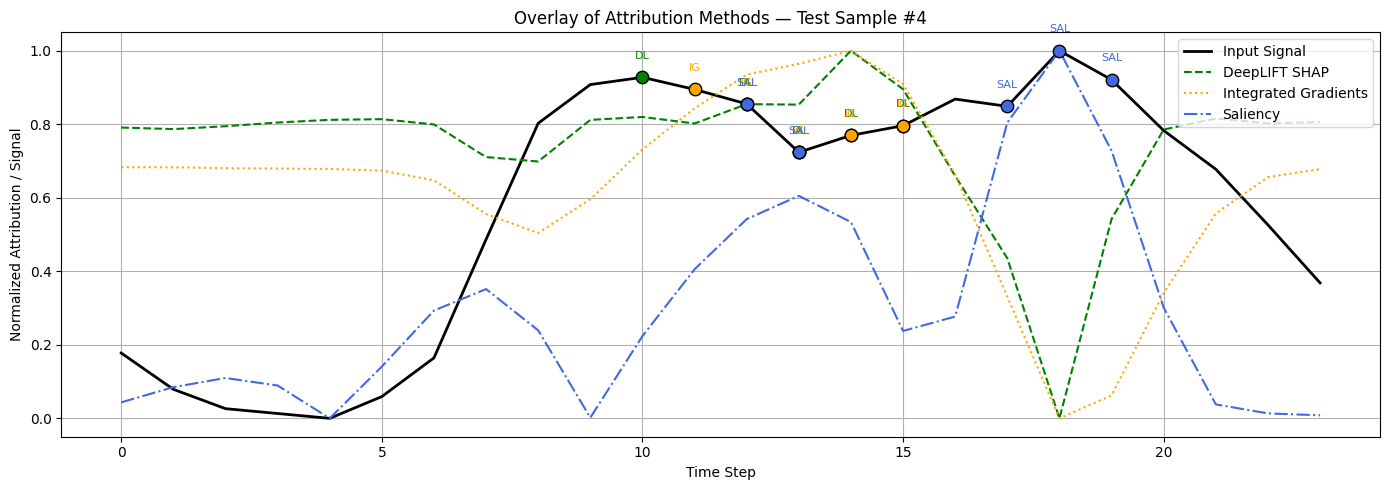

In [54]:


# ✅ Parameters
num_samples = 5  # Number of test samples to plot
top_k = 5        # Number of top spikes to annotate

# ✅ Normalization helper
def normalize_1d(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

# ✅ Loop through selected samples
for sample_idx in range(num_samples):
    input_signal = X_test_np[sample_idx]

    # Extract and normalize attributions
    dlshap_values = normalize_1d(dlshap_attr_np[sample_idx])
    ig_values = normalize_1d(ig_attr_np[sample_idx])
    saliency_values = normalize_1d(sal_attr_np[sample_idx])

    plt.figure(figsize=(14, 5))
    plt.plot(input_signal, label='Input Signal', color='black', linewidth=2)
    plt.plot(dlshap_values, label='DeepLIFT SHAP', linestyle='--', color='green')
    plt.plot(ig_values, label='Integrated Gradients', linestyle=':', color='orange')
    plt.plot(saliency_values, label='Saliency', linestyle='-.', color='royalblue')

    # Annotate top-k time steps per method
    def annotate_top_k(attribution, label, color):
        top_indices = np.argsort(-attribution)[:top_k]
        for i in top_indices:
            plt.scatter(i, input_signal[i], s=80, edgecolor='black', facecolor=color, zorder=5)
            plt.annotate(f"{label}", (i, input_signal[i] + 0.05), fontsize=8, color=color, ha='center')

    annotate_top_k(dlshap_values, "DL", "green")
    annotate_top_k(ig_values, "IG", "orange")
    annotate_top_k(saliency_values, "SAL", "royalblue")

    plt.title(f"Overlay of Attribution Methods — Test Sample #{sample_idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Attribution / Signal")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [55]:



def compute_fidelity_scores(wrapped_model, attributions_dict, X_test_tensor, X_test_np, device, top_k_ratio=0.1):
    """
    Compute R² fidelity scores across multiple XAI methods.

    Parameters:
    - wrapped_model: PyTorch model wrapped for attribution
    - attributions_dict: dict like {'IG': ig_attr_np, 'Saliency': sal_attr_np, 'DL': dlshap_attr_np}
    - X_test_tensor: original test input (tensor, shape [B, T, 1])
    - X_test_np: original test input (numpy, shape [B, T])
    - device: torch.device
    - top_k_ratio: proportion of top important features to mask (default = 10%)

    Returns:
    - fidelity_scores: dict of method name → R² score
    """

    fidelity_scores = {}

    for method_name, attr_np in attributions_dict.items():
        # Limit number of samples for safety
        num_samples = min(len(X_test_tensor), len(X_test_np), attr_np.shape[0])
        X_test_tensor_sub = X_test_tensor[:num_samples]
        X_test_np_sub = X_test_np[:num_samples]
        attr_np_sub = attr_np[:num_samples]

        # Get original predictions
        with torch.no_grad():
            original_preds = wrapped_model(X_test_tensor_sub.to(device)).cpu().numpy().flatten()

        # Determine top-k important time steps
        attr_importance = np.abs(attr_np_sub).mean(axis=0)
        top_k = int(top_k_ratio * len(attr_importance))
        important_indices = np.argsort(-attr_importance)[:top_k]

        # Perturb test set: replace top-k time steps with mean value
        X_test_modified = X_test_np_sub.copy()
        for i in important_indices:
            X_test_modified[:, i] = np.mean(X_test_np_sub[:, i])
        X_test_modified_tensor = torch.tensor(X_test_modified, dtype=torch.float32).unsqueeze(-1).to(device)

        # Get new predictions after feature replacement
        with torch.no_grad():
            new_preds = wrapped_model(X_test_modified_tensor).cpu().numpy().flatten()

        # Compute R² fidelity
        fidelity = r2_score(original_preds, new_preds)
        fidelity_scores[method_name] = fidelity

    return fidelity_scores


In [56]:
fidelity_scores = compute_fidelity_scores(
    wrapped_model=wrapped_model,
    attributions_dict={
        "DeepLIFT SHAP": dlshap_attr_np,
        "Integrated Gradients": ig_attr_np,
        "Saliency": sal_attr_np
    },
    X_test_tensor=X_test_tensor,
    X_test_np=X_test_np,
    device=device,
    top_k_ratio=0.1
)

print("🔍 Fidelity Scores (R²):")
for method, score in fidelity_scores.items():
    print(f"{method}: {score:.4f}")


🔍 Fidelity Scores (R²):
DeepLIFT SHAP: 0.7613
Integrated Gradients: 0.6391
Saliency: 0.6950


In [57]:


def plot_fidelity_scores(fidelity_scores, title="Fidelity Scores (R²)", save_path=None):
    """
    Plot a bar chart of R² fidelity scores across XAI methods.

    Parameters:
    - fidelity_scores: dict { method_name: score (float) }
    - title: str, plot title
    - save_path: str or None, path to save the plot if provided
    """

    methods = list(fidelity_scores.keys())
    scores = list(fidelity_scores.values())
    colors = ['green', 'orange', 'royalblue'][:len(scores)]  # Extend if needed

    plt.figure(figsize=(8, 5))
    bars = plt.bar(methods, scores, color=colors)

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
                 f"{height:.4f}", ha='center', va='bottom', fontsize=10)

    plt.ylim(0, 1.05)
    plt.ylabel("Fidelity Score (R²)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        print(f"📊 Fidelity plot saved to {save_path}")

    plt.tight_layout()
    plt.show()


📊 Fidelity plot saved to results/fidelity_scores_barplot.png


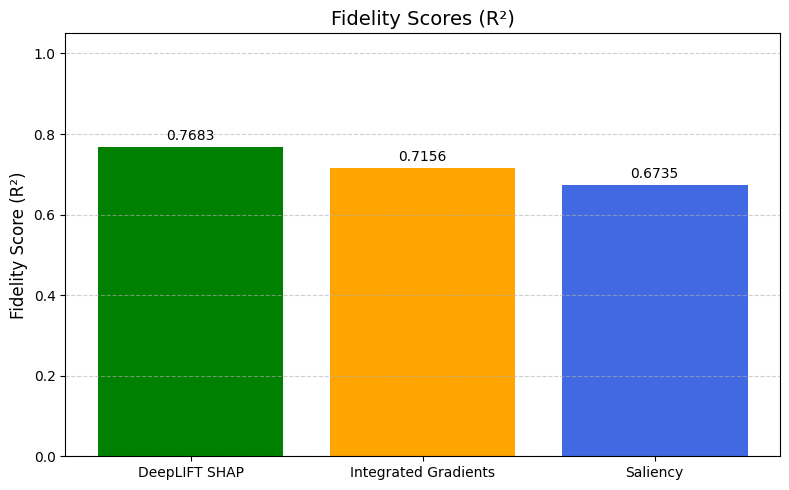

In [ ]:
plot_fidelity_scores(fidelity_scores, save_path="results/fidelity_scores_barplot.png")


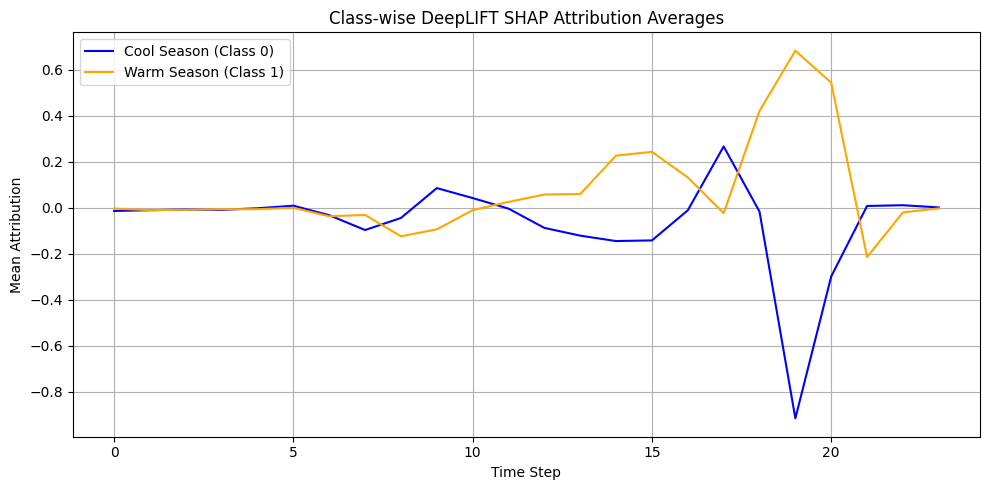

In [58]:
# ✅ Get just the labels for the 30 test samples
y_test_sample = y_test_tensor[:30].cpu().numpy()

# ✅ Then compute class-wise mean attributions
mean_attr_class_0 = np.mean(dlshap_attr_np[y_test_sample == 0], axis=0)
mean_attr_class_1 = np.mean(dlshap_attr_np[y_test_sample == 1], axis=0)

# ✅ Plot them
plt.figure(figsize=(10, 5))
plt.plot(mean_attr_class_0, label="Cool Season (Class 0)", color='blue')
plt.plot(mean_attr_class_1, label="Warm Season (Class 1)", color='orange')
plt.xlabel("Time Step")
plt.ylabel("Mean Attribution")
plt.title("Class-wise DeepLIFT SHAP Attribution Averages")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [59]:
import numpy as np
import torch
from sklearn.metrics import r2_score
from collections import defaultdict
import warnings

def compute_fidelity_scores(wrapped_model, attributions_dict, X_test_tensor, X_test_np, device, top_k_ratio=0.1):
    """
    Compute R² fidelity scores across multiple XAI methods.

    Parameters:
    - wrapped_model: PyTorch model wrapped for attribution
    - attributions_dict: dict like {'IG': ig_attr_np, 'Saliency': sal_attr_np, 'DL': dlshap_attr_np}
    - X_test_tensor: original test input (tensor, shape [B, T, 1])
    - X_test_np: original test input (numpy, shape [B, T])
    - device: torch.device
    - top_k_ratio: proportion of top important features to mask (default = 10%)

    Returns:
    - fidelity_scores: dict of method name → R² score
    """

    fidelity_scores = {}

    for method_name, attr_np in attributions_dict.items():
        # Limit number of samples for safety
        num_samples = min(len(X_test_tensor), len(X_test_np), attr_np.shape[0])
        X_test_tensor_sub = X_test_tensor[:num_samples]
        X_test_np_sub = X_test_np[:num_samples]
        attr_np_sub = attr_np[:num_samples]

        # Get original predictions
        with torch.no_grad():
            original_preds = wrapped_model(X_test_tensor_sub.to(device)).cpu().numpy().flatten()

        # Determine top-k important time steps
        attr_importance = np.abs(attr_np_sub).mean(axis=0)
        top_k = max(1, int(top_k_ratio * len(attr_importance)))  # Ensure at least 1 feature
        important_indices = np.argsort(-attr_importance)[:top_k]

        # Perturb test set: replace top-k time steps with mean value
        X_test_modified = X_test_np_sub.copy()
        for i in important_indices:
            X_test_modified[:, i] = np.mean(X_test_np_sub[:, i])
        X_test_modified_tensor = torch.tensor(X_test_modified, dtype=torch.float32).unsqueeze(-1).to(device)

        # Get new predictions after feature replacement
        with torch.no_grad():
            new_preds = wrapped_model(X_test_modified_tensor).cpu().numpy().flatten()

        # Compute R² fidelity
        fidelity = r2_score(original_preds, new_preds)
        fidelity_scores[method_name] = fidelity

    return fidelity_scores

def run_multiple_fidelity_evaluations(wrapped_model, attributions_dict, X_test_tensor,
                                    X_test_np, device, num_runs=5, top_k_ratio=0.1,
                                    random_seed=42):
    """
    Execute fidelity evaluation multiple times and compute statistics.

    Parameters:
    - wrapped_model: PyTorch model wrapped for attribution
    - attributions_dict: dict of attribution arrays
    - X_test_tensor: test data as tensor
    - X_test_np: test data as numpy array
    - device: torch device
    - num_runs: number of evaluation runs (default=5)
    - top_k_ratio: proportion of features to mask
    - random_seed: seed for reproducibility

    Returns:
    - results_summary: dict containing mean, std, and individual run results
    """

    # Set random seed for reproducibility
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Storage for results across runs
    all_runs_results = defaultdict(list)
    individual_run_details = []

    print(f"Starting {num_runs} fidelity evaluation runs...")
    print(f"Top-k masking ratio: {top_k_ratio:.1%}")
    print(f"Test samples: {len(X_test_tensor)}")
    print("-" * 50)

    for run_idx in range(num_runs):
        print(f"Executing run {run_idx + 1}/{num_runs}")

        try:
            # Compute fidelity scores for this run
            run_fidelity = compute_fidelity_scores(
                wrapped_model=wrapped_model,
                attributions_dict=attributions_dict,
                X_test_tensor=X_test_tensor,
                X_test_np=X_test_np,
                device=device,
                top_k_ratio=top_k_ratio
            )

            # Store results
            individual_run_details.append(run_fidelity)
            for method, score in run_fidelity.items():
                all_runs_results[method].append(score)

            # Display run results
            print(f"  Run {run_idx + 1} results:")
            for method, score in run_fidelity.items():
                print(f"    {method}: {score:.4f}")

        except Exception as e:
            print(f"  Error in run {run_idx + 1}: {str(e)}")
            warnings.warn(f"Run {run_idx + 1} failed: {str(e)}")
            continue

    # Compute summary statistics
    results_summary = {
        'mean_scores': {},
        'std_scores': {},
        'min_scores': {},
        'max_scores': {},
        'individual_runs': individual_run_details,
        'num_successful_runs': len(individual_run_details)
    }

    print("\n" + "=" * 50)
    print("FIDELITY EVALUATION SUMMARY")
    print("=" * 50)

    for method in all_runs_results.keys():
        scores = np.array(all_runs_results[method])

        results_summary['mean_scores'][method] = np.mean(scores)
        results_summary['std_scores'][method] = np.std(scores)
        results_summary['min_scores'][method] = np.min(scores)
        results_summary['max_scores'][method] = np.max(scores)

        print(f"\n{method} Method:")
        print(f"  Mean R²: {results_summary['mean_scores'][method]:.4f}")
        print(f"  Std Dev: {results_summary['std_scores'][method]:.4f}")
        print(f"  Range: [{results_summary['min_scores'][method]:.4f}, {results_summary['max_scores'][method]:.4f}]")
        print(f"  Individual runs: {[f'{s:.4f}' for s in scores]}")

    print(f"\nSuccessful runs: {results_summary['num_successful_runs']}/{num_runs}")

    return results_summary

def compare_method_performance(results_summary):
    """
    Analyze and rank method performance based on fidelity scores.

    Parameters:
    - results_summary: output from run_multiple_fidelity_evaluations

    Returns:
    - performance_ranking: list of methods ranked by mean fidelity score
    """

    methods_performance = []
    for method, mean_score in results_summary['mean_scores'].items():
        std_score = results_summary['std_scores'][method]
        methods_performance.append((method, mean_score, std_score))

    # Sort by mean fidelity score (descending)
    performance_ranking = sorted(methods_performance, key=lambda x: x[1], reverse=True)

    print("\n" + "=" * 50)
    print("METHOD PERFORMANCE RANKING")
    print("=" * 50)

    for rank, (method, mean_score, std_score) in enumerate(performance_ranking, 1):
        print(f"{rank}. {method}: {mean_score:.4f} (±{std_score:.4f})")

    return performance_ranking

# Example usage function
def execute_fidelity_analysis(wrapped_model, attributions_dict, X_test_tensor,
                            X_test_np, device, num_runs=5):
    """
    Complete fidelity analysis workflow.

    Parameters:
    - wrapped_model: trained model
    - attributions_dict: attribution results from different methods
    - X_test_tensor: test data (tensor format)
    - X_test_np: test data (numpy format)
    - device: computation device
    - num_runs: number of evaluation iterations

    Returns:
    - complete_results: comprehensive analysis results
    """

    # Execute multiple runs
    results_summary = run_multiple_fidelity_evaluations(
        wrapped_model=wrapped_model,
        attributions_dict=attributions_dict,
        X_test_tensor=X_test_tensor,
        X_test_np=X_test_np,
        device=device,
        num_runs=num_runs,
        top_k_ratio=0.1
    )

    # Analyze performance
    performance_ranking = compare_method_performance(results_summary)

    # Compile complete results
    complete_results = {
        'summary': results_summary,
        'ranking': performance_ranking,
        'evaluation_params': {
            'num_runs': num_runs,
            'top_k_ratio': 0.1,
            'num_test_samples': len(X_test_tensor)
        }
    }

    return complete_results



In [61]:
# Usage example:

# Assuming you have your model and data ready:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Your attribution methods results
attributions_dict = {
    'Integrated_Gradients': ig_attr_np,
    'Saliency_Maps':sal_attr_np,
    'DeepLIFT_SHAP': dlshap_attr_np
}

# Execute the analysis
results = execute_fidelity_analysis(
    wrapped_model=wrapped_model,
    attributions_dict=attributions_dict,
    X_test_tensor=X_test_tensor,
    X_test_np=X_test_np,
    device=device,
    num_runs=10
)


Starting 10 fidelity evaluation runs...
Top-k masking ratio: 10.0%
Test samples: 165
--------------------------------------------------
Executing run 1/10
  Run 1 results:
    Integrated_Gradients: 0.7397
    Saliency_Maps: 0.6877
    DeepLIFT_SHAP: 0.7462
Executing run 2/10
  Run 2 results:
    Integrated_Gradients: 0.6702
    Saliency_Maps: 0.6354
    DeepLIFT_SHAP: 0.7306
Executing run 3/10
  Run 3 results:
    Integrated_Gradients: 0.6949
    Saliency_Maps: 0.7181
    DeepLIFT_SHAP: 0.7705
Executing run 4/10
  Run 4 results:
    Integrated_Gradients: 0.7123
    Saliency_Maps: 0.7111
    DeepLIFT_SHAP: 0.7864
Executing run 5/10
  Run 5 results:
    Integrated_Gradients: 0.6297
    Saliency_Maps: 0.6829
    DeepLIFT_SHAP: 0.7441
Executing run 6/10
  Run 6 results:
    Integrated_Gradients: 0.7104
    Saliency_Maps: 0.7156
    DeepLIFT_SHAP: 0.7461
Executing run 7/10
  Run 7 results:
    Integrated_Gradients: 0.6467
    Saliency_Maps: 0.6210
    DeepLIFT_SHAP: 0.7955
Executing run 8/1